In [ ]:
!pip install biosppy

In [ ]:
# import mne
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import pywt
from scipy.signal import butter, lfilter

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = "/content/drive/MyDrive/DIS_Dr_Liu/"
small_X_path = folder_path + "small_X.npy"
small_y_path = folder_path + "small_y.npy"

In [ ]:
ecg_X = np.load(small_X_path, allow_pickle=True)
ecg_y = np.load(small_y_path, allow_pickle=True)

print('X: ', ecg_X.shape)
print('y: ', ecg_y.shape)

print(ecg_X[0])
print(ecg_y[0])

X:  (2164, 12, 5000)
y:  (2164,)
[[  10   15   -5 ... -107  -88  -39]
 [ -20   -5  -20 ... -122 -112  -63]
 [ -30  -20  -15 ...  -15  -24  -24]
 ...
 [  34   29   49 ...  137  127   83]
 [ -29  -34  -10 ...   83   73   20]
 [ -39  -59  -34 ...  142  122   39]]
1


## 3.1.1 ECG Preprocessing

In [ ]:
# Function to apply Butterworth band-stop filter
def apply_bandstop_filter(data, fs= 500, lowcut=50, highcut=60, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Function to remove baseline wander using DWT
def remove_baseline_wander(ecg_signal):
    # Decompose signal using DWT
    wavelet = 'db4'  # Daubechies 4 wavelet
    coeffs = pywt.wavedec(ecg_signal, wavelet)

    # Set the detail coefficients to zero to remove high-frequency noise
    coeffs[1:] = [np.zeros_like(detail) for detail in coeffs[1:]]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(coeffs, wavelet)

    return denoised_signal

In [ ]:
ecg_X[:, 0:1, :500].shape

(2164, 1, 500)

In [ ]:
X_ecg = ecg_X[:, 0:1, :]
X_ecg = X_ecg.reshape(2164,5000)
X_ecg.shape

NameError: ignored

In [ ]:
ecg_data = pd.DataFrame(X_ecg)
ecg_data

0     1     2     3     4     5     6     7     8     9     ...  4990  \
0       10    15    -5   -20   -15    -5     5    15    29    29  ...  -102   
1       68    68    68    68    63    59    54    49    59    59  ...   166   
2      -63   -68   -68   -68   -68   -68   -68   -68   -68   -68  ...   -10   
3      -15   -15   -15    -5     0     0     0     5     5    15  ...   -29   
4      -88   -88   -88   -88   -88   -88   -88   -88   -88   -88  ...   137   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2159    88    88    88    88    83    78    73    68    63    59  ...   -39   
2160   -10     0   -10   -24   -20   -10   -15   -20   -20   -15  ...  -132   
2161    34    63    44    29    49    59    44    39    44    54  ...  -132   
2162    59    59    59    59    68    68    68    68    73    78  ...   254   
2163    88    88    88    88   102   107   112   117   137   146  ...   -83   

      4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     -102  -112  -112   -93   -83   -88  -107   -88   -39  
1      156   156   151   151   166   156   156   151   166  
2       -5    -5    -5    -5    -5    -5    -5    -5     0  
3      -29   -29   -29   -20   -20   -20   -20   -20   -20  
4      137   137   137   137   137   137   137   137   137  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
2159   -44   -44   -44   -39   -39   -39   -34   -34   -34  
2160  -132  -146  -151  -137  -117  -127  -142  -127   -63  
2161  -127  -132  -146  -142  -137  -156  -181  -156   -59  
2162   249   239   229   229   220   215   210   195   195  
2163   -98  -107  -117  -127  -132  -137  -142  -156  -156  

[2164 rows x 5000 columns]

In [ ]:
preprocessed_ecg_data = pd.DataFrame()

for patient_idx, patient_row in ecg_data.iterrows():
    # Apply band-stop filter to remove powerline interference
    filtered_ecg = apply_bandstop_filter(patient_row)

    # Remove baseline wander
    denoised_ecg = remove_baseline_wander(filtered_ecg)

    # Add the preprocessed data to the new DataFrame
    preprocessed_ecg_data = pd.concat([preprocessed_ecg_data, pd.Series(denoised_ecg)], axis=1)

# Rename the columns in the new DataFrame for clarity (optional)
preprocessed_ecg_data.columns = ['Patient_{}'.format(i) for i in range(len(ecg_data))]

# Now, preprocessed_ecg_data contains the preprocessed ECG signals for each patient, and ecg_data remains unchanged.

In [ ]:
preprocessed_ecg_data = preprocessed_ecg_data.T
preprocessed_ecg_data = preprocessed_ecg_data.reset_index(drop=True)

In [ ]:
preprocessed_ecg_data.to_csv("/content/drive/MyDrive/DIS_Dr_Liu/preprocess3_1_1.csv")

In [ ]:
preprocessed_ecg_data.head()

0          1          2          3          4          5     \
0  -7.696447  -7.736225  -7.775956  -7.815618  -7.855452  -7.895387   
1  29.800622  29.656206  29.511784  29.367407  29.222508  29.077252   
2 -13.096913 -12.874004 -12.651089 -12.428251 -12.204584 -11.980352   
3   0.450229   0.488079   0.525921   0.563740   0.601701   0.639756   
4 -59.308927 -59.207814 -59.106712 -59.005661 -58.904228 -58.802540   

        6          7          8          9     ...        4990        4991  \
0  -7.934611  -7.973064  -8.011079  -8.048423  ...  -61.054305  -61.179231   
1  28.932764  28.789098  28.645845  28.503318  ...  144.270025  144.502164   
2 -11.763421 -11.554501 -11.350104 -11.152496  ...  -18.733190  -18.682385   
3   0.677086   0.713625   0.749721   0.785139  ...   -7.725031   -7.800130   
4 -58.702724 -58.604952 -58.508320 -58.413435  ...  125.437525  125.585592   

         4992        4993        4994        4995        4996        4997  \
0  -61.304626  -61.430712  -61.556835  -61.682949  -61.809564  -61.936535   
1  144.737657  144.978608  145.218855  145.457977  145.700777  145.945876   
2  -18.632326  -18.583616  -18.534485  -18.484812  -18.435974  -18.387576   
3   -7.875077   -7.949650   -8.024496   -8.099660   -8.174637   -8.249573   
4  125.734059  125.883136  126.032207  126.181229  126.330683  126.480431   

         4998        4999  
0  -62.062064  -62.186023  
1  146.173907  146.383417  
2  -18.334574  -18.276605  
3   -8.326474   -8.405491  
4  126.628649  126.775204  

[5 rows x 5000 columns]

## 3.1.2 Wave Segmentation

In [ ]:
paper_1 = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/preprocess3_1_1.csv")
paper_1.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
ecg_data

0     1     2     3     4     5     6     7     8     9     ...  4990  \
0       10    15    -5   -20   -15    -5     5    15    29    29  ...  -102   
1       68    68    68    68    63    59    54    49    59    59  ...   166   
2      -63   -68   -68   -68   -68   -68   -68   -68   -68   -68  ...   -10   
3      -15   -15   -15    -5     0     0     0     5     5    15  ...   -29   
4      -88   -88   -88   -88   -88   -88   -88   -88   -88   -88  ...   137   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2159    88    88    88    88    83    78    73    68    63    59  ...   -39   
2160   -10     0   -10   -24   -20   -10   -15   -20   -20   -15  ...  -132   
2161    34    63    44    29    49    59    44    39    44    54  ...  -132   
2162    59    59    59    59    68    68    68    68    73    78  ...   254   
2163    88    88    88    88   102   107   112   117   137   146  ...   -83   

      4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     -102  -112  -112   -93   -83   -88  -107   -88   -39  
1      156   156   151   151   166   156   156   151   166  
2       -5    -5    -5    -5    -5    -5    -5    -5     0  
3      -29   -29   -29   -20   -20   -20   -20   -20   -20  
4      137   137   137   137   137   137   137   137   137  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
2159   -44   -44   -44   -39   -39   -39   -34   -34   -34  
2160  -132  -146  -151  -137  -117  -127  -142  -127   -63  
2161  -127  -132  -146  -142  -137  -156  -181  -156   -59  
2162   249   239   229   229   220   215   210   195   195  
2163   -98  -107  -117  -127  -132  -137  -142  -156  -156  

[2164 rows x 5000 columns]

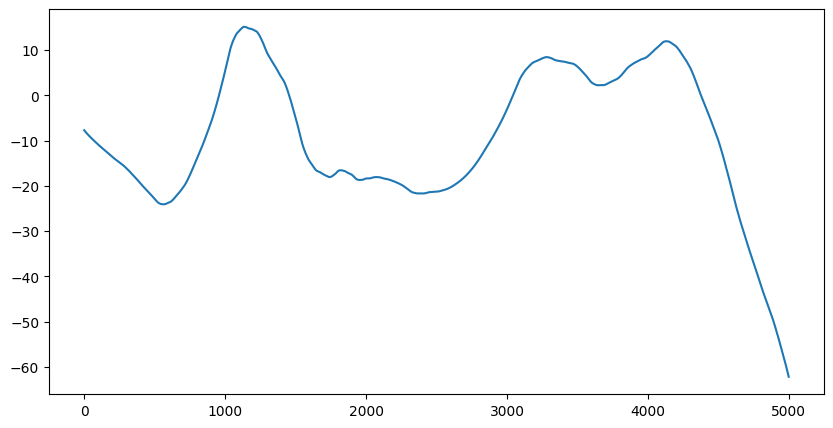

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(paper_1.iloc[0, :].values)

([<matplotlib.axis.XTick at 0x798fc63b3040>,
 [Text(0, 0, '0'),
  Text(100, 0, '100'),
  Text(200, 0, '200'),
  Text(300, 0, '300'),
  Text(400, 0, '400'),
  Text(500, 0, '500'),
  Text(600, 0, '600'),
  Text(700, 0, '700'),
  Text(800, 0, '800'),
  Text(900, 0, '900'),
  Text(1000, 0, '1000'),
  Text(1100, 0, '1100'),
  Text(1200, 0, '1200'),
  Text(1300, 0, '1300'),
  Text(1400, 0, '1400'),
  Text(1500, 0, '1500'),
  Text(1600, 0, '1600'),
  Text(1700, 0, '1700'),
  Text(1800, 0, '1800'),
  Text(1900, 0, '1900'),
  Text(2000, 0, '2000'),
  Text(2100, 0, '2100'),
  Text(2200, 0, '2200'),
  Text(2300, 0, '2300'),
  Text(2400, 0, '2400'),
  Text(2500, 0, '2500'),
  Text(2600, 0, '2600'),
  Text(2700, 0, '2700'),
  Text(2800, 0, '2800'),
  Text(2900, 0, '2900'),
  Text(3000, 0, '3000'),
  Text(3100, 0, '3100'),
  Text(3200, 0, '3200'),
  Text(3300, 0, '3300'),
  Text(3400, 0, '3400'),
  Text(3500, 0, '3500'),
  Text(3600, 0, '3600'),
  Text(3700, 0, '3700'),
  Text(3800, 0, '3800'),
  Te

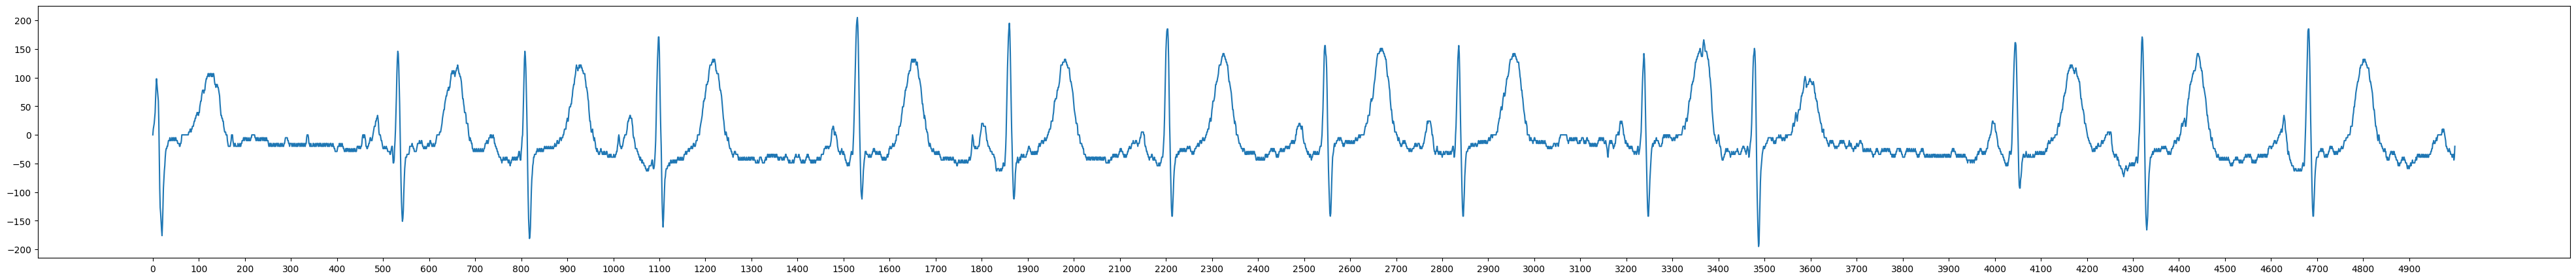

In [ ]:
original = pd.DataFrame(X_ecg)
plt.figure(figsize=(50,5))
plt.plot(original.iloc[1000, :].values)
plt.xticks(range(0, len(original.iloc[1000, :].values), 100))  # Set x-axis ticks with a difference of 100

In [ ]:
X_ecg = ecg_X[:, 0, :]
X_ecg = X_ecg.reshape(2164,5000)
original = pd.DataFrame(X_ecg)

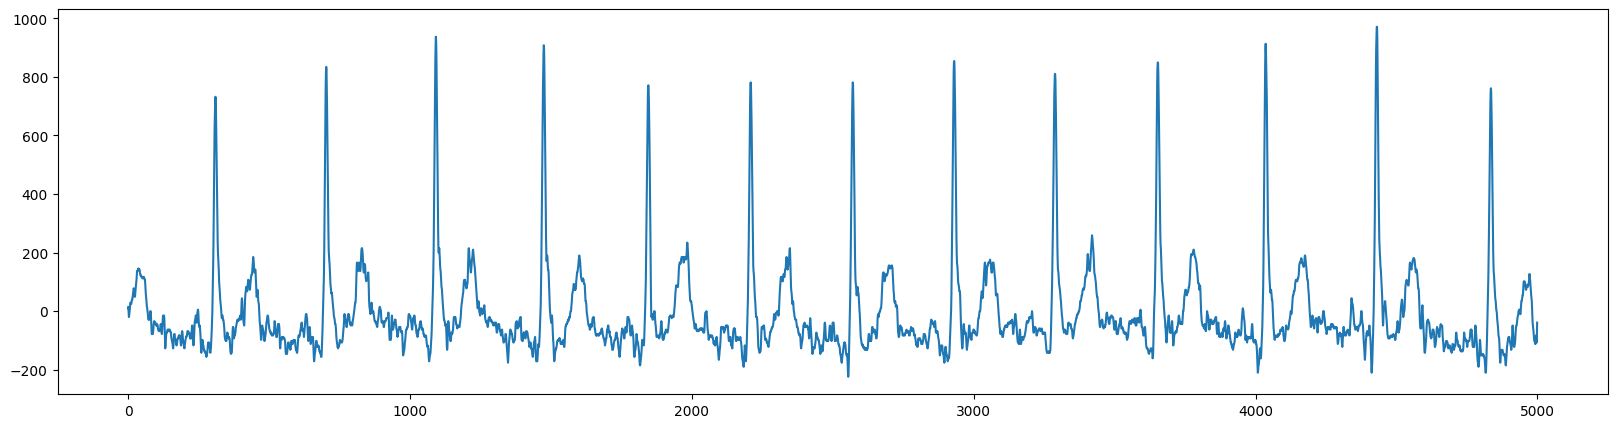

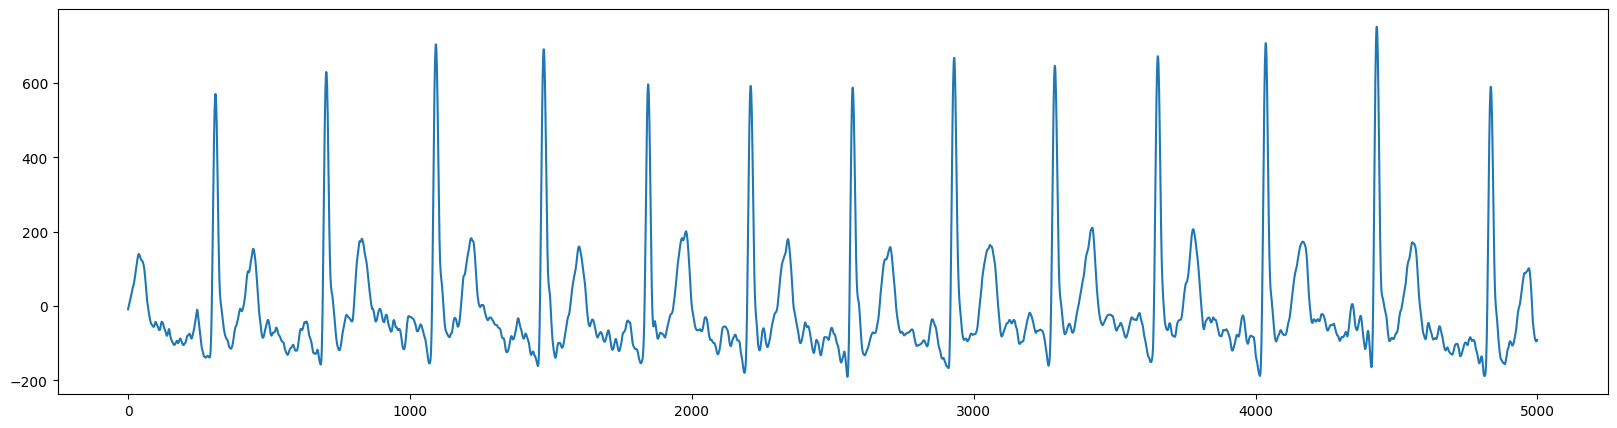

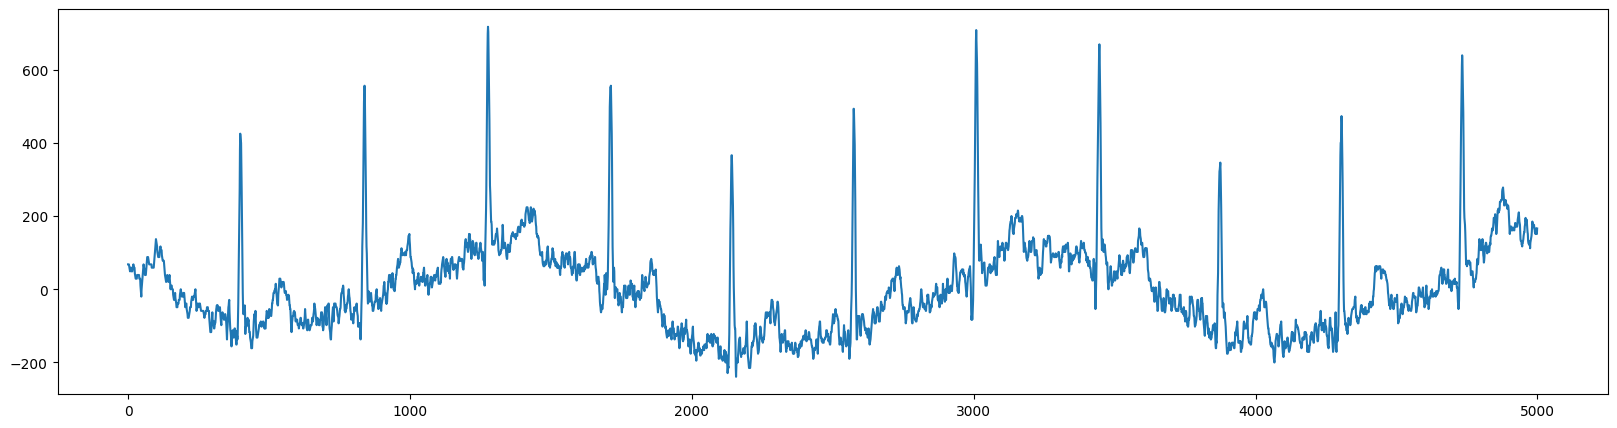

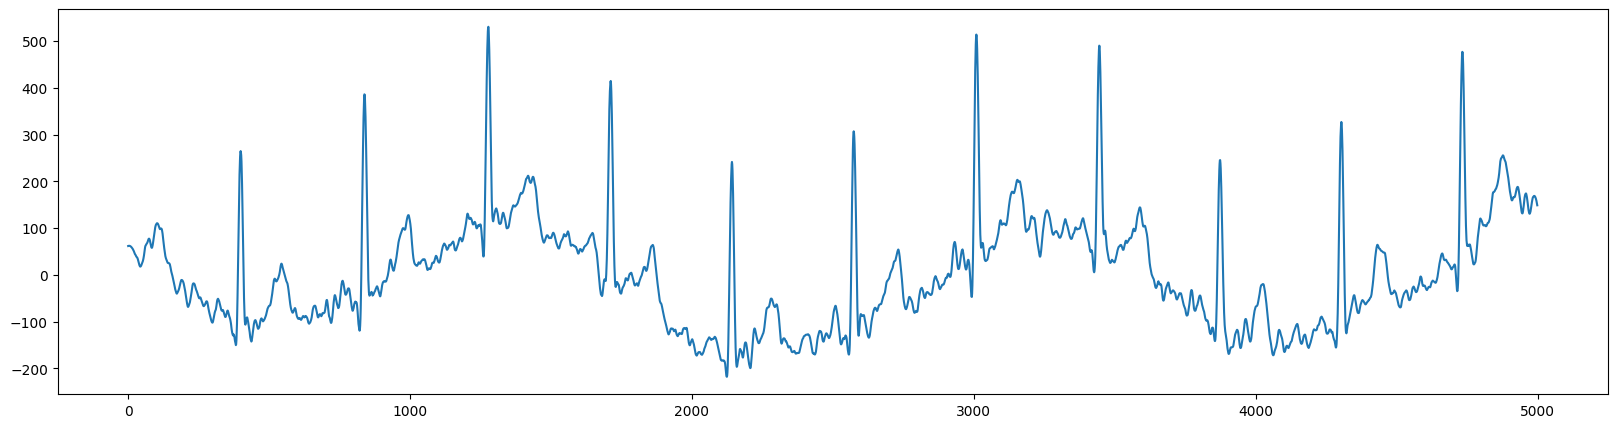

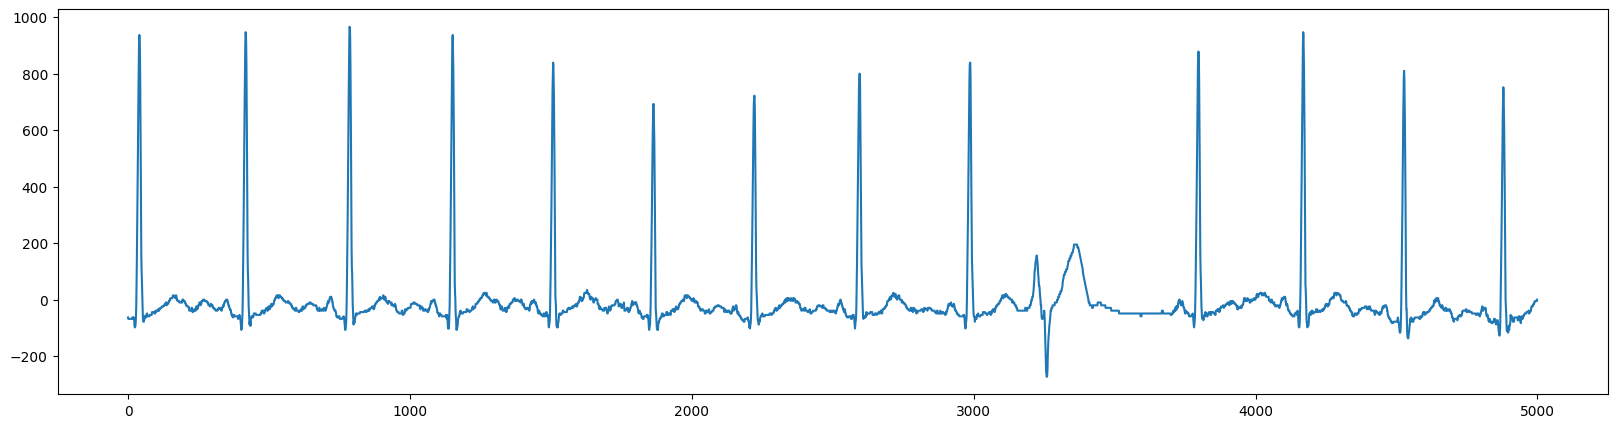

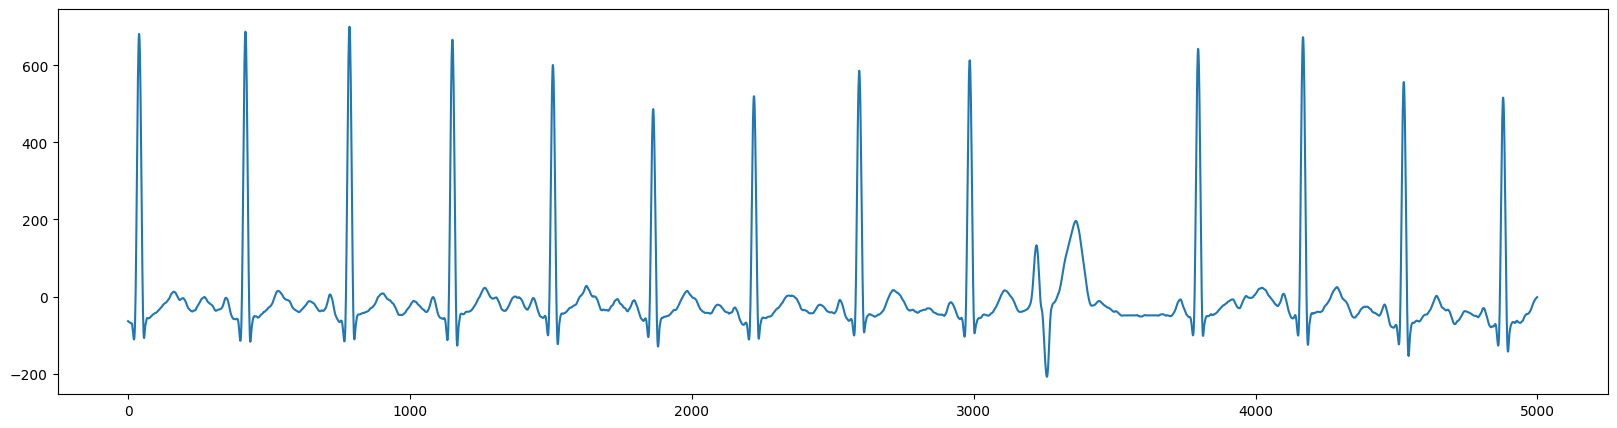

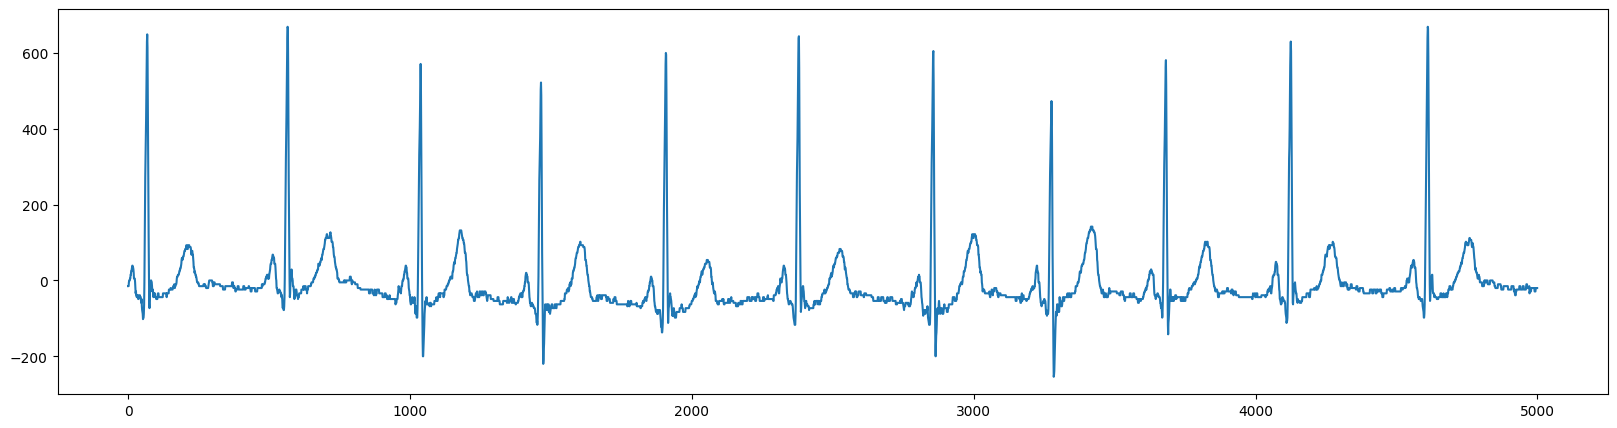

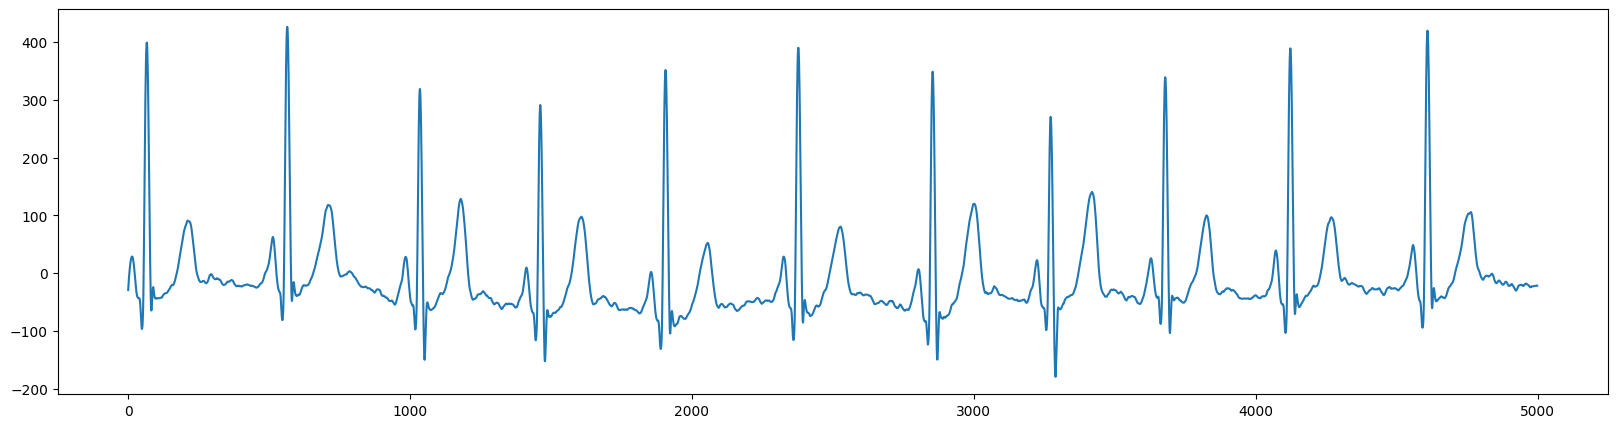

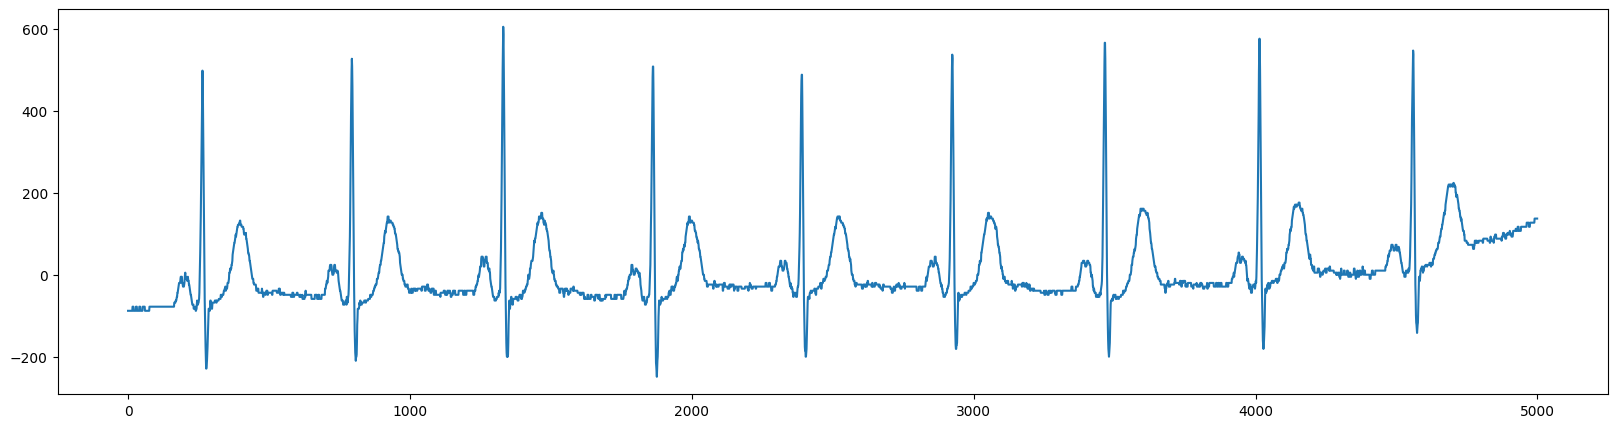

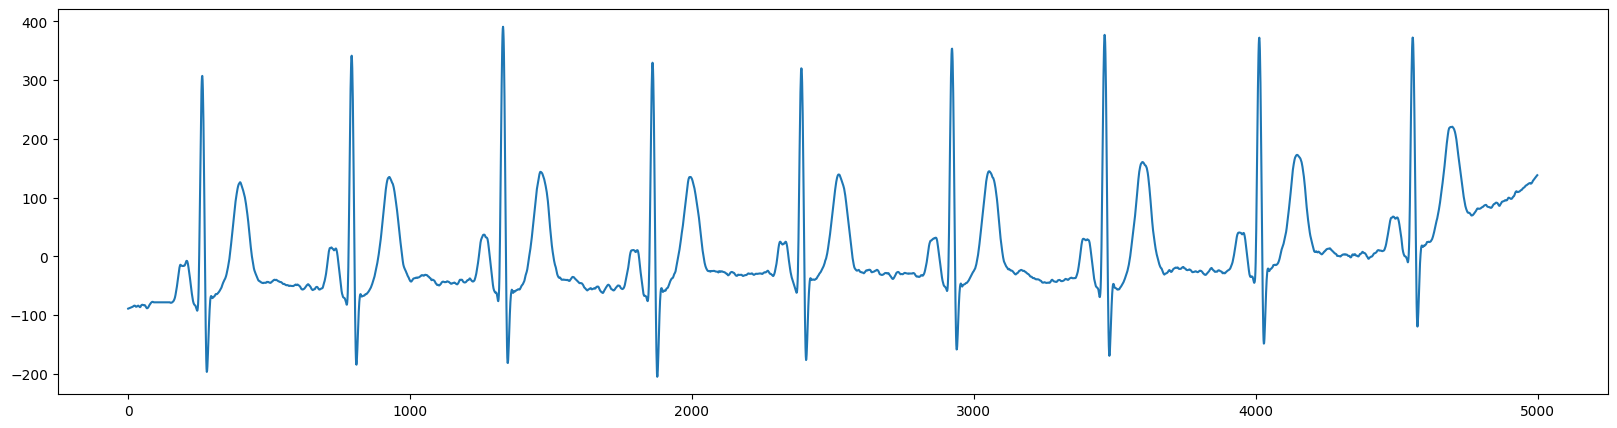

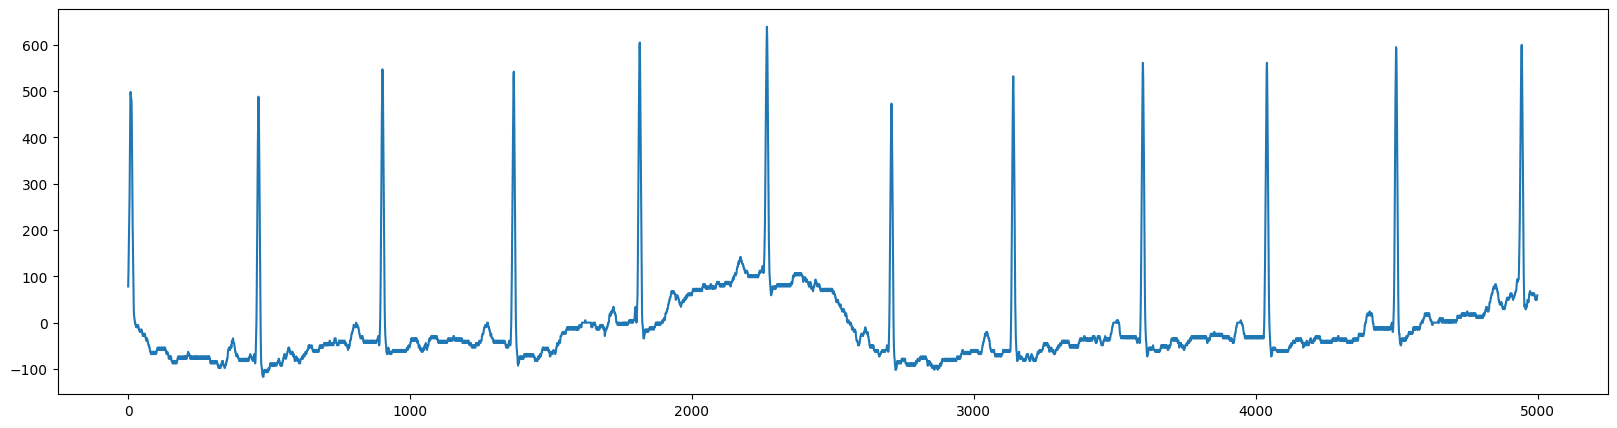

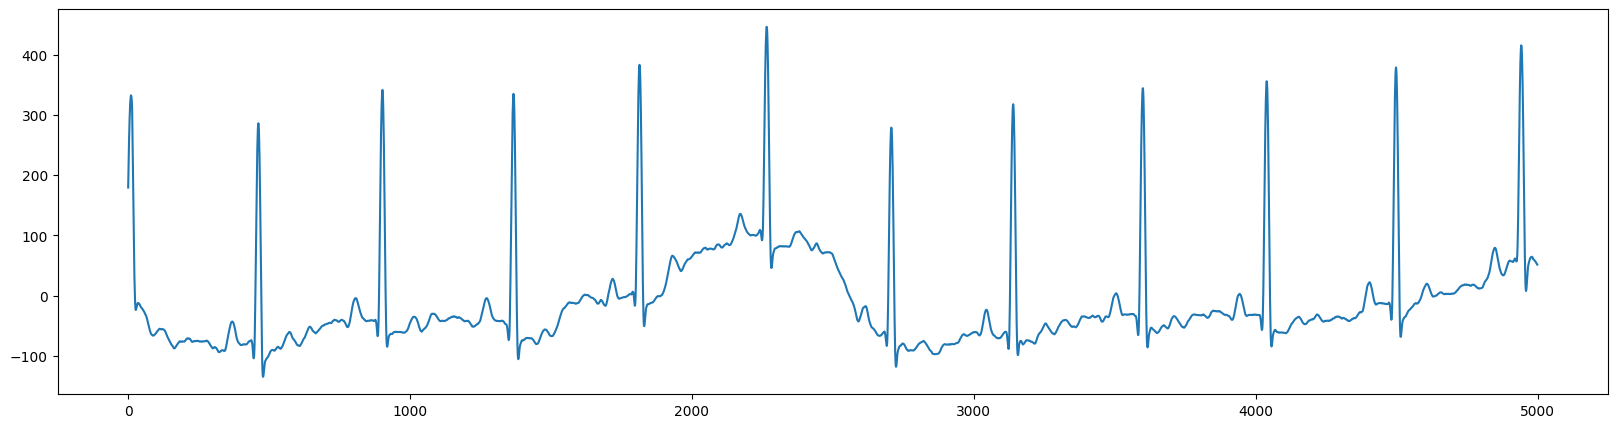

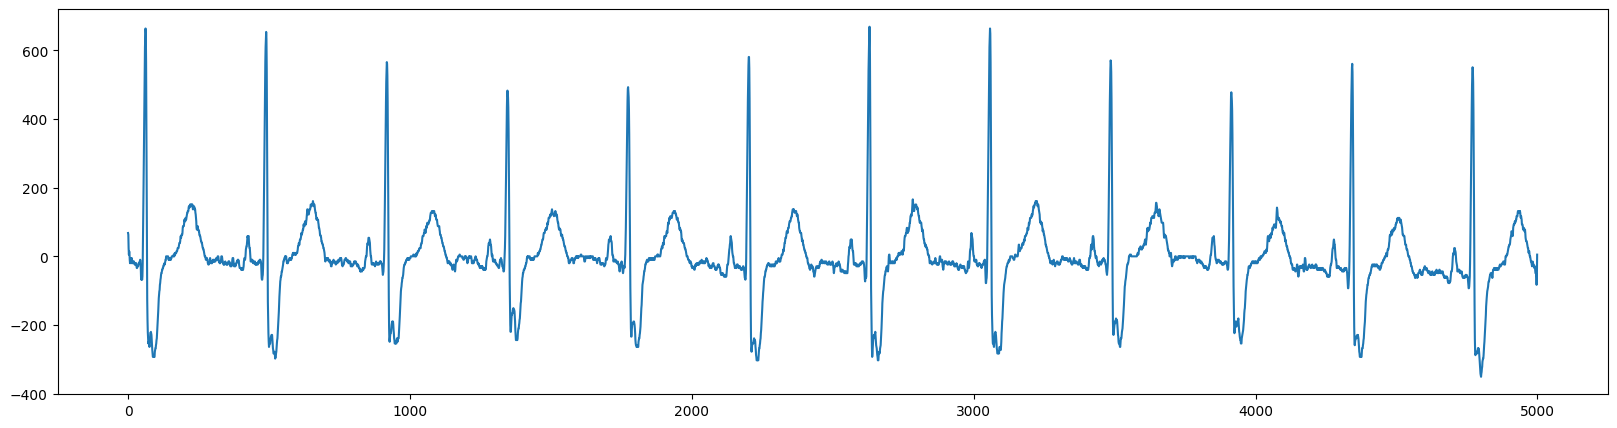

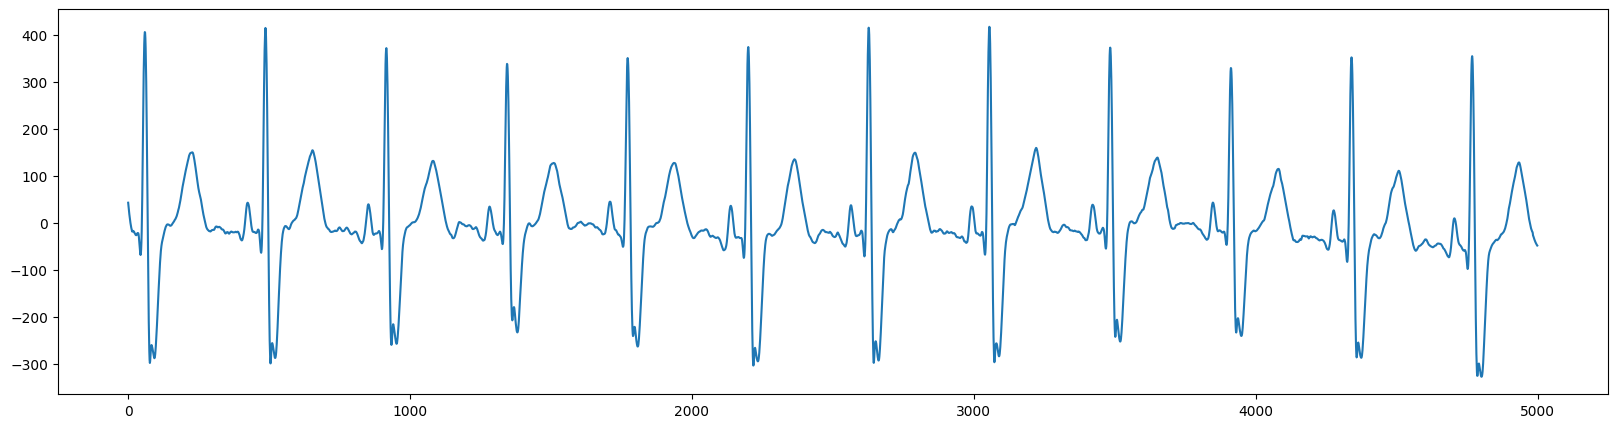

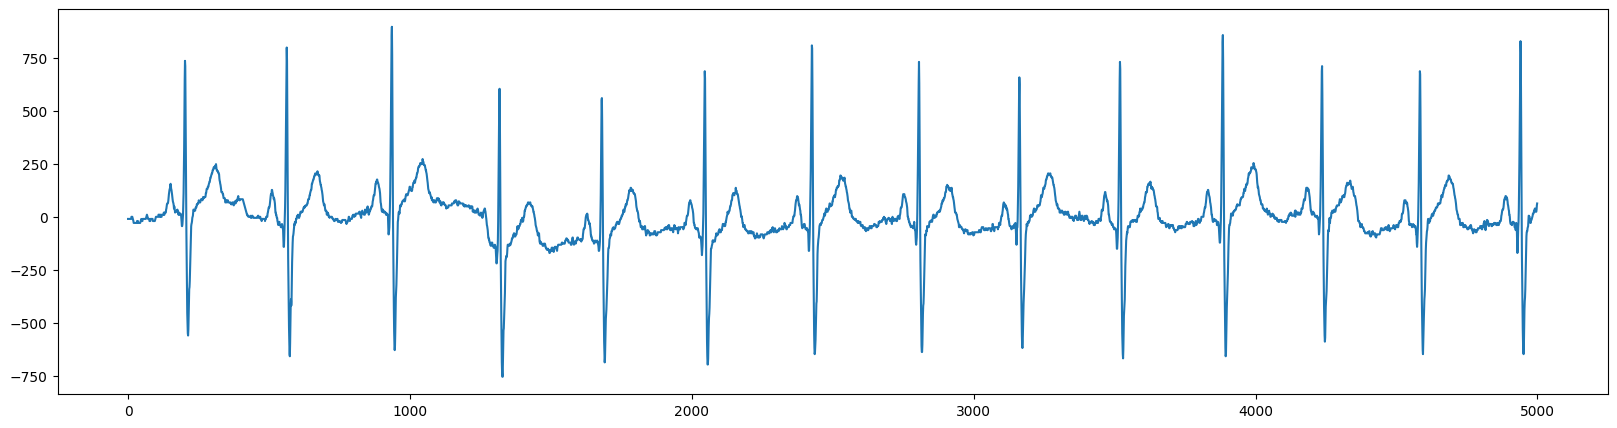

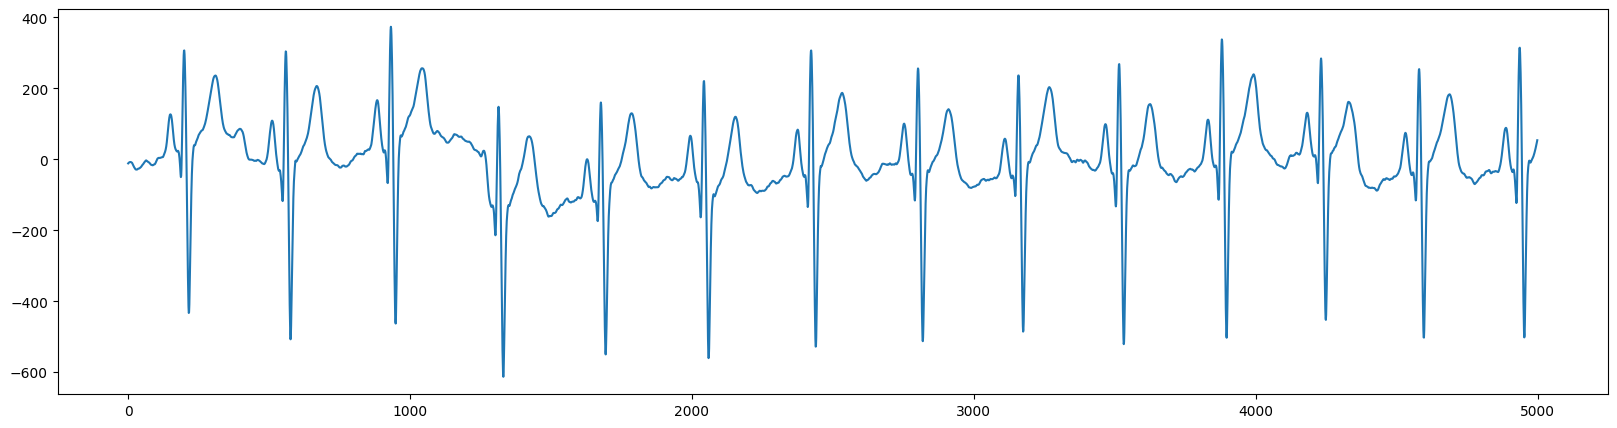

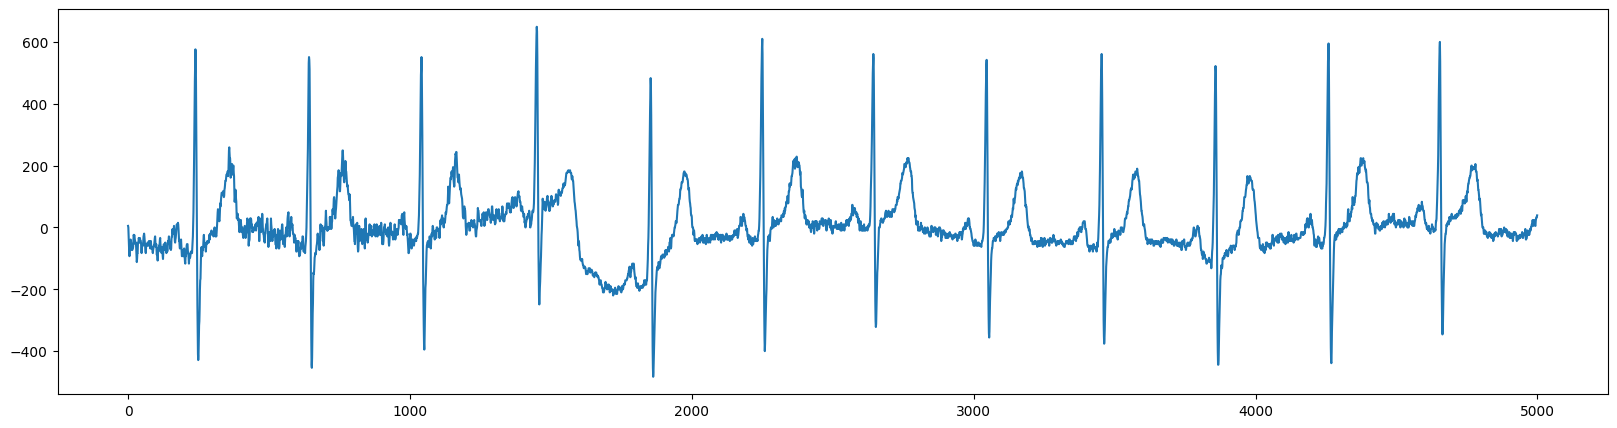

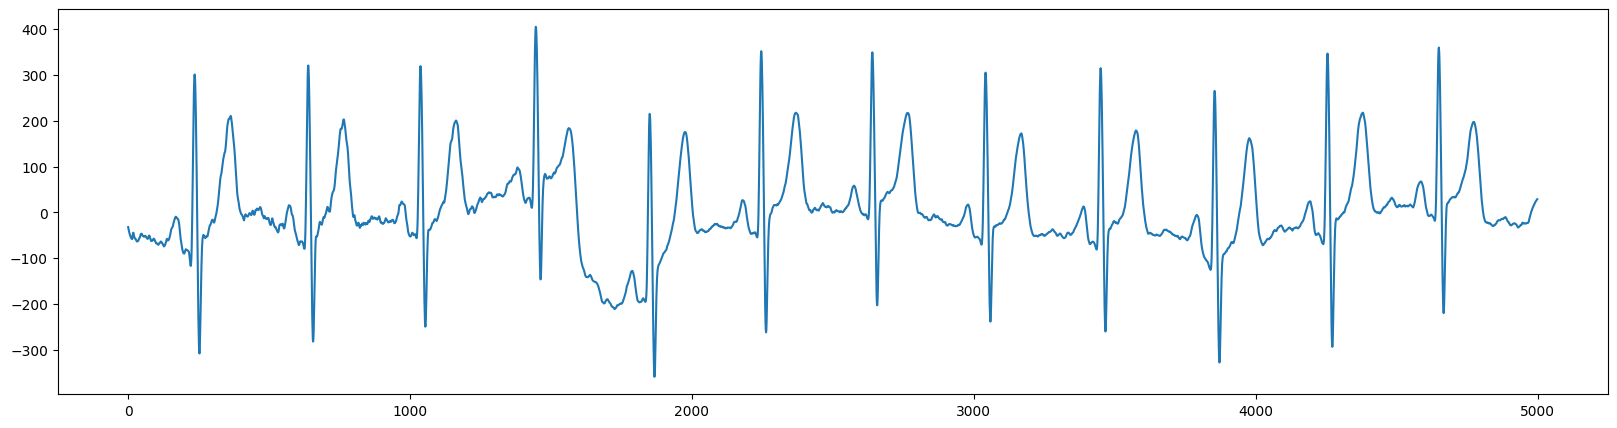

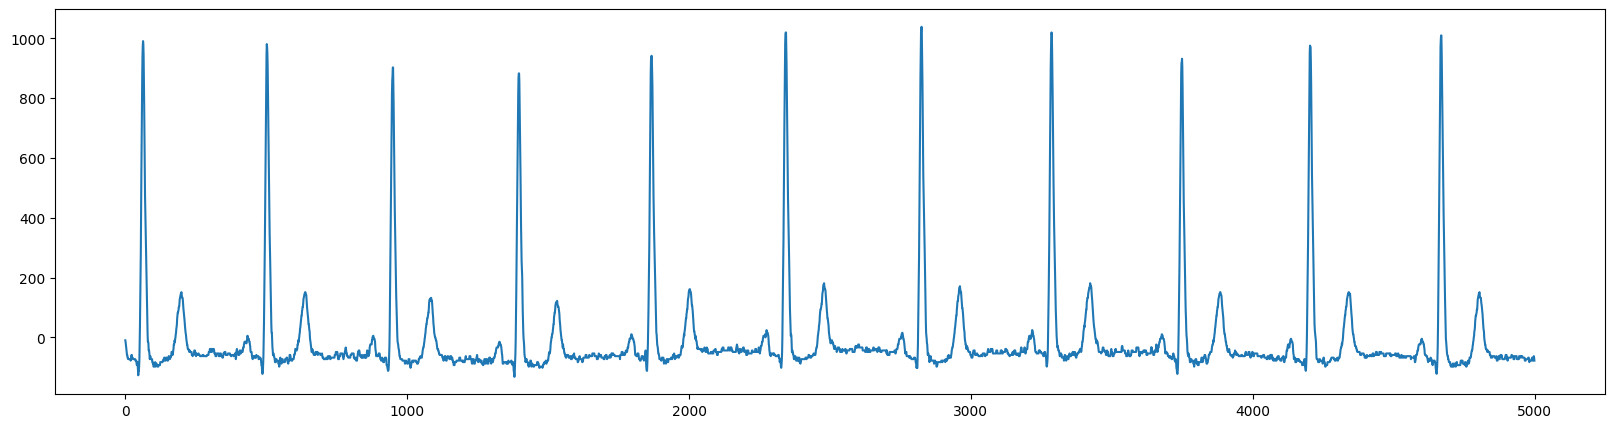

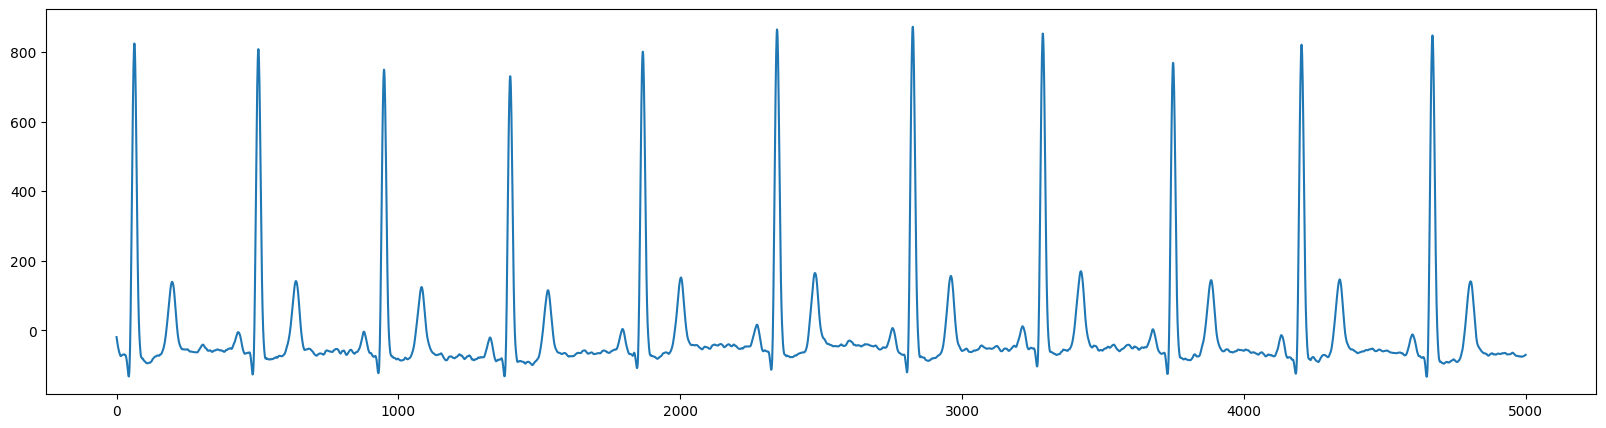

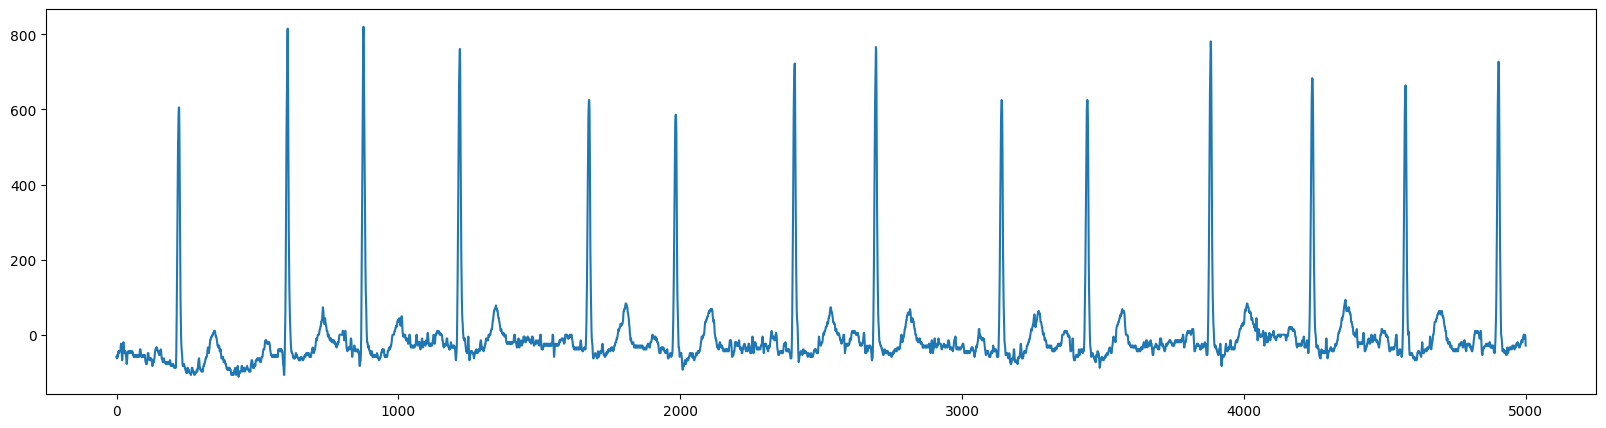

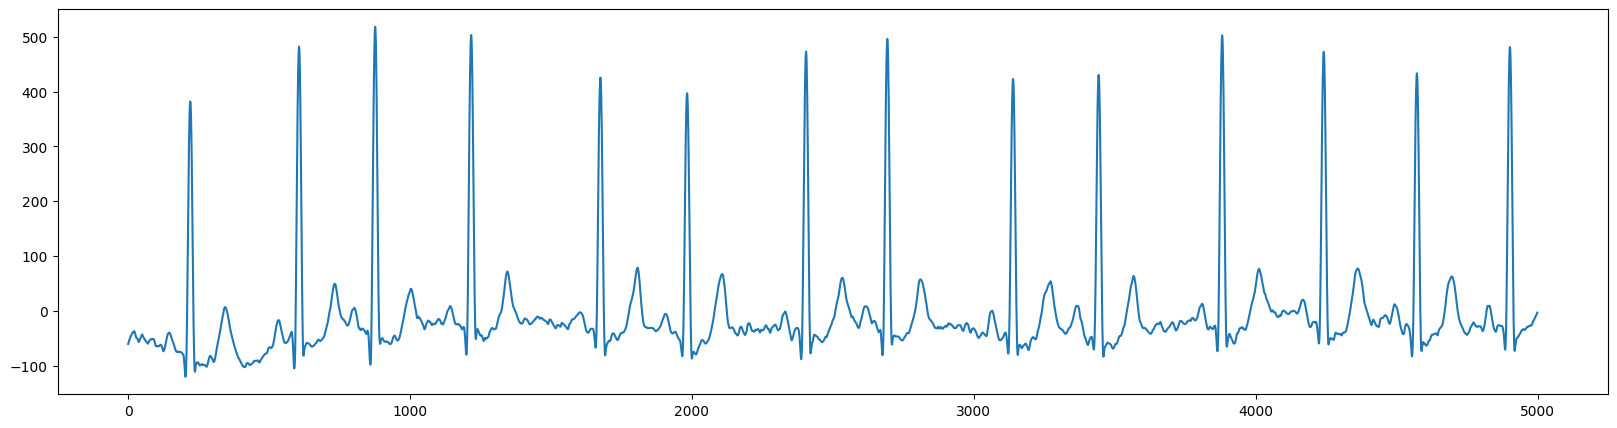

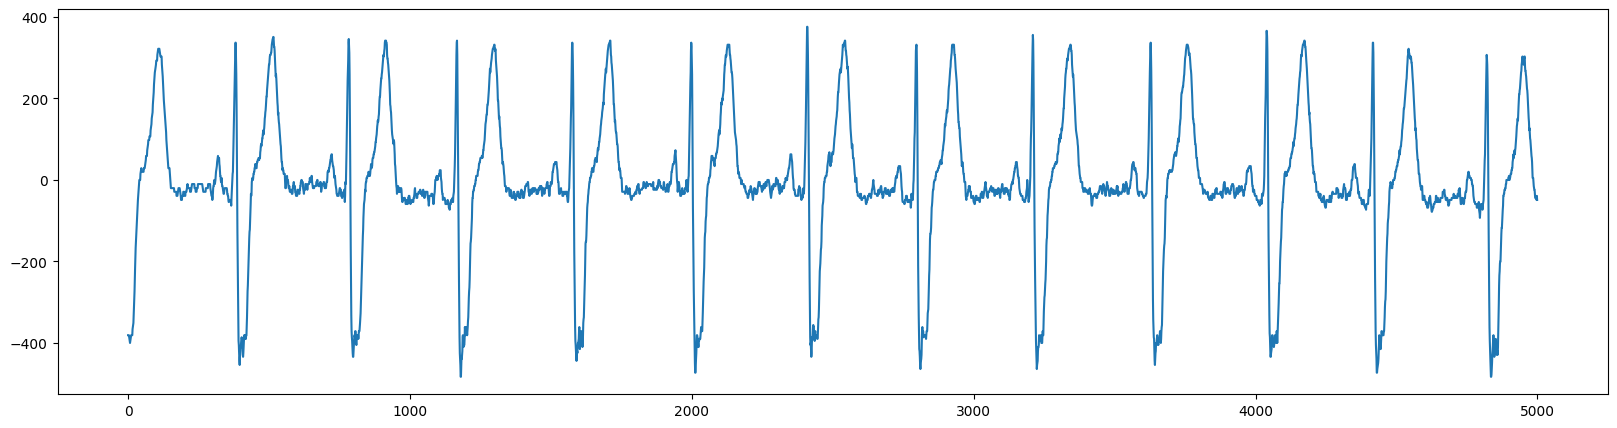

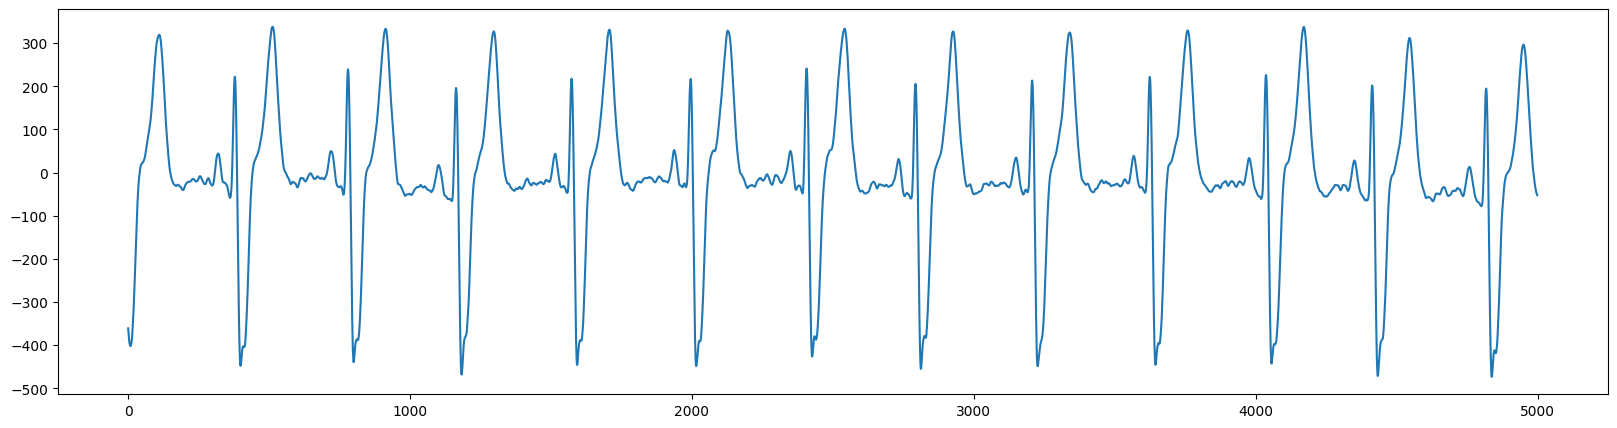

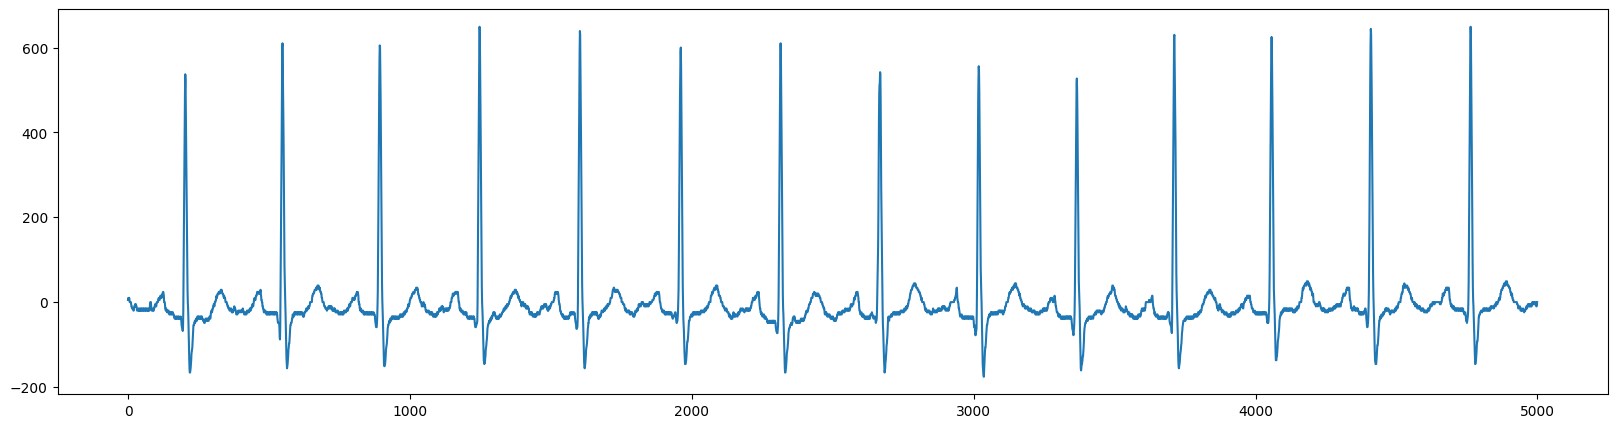

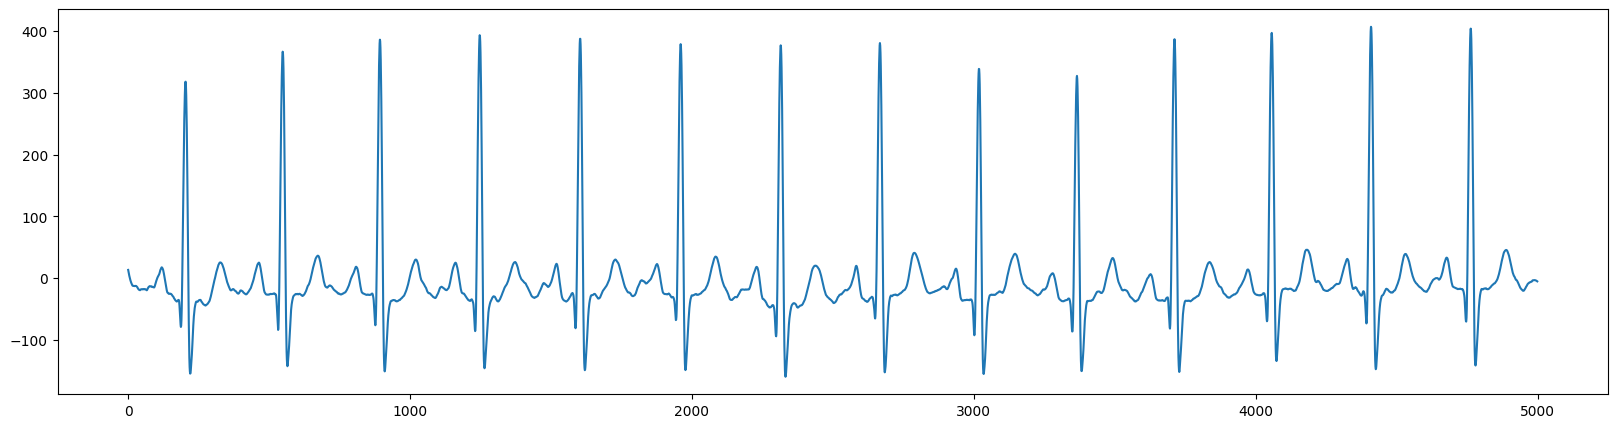

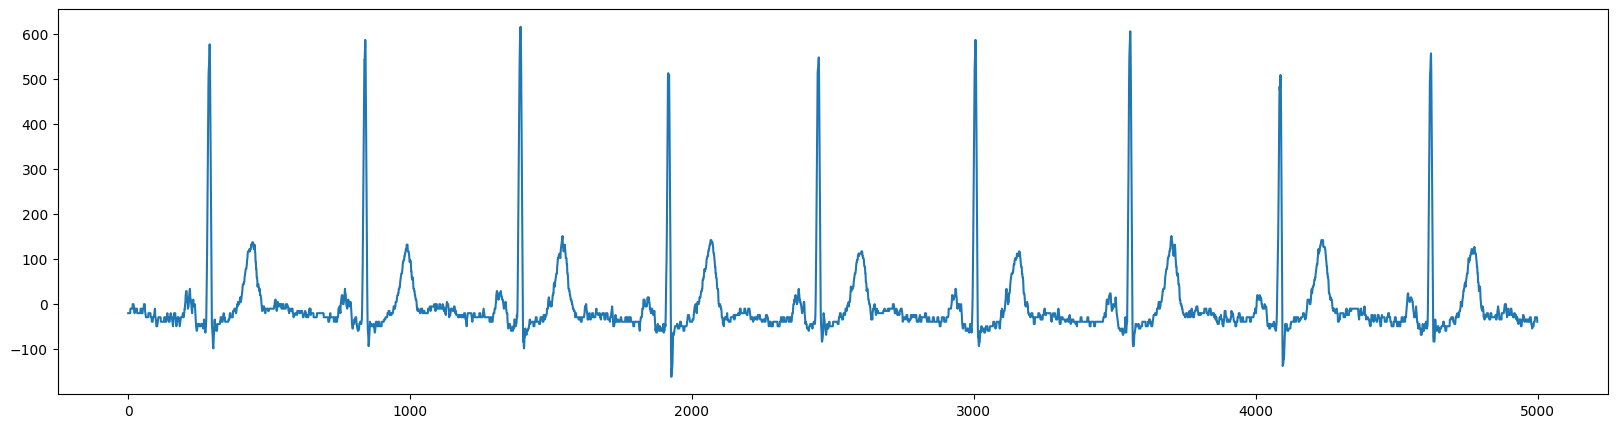

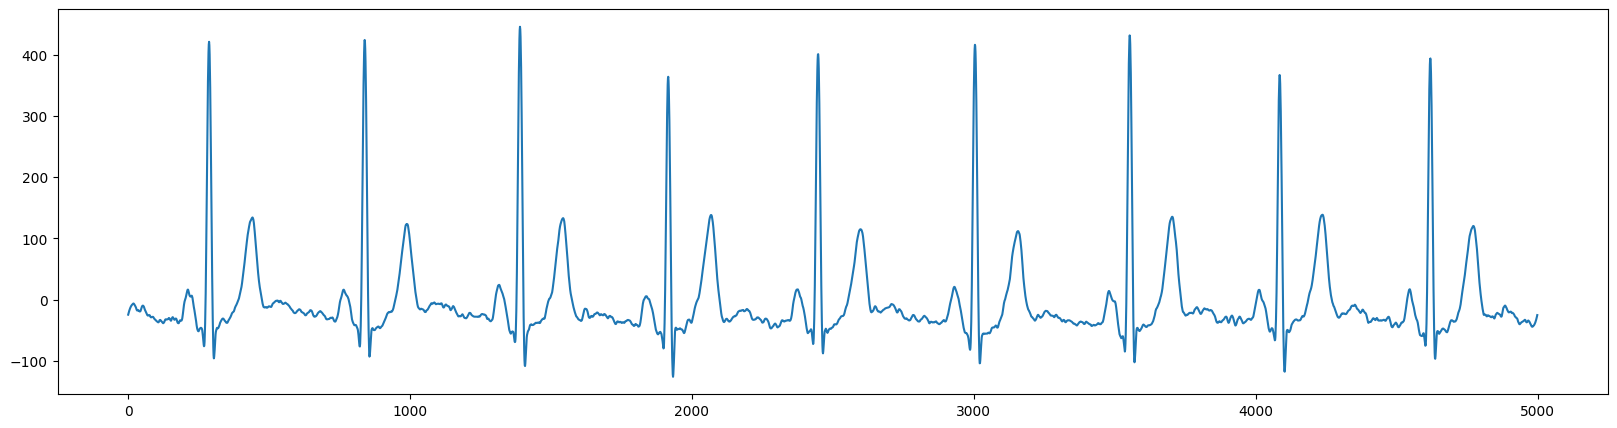

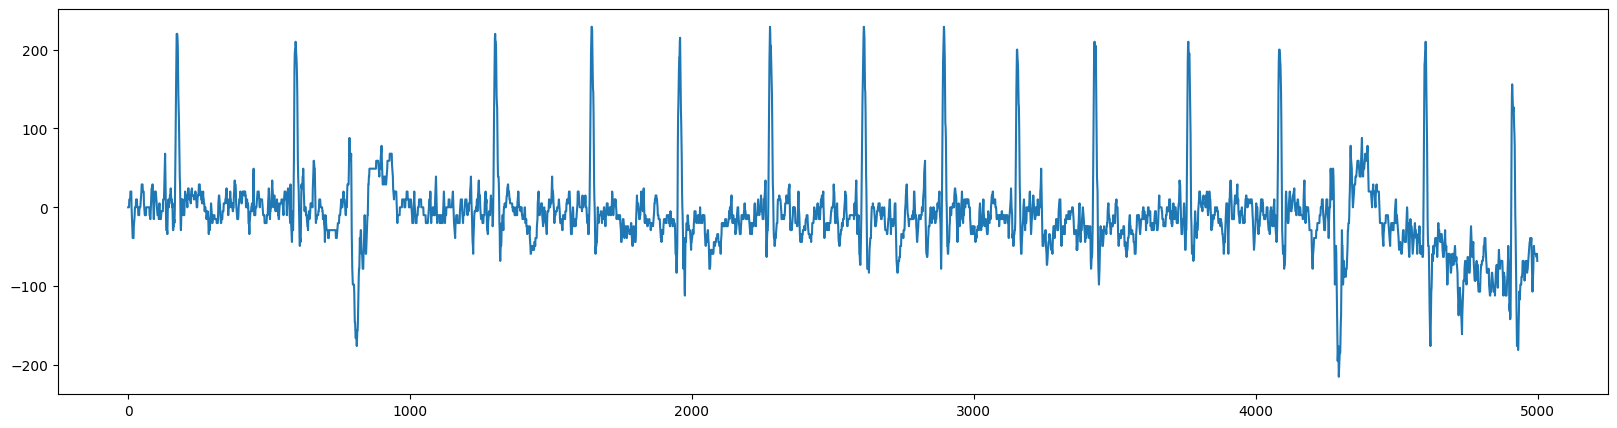

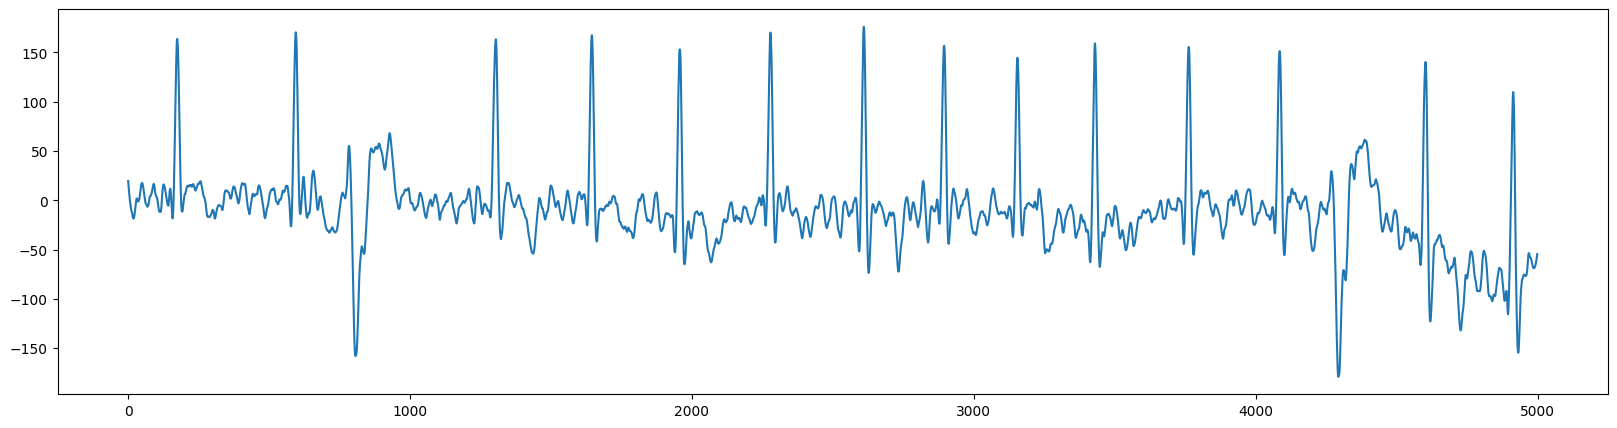

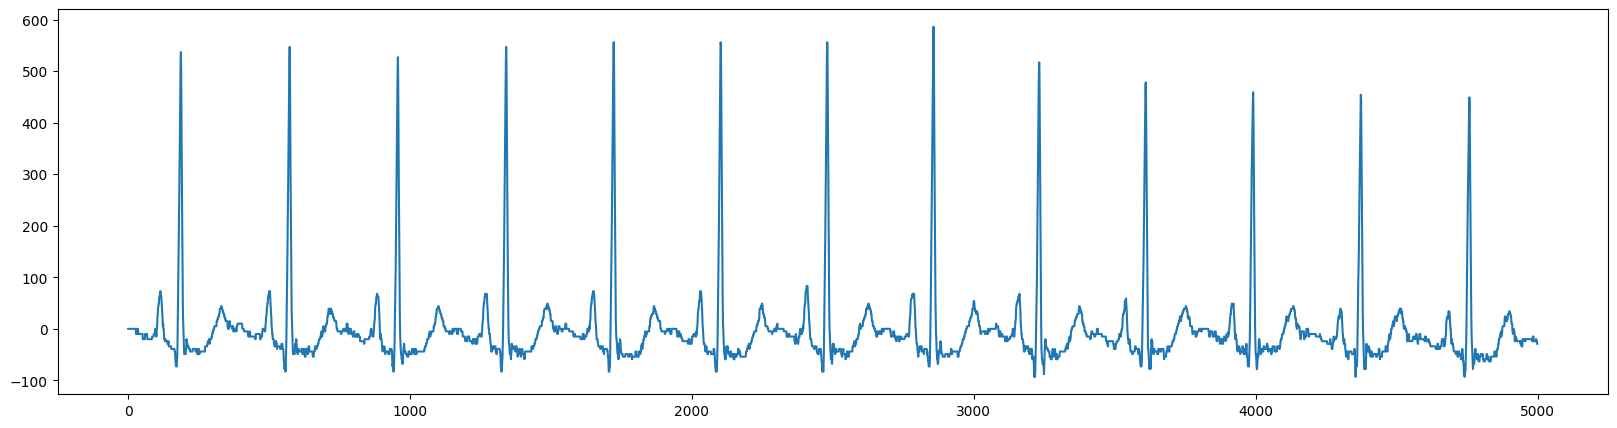

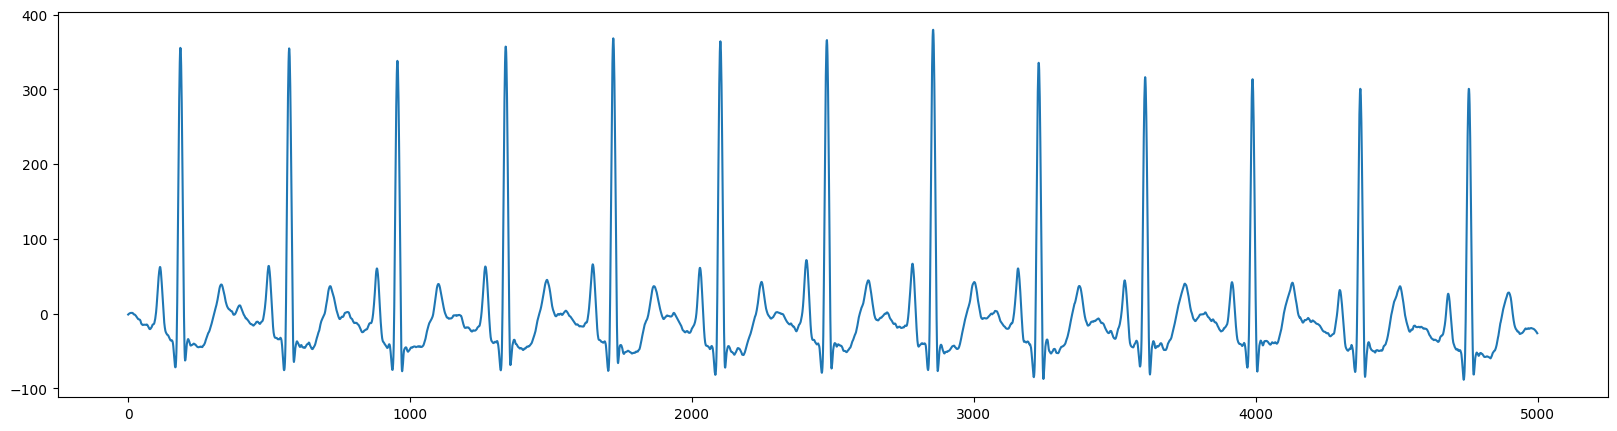

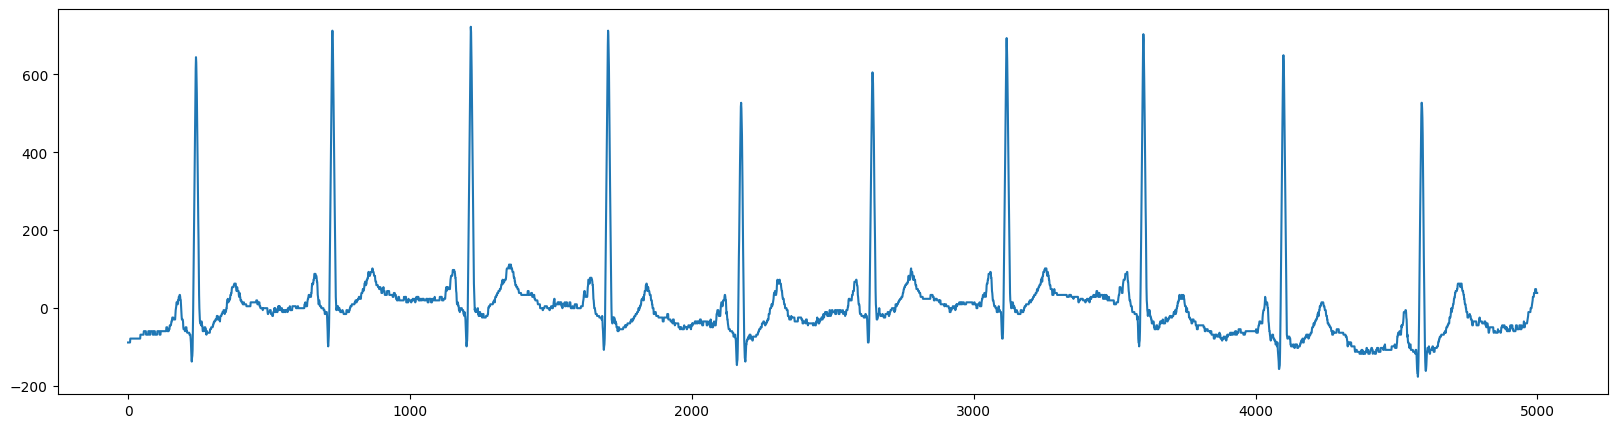

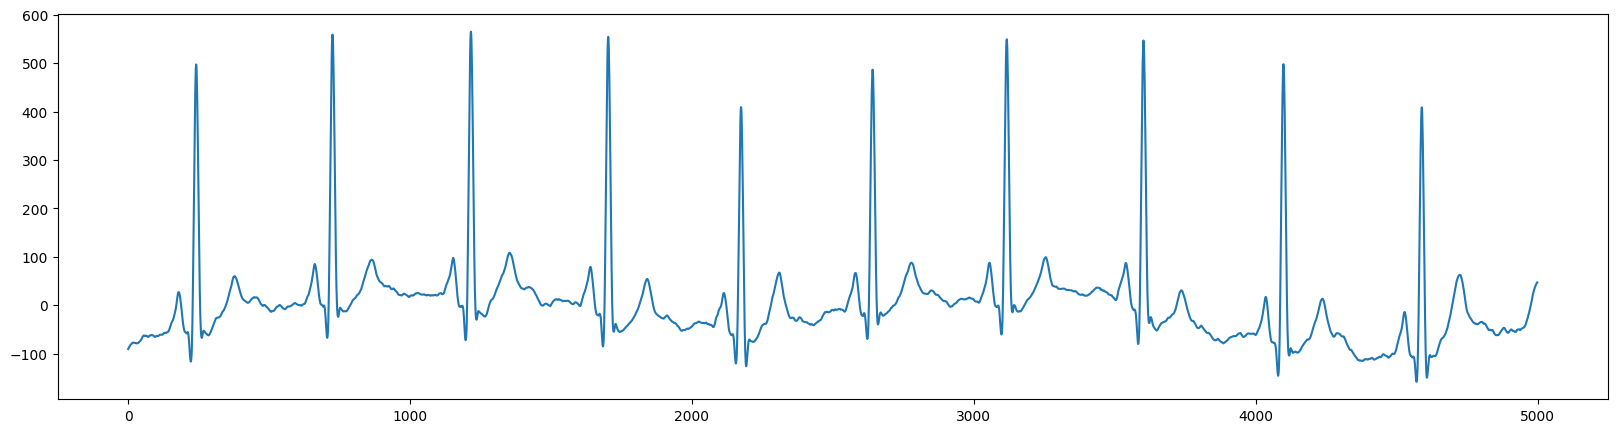

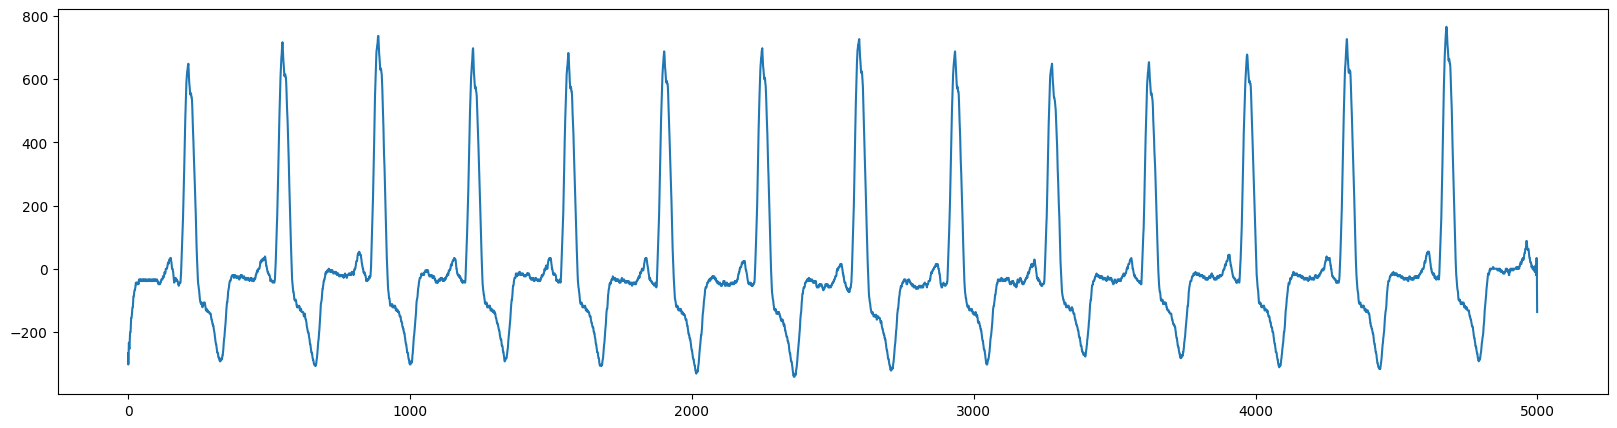

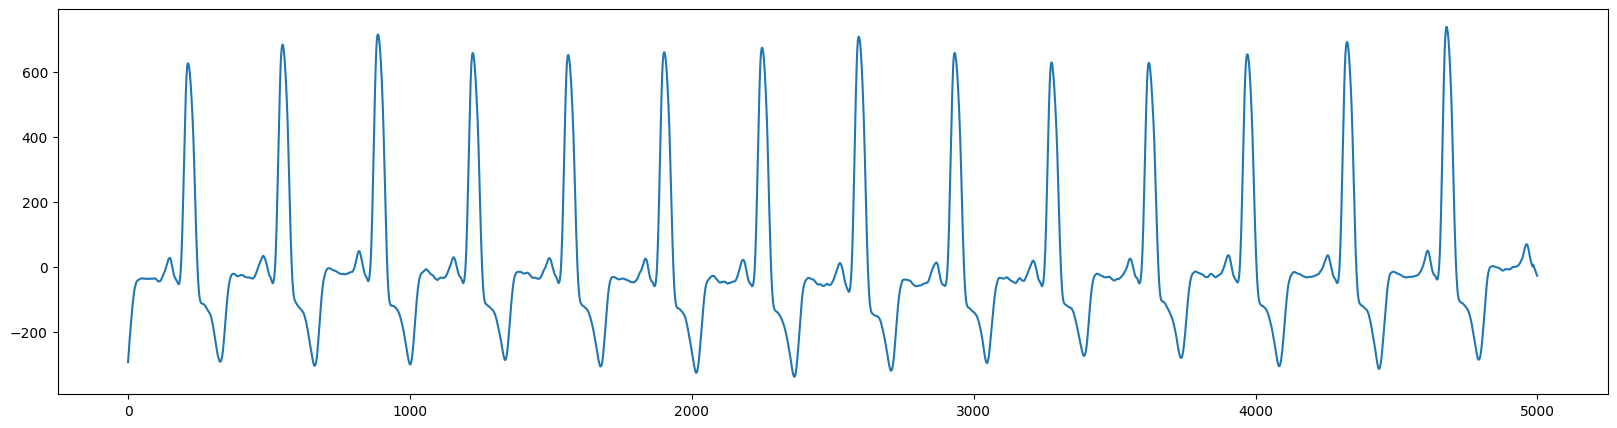

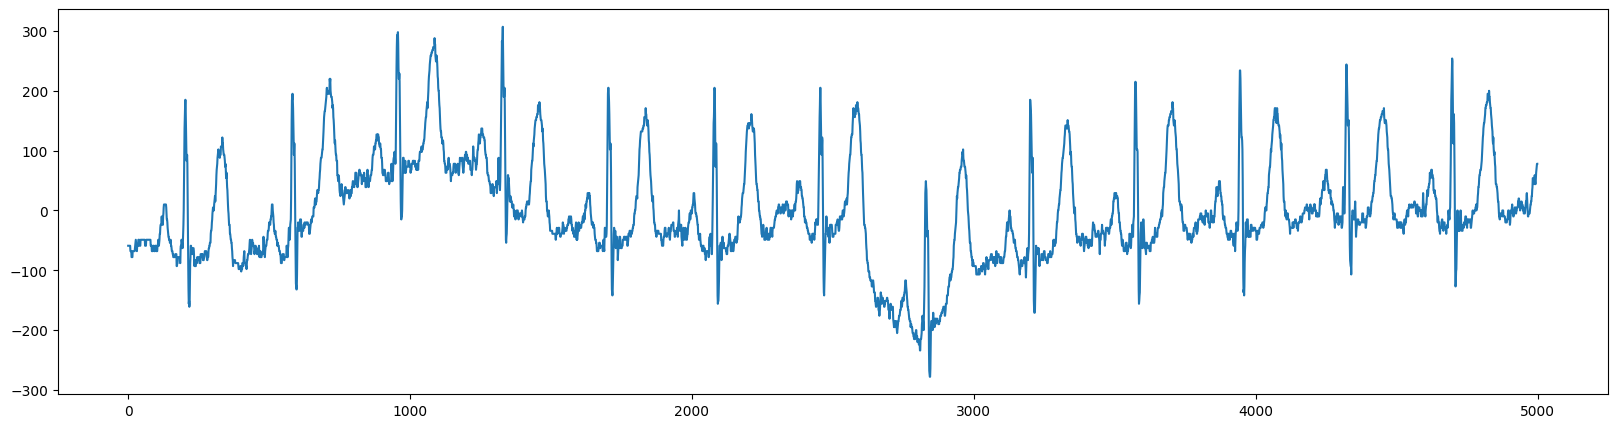

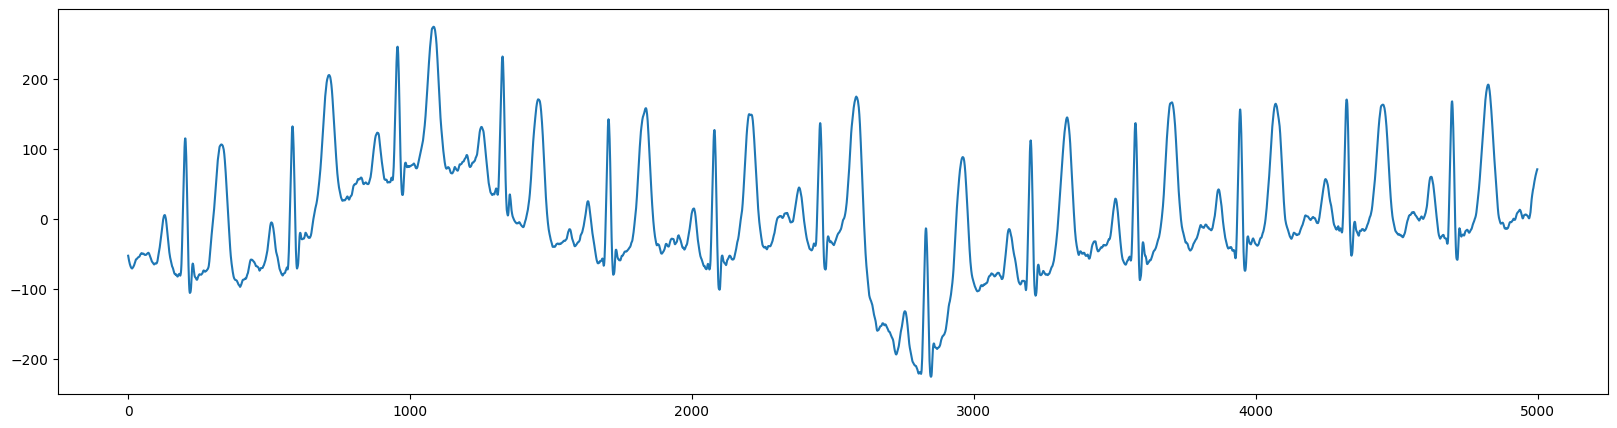

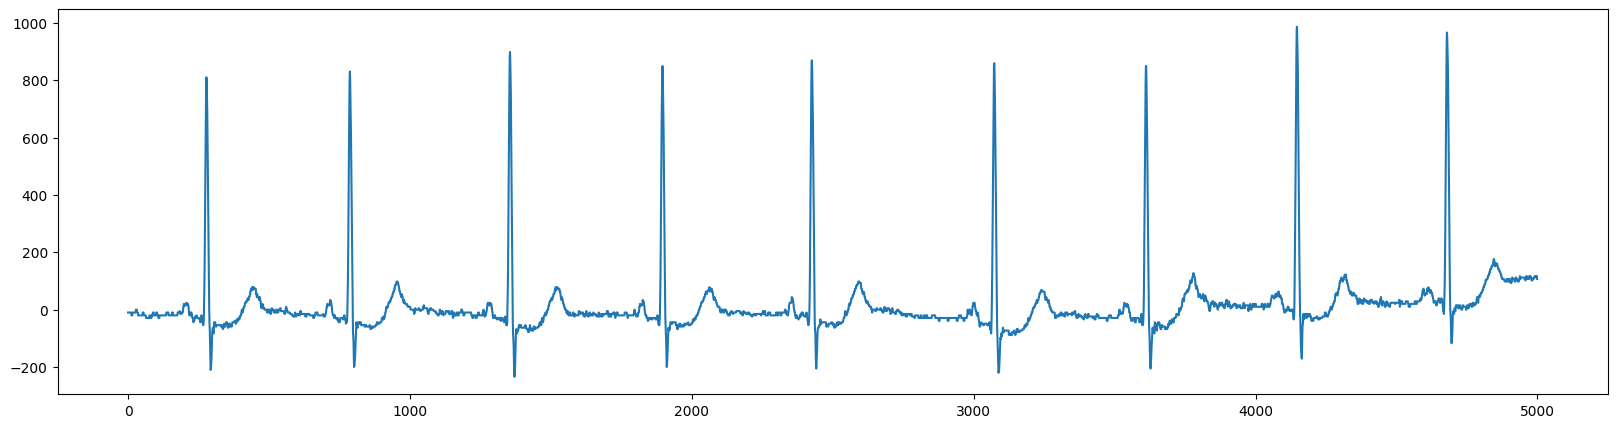

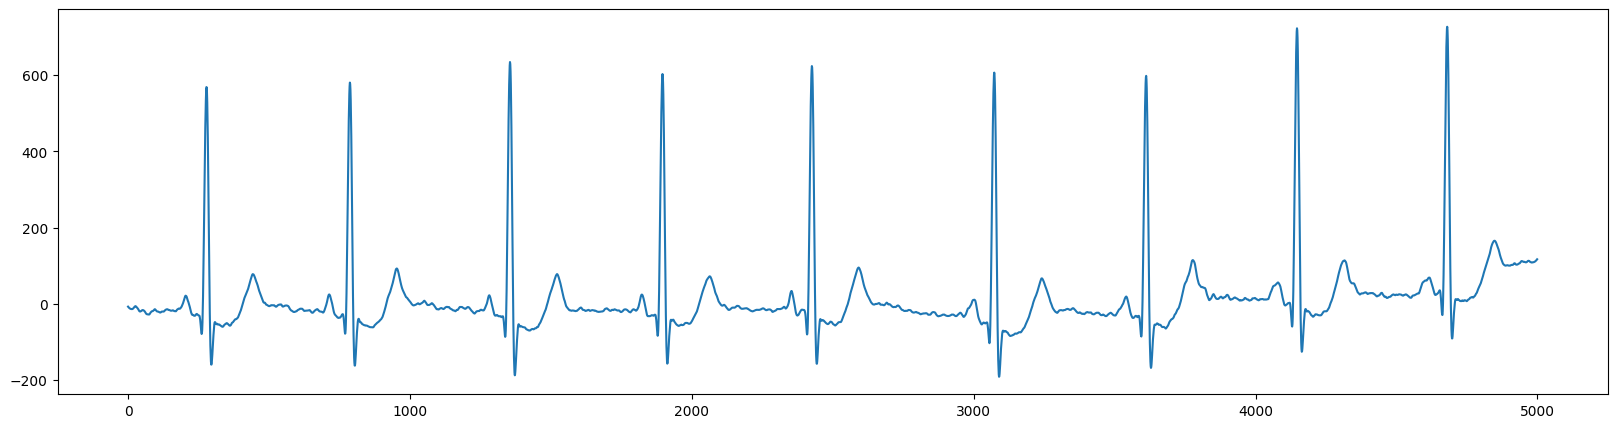

In [ ]:
from scipy.signal import savgol_filter

n = 2

for i in range(20):
  n=i
  plt.figure(figsize=(20,5))
  plt.plot(original.iloc[n, :].values)

  # Load the ECG wave data
  Savitzky_data = original.iloc[n, :].values

  # Smooth the ECG wave using Savitzky-Golay filter
  smoothed_ecg_data = savgol_filter(Savitzky_data, window_length=30, polyorder=2)

  # Plot the smoothed ECG wave
  plt.figure(figsize=(20,5))
  plt.plot(smoothed_ecg_data)
  plt.show()

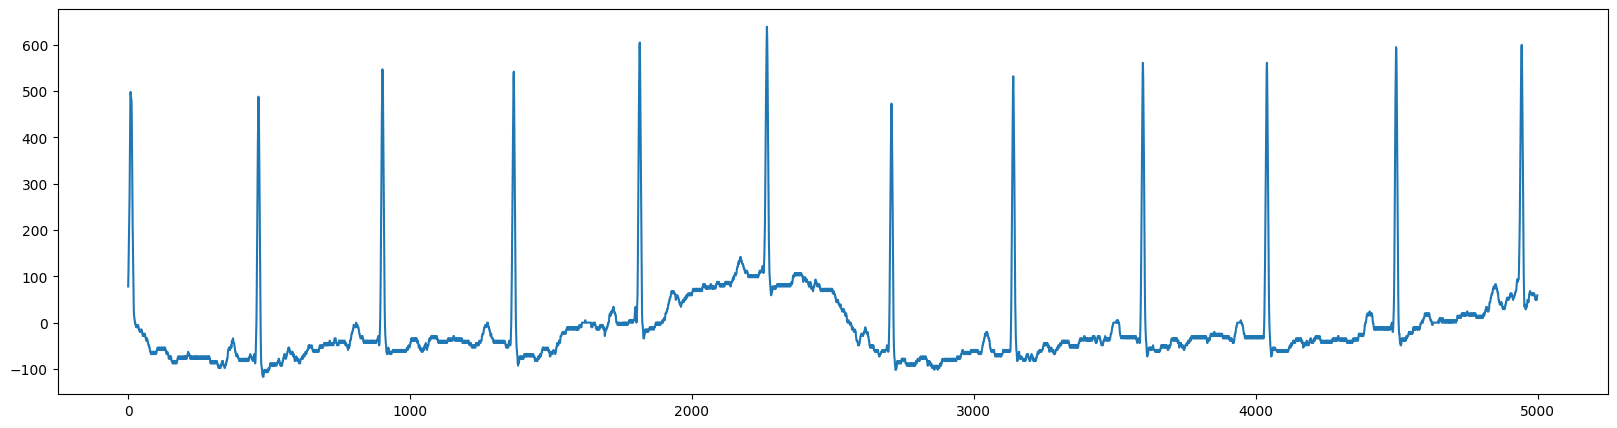

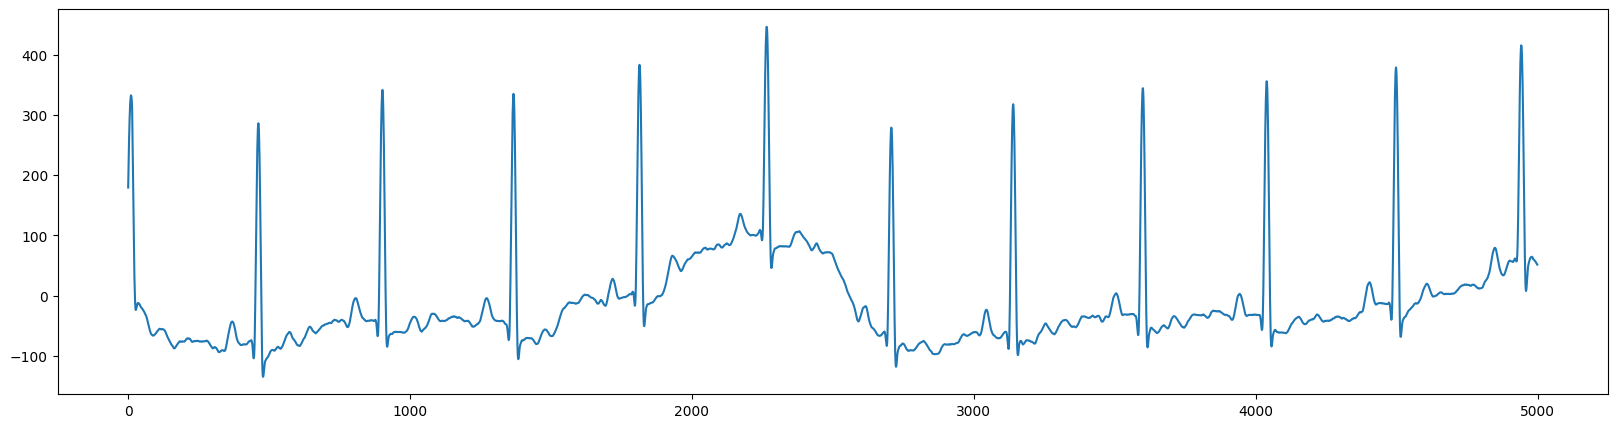

In [ ]:
from scipy.signal import savgol_filter

n = 5
plt.figure(figsize=(20,5))
plt.plot(original.iloc[n, :].values)

# Load the ECG wave data
Savitzky_data = original.iloc[n, :].values

# Smooth the ECG wave using Savitzky-Golay filter
smoothed_ecg_data = savgol_filter(Savitzky_data, window_length=30, polyorder=2)

# Plot the smoothed ECG wave
plt.figure(figsize=(20,5))
plt.plot(smoothed_ecg_data)
plt.show()

In [ ]:
import numpy as np
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt

ecg_signal = smoothed_ecg_data
print(ecg_signal)
# # Process the ECG signal to detect R-peaks using more robust methods
# out = ecg.hamilton_segmenter(ecg_signal)

# # Get the R-peak indices
# r_peak_indices = out['rpeaks']

# # Define a range before and after the R-peak to search for Q-peaks and S-peaks
# search_window = 40

# # Initialize lists for Q-peak and S-peak indices
# q_peak_indices = []
# s_peak_indices = []

# # Detect Q-peaks, R-peaks, and S-peaks
# for r in r_peak_indices:
#     if r - search_window >= 0:
#         q_peak = r - search_window + np.argmin(ecg_signal[r - search_window : r])
#         q_peak_indices.append(q_peak)
#     if r + search_window < len(ecg_signal):
#         s_peak = r + np.argmin(ecg_signal[r : r + search_window])
#         s_peak_indices.append(s_peak)

# # Plot the original ECG signal with detected Q-peaks, R-peaks, and S-peaks
# plt.figure(figsize=(100, 6))
# plt.plot(ecg_signal, label='ECG Signal')
# plt.plot(q_peak_indices, ecg_signal[q_peak_indices], 'bo', label='Detected Q-Peaks')
# plt.plot(r_peak_indices, ecg_signal[r_peak_indices], 'ro', label='Detected R-Peaks')
# plt.plot(s_peak_indices, ecg_signal[s_peak_indices], 'go', label='Detected S-Peaks')
# plt.legend()
# plt.title('ECG Signal with Detected Q-Peaks, R-Peaks, and S-Peaks')
# plt.show()

[179.49395161 208.04536986 233.65573256 ...  53.09889957  52.27504171
  51.42056452]


### PQRST Peaks Detection and Plot

[  66  564 1035 1462 1906 2377 2854 3679 4123 4610]
[48, 546, 1018, 1445, 1888, 2359, 2836, 3662, 4105, 4591]
[83, 582, 1053, 1480, 1924, 2395, 2872, 3697, 4140, 4627]
 :48
[14, 513, 984, 1413, 1855, 2326, 2804, 3628, 4072, 4558]
[211, 709, 1180, 1608, 2056, 2527, 3002, 3825, 4268, 4764]
[399.02834821 426.41651786 318.75133929 291.04709821 351.46071429
 389.97834821 348.64955357 339.00111607 388.95267857 419.71741071]


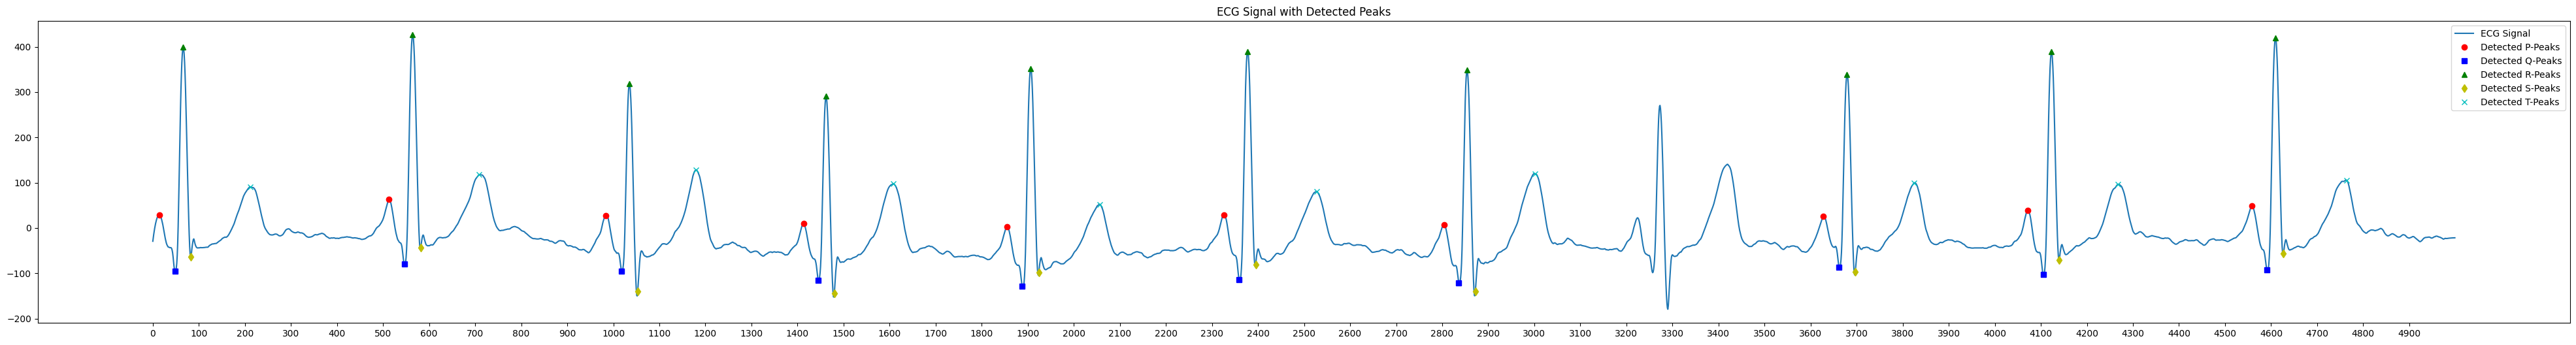

In [ ]:
import biosppy.signals.ecg as ecg

n = 3
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.christov_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']
print(r_peak_indices)
q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    # Search for Q-peak to the left of the R-peak
    q_peak = None
    for i in range(r - 1, 0, -1):
        if smoothed_ecg_data[i] > smoothed_ecg_data[i + 1]:
            q_peak = i
            break

    # Search for S-peak to the right of the R-peak
    s_peak = None
    for i in range(r + 1, len(smoothed_ecg_data)):
        if smoothed_ecg_data[i] > smoothed_ecg_data[i - 1]:
            s_peak = i
            break
    q_peak_indices.append(q_peak)
    s_peak_indices.append(s_peak)
print(q_peak_indices)
print(s_peak_indices)

p_peak_indices = []
t_peak_indices = []
for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        if q_peak_indices[i] - 100 < 0:
            print(f" :{q_peak_indices[i]}")
            seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i]]
            max_amplitude_index = np.argmax(seg_ecg_signal)
            p_peak_indices.append(max_amplitude_index)
        else:
            print(f"{q_peak_indices[i] - 100}:{q_peak_indices[i]}")
            seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i]]
            max_amplitude_index = np.argmax(seg_ecg_signal)
            p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

print(p_peak_indices)
print(t_peak_indices)
print(smoothed_ecg_data[r_peak_indices])

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.xticks(range(0, len(smoothed_ecg_data), 100))  # Set x-axis ticks with a difference of 11
plt.show()


## Derived Features

In [ ]:
from scipy.interpolate import CubicSpline

In [ ]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    normalized_lst = [(x - min_val) / (max_val - min_val) for x in lst]
    return normalized_lst
normalized_ecg = np.array(normalize_list(smoothed_ecg_data))

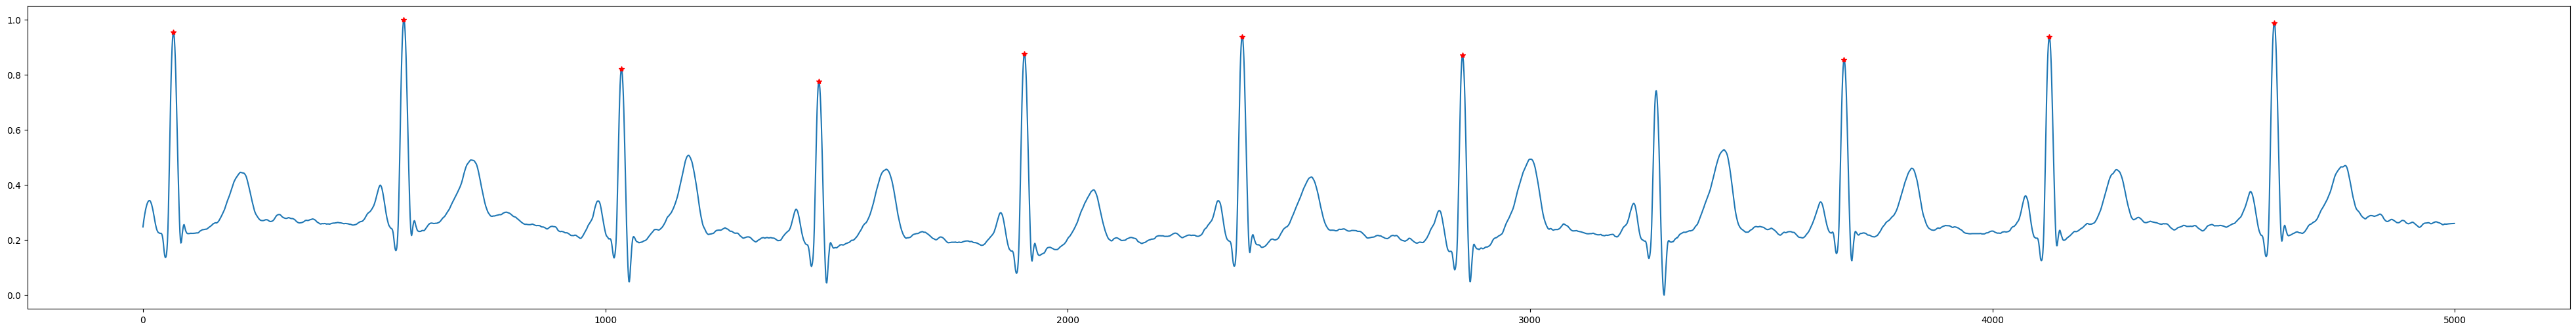

In [ ]:
plt.figure(figsize=(50, 6))
plt.plot(normalized_ecg)
plt.plot(r_peak_indices, normalized_ecg[r_peak_indices], 'r*', label='Detected R-Peaks')

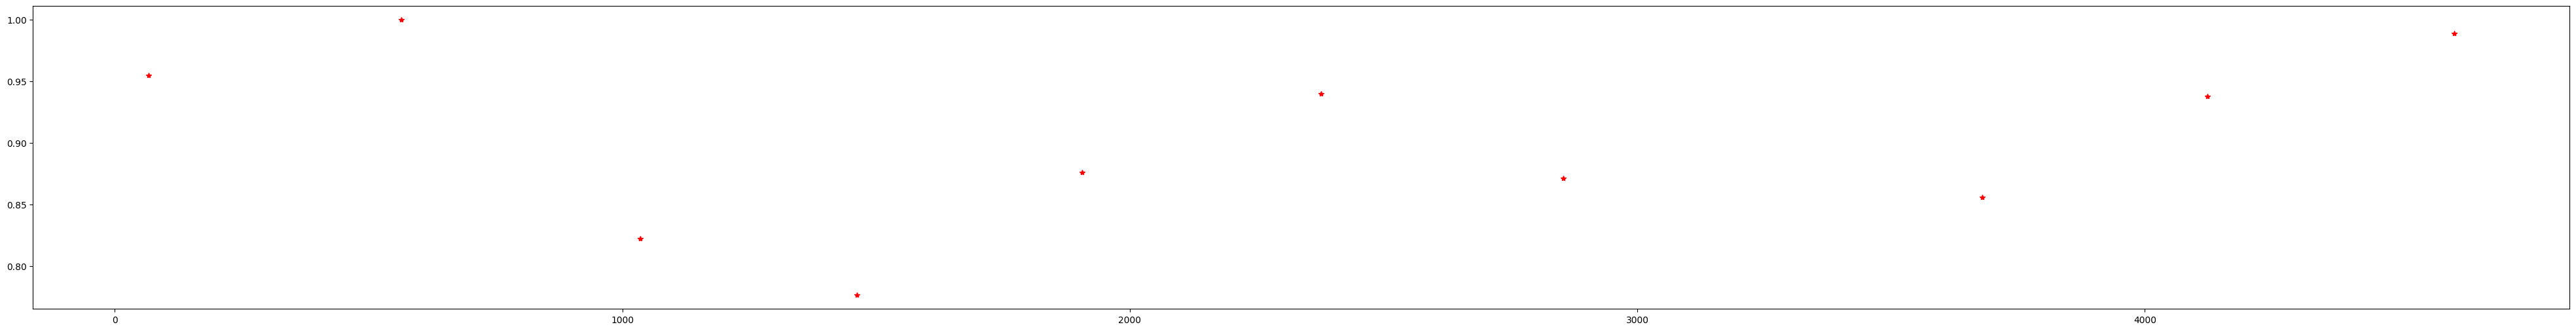

In [ ]:
plt.figure(figsize=(50, 6))
plt.plot(r_peak_indices, normalized_ecg[r_peak_indices], 'r*', label='Detected R-Peaks')

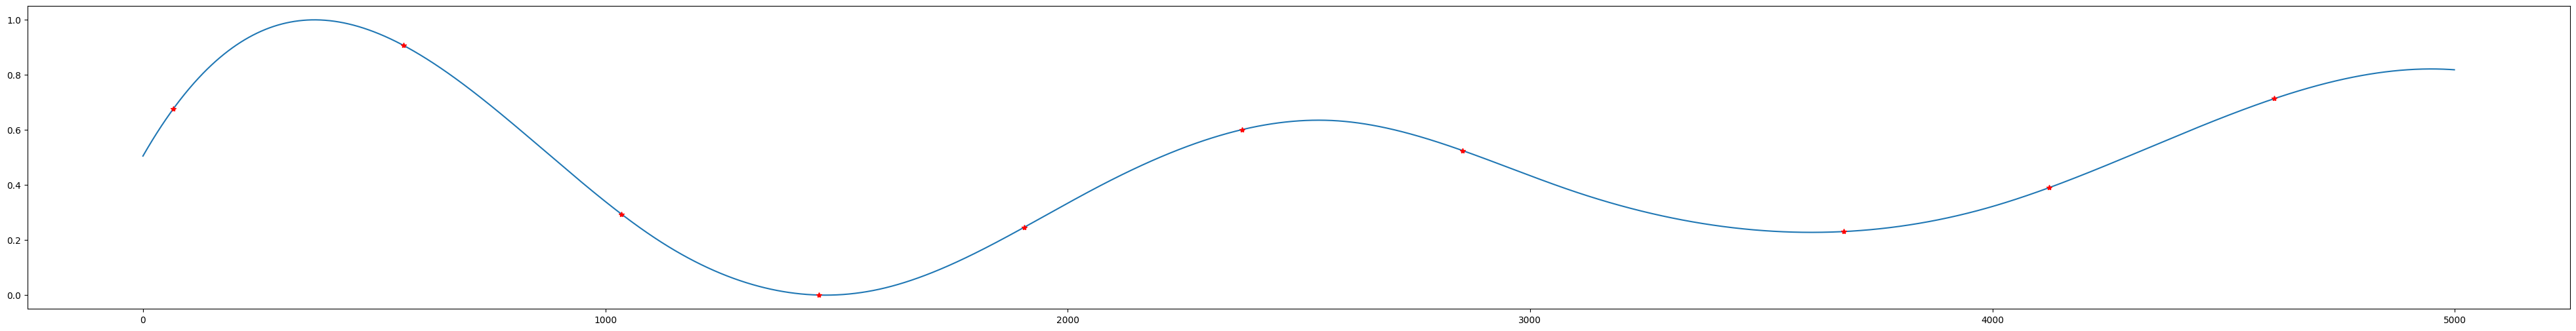

In [ ]:
x = np.array(r_peak_indices)
y = np.array(normalized_ecg[r_peak_indices])
cs = CubicSpline(x, y)

xs = np.linspace(min(x), max(x), 5000)
ys = cs(xs)
ys = np.array(normalize_list(ys))
y = np.array(ys[r_peak_indices])

plt.figure(figsize=(50, 6))
plt.plot(ys)
plt.plot(r_peak_indices, ys[r_peak_indices], 'r*', label='Detected R-Peaks')

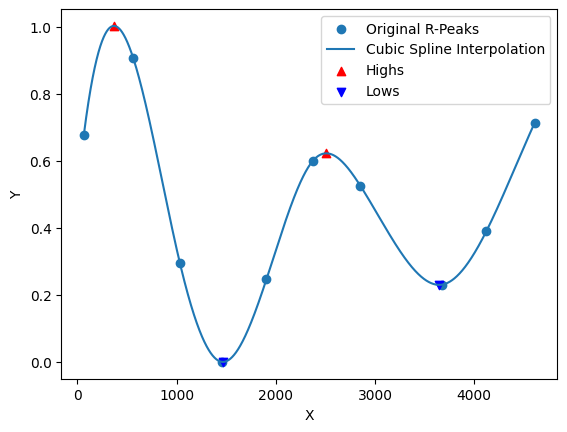

Highs: [368.6909381876375, 2508.4340868173635]
Lows: [1467.6499299859972, 3647.388277655531]


In [ ]:
cs = CubicSpline(x, y)

xs = np.linspace(min(x), max(x), 5000)
ys = cs(xs)

# Compute the first derivative of the cubic spline function
derivative_1 = cs.derivative()

# Generate points on the derivative curve
deriv_xs = np.linspace(min(x), max(x), 5000)
deriv_ys = derivative_1(deriv_xs)

# Find indices where the derivative changes sign
sign_changes = np.where(np.diff(np.sign(deriv_ys)))[0]

# Identify highs and lows based on the sign changes
highs = [deriv_xs[i] for i in sign_changes if deriv_ys[i] > 0]
lows = [deriv_xs[i] for i in sign_changes if deriv_ys[i] < 0]

# Plot the original points, cubic spline interpolation, and highs/lows
plt.scatter(x, y, label='Original R-Peaks')
plt.plot(xs, ys, label='Cubic Spline Interpolation')
plt.scatter(highs, cs(highs), c='red', marker='^', label='Highs')
plt.scatter(lows, cs(lows), c='blue', marker='v', label='Lows')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print the identified highs and lows
print("Highs:", highs)
print("Lows:", lows)

## Implementation of EDR time ratio (TR)

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline

x = np.array(r_peak_indices)
y = np.array(normalized_ecg[r_peak_indices])
cs = CubicSpline(x, y)

xs = np.linspace(min(x), max(x), 5000)
ys = cs(xs)
ys = np.array(normalize_list(ys))
y = np.array(ys[r_peak_indices])

cs = CubicSpline(x, y)

derivative_1 = cs.derivative()

deriv_xs = np.linspace(min(x), max(x), 1000)
deriv_ys = derivative_1(deriv_xs)

sign_changes = np.where(np.diff(np.sign(deriv_ys)))[0]

highs = [i for i in sign_changes if deriv_ys[i] < 0]
lows = [i for i in sign_changes if deriv_ys[i] > 0]

comp_lis = highs + lows
st = sorted(comp_lis)

TR = []
for i in range(len(st)):
  try:
    if st[i] in lows and st[i+1] in highs and st[i+2] in lows:
      tr = (st[i+2] - st[i+1])/(st[i+1] - st[i])
      TR.append(tr)
  except Exception as e:
    continue
tr = sum(TR)/len(TR)
tr

0.9469387755102041

## Implementation of EDR Energy Ratio (ER)

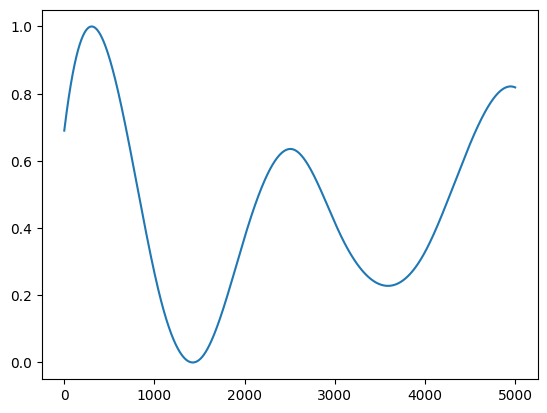

In [ ]:
plt.plot(ys)

In [ ]:

edr = np.trapz(ys**2)
edr

NameError: ignored

## Finding R-Peaks on all data

### Hamilton Segmenter

In [ ]:
import biosppy.signals.ecg as ecg


rpeaks_less_10 = []
rpeaks_less_5 = []
no_rpeaks = []
total_rpeaks = []

for l in range(12):
  X_ecg = ecg_X[:, l, :]
  original = pd.DataFrame(X_ecg)

  for i in range(len(original)):
    savitzky_data = original.iloc[i, :].values
    smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
    out = ecg.hamilton_segmenter(smoothed_ecg_data)

    r_peak_indices = out['rpeaks']
    r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

    # Filter R-peaks with positive amplitudes
    positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

    if len(positive_r_peak_indices) < 10:
      rpeaks_less_10.append(i)
    if len(positive_r_peak_indices) < 5:
      rpeaks_less_5.append(i)
    if len(positive_r_peak_indices) == 0:
      no_rpeaks.append(i)
    total_rpeaks.append(len(positive_r_peak_indices))

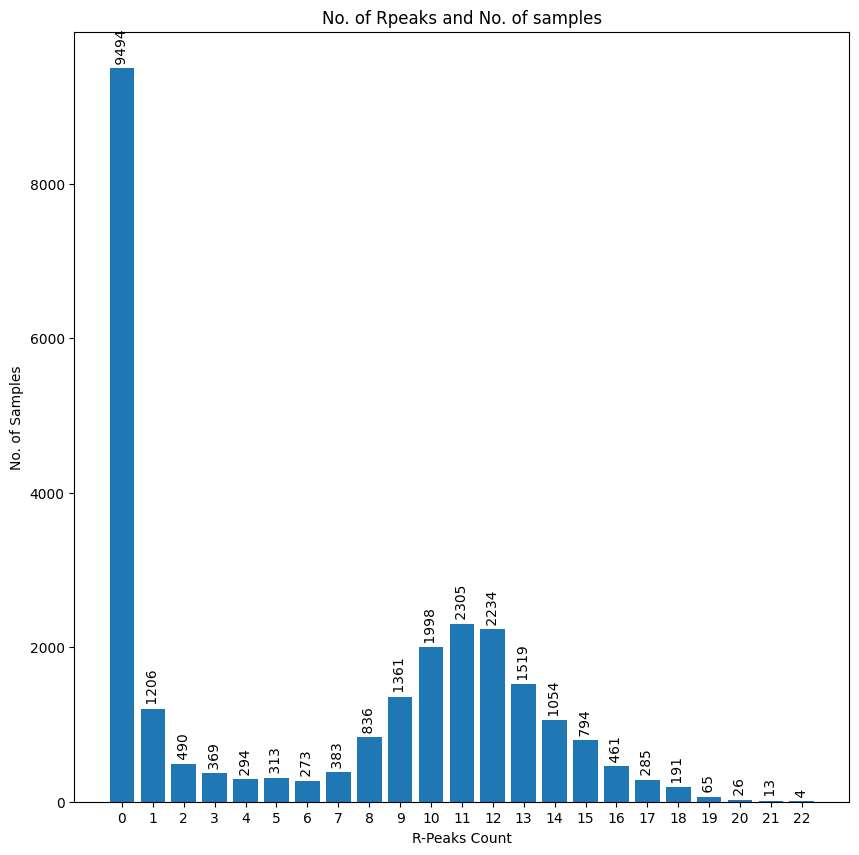

In [ ]:
unique, counts = np.unique(total_rpeaks, return_counts=True)
plt.figure(figsize=(10,10))
plt.bar(unique, counts)

# Add labels and a title
plt.xticks(unique)
plt.xlabel('R-Peaks Count')
plt.ylabel('No. of Samples')
plt.title('No. of Rpeaks and No. of samples')

for i, count in enumerate(counts):
    plt.text(unique[i], count, f" {str(count)}", ha='center', va='bottom', rotation=90)

# Show the plot
plt.show()

### Christov Segmentation

In [ ]:
import biosppy.signals.ecg as ecg


rpeaks_less_10 = []
rpeaks_less_5 = []
no_rpeaks = []
total_rpeaks = []

for l in range(12):
  X_ecg = ecg_X[:, l, :]
  original = pd.DataFrame(X_ecg)
  for i in range(len(original)):
    savitzky_data = original.iloc[i, :].values
    smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
    out = ecg.christov_segmenter(smoothed_ecg_data)

    r_peak_indices = out['rpeaks']
    r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

    # Filter R-peaks with positive amplitudes
    positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

    if len(positive_r_peak_indices) < 10:
      rpeaks_less_10.append(i)
    if len(positive_r_peak_indices) < 5:
      rpeaks_less_5.append(i)
    if len(positive_r_peak_indices) == 0:
      no_rpeaks.append(i)
    total_rpeaks.append(len(positive_r_peak_indices))
    print(i)

In [ ]:
len(no_rpeaks), len(rpeaks_less_5), len(rpeaks_less_10)

(2, 1629, 6212)

In [ ]:
unique, counts = np.unique(total_rpeaks, return_counts=True)
unique, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([   2,  967,  266,  190,  204,  179,  245,  441, 1317, 2401, 3739,
        4192, 4117, 3004, 2195, 1549,  787,  171,    2]))

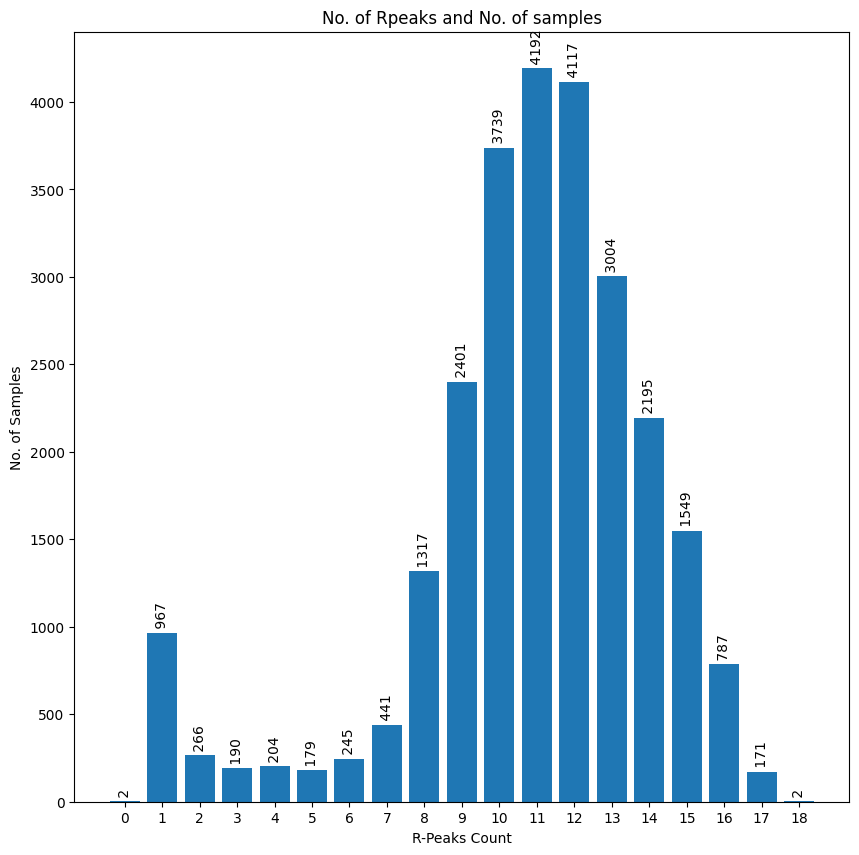

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(unique, counts)

# Add labels and a title
plt.xticks(unique)
plt.xlabel('R-Peaks Count')
plt.ylabel('No. of Samples')
plt.title('No. of Rpeaks and No. of samples')

for i, count in enumerate(counts):
    plt.text(unique[i], count, f" {str(count)}", ha='center', va='bottom', rotation=90)

# Show the plot
plt.show()

### Gamboa Segmenter

In [ ]:
import biosppy.signals.ecg as ecg


rpeaks_less_10 = []
rpeaks_less_5 = []
no_rpeaks = []
total_rpeaks = []

for l in range(12):
  X_ecg = ecg_X[:, l, :]
  original = pd.DataFrame(X_ecg)

  for i in range(len(original)):
    print(i)
    try:
      savitzky_data = original.iloc[i, :].values
      smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
      out = ecg.gamboa_segmenter(smoothed_ecg_data)

      r_peak_indices = out['rpeaks']
      r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

      # Filter R-peaks with positive amplitudes
      positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

      if len(positive_r_peak_indices) < 10:
        rpeaks_less_10.append(i)
      if len(positive_r_peak_indices) < 5:
        rpeaks_less_5.append(i)
      if len(positive_r_peak_indices) == 0:
        no_rpeaks.append(i)
      total_rpeaks.append(len(positive_r_peak_indices))
    except Exception as E:
      print(E)

Streaming output truncated to the last 5000 lines.
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682

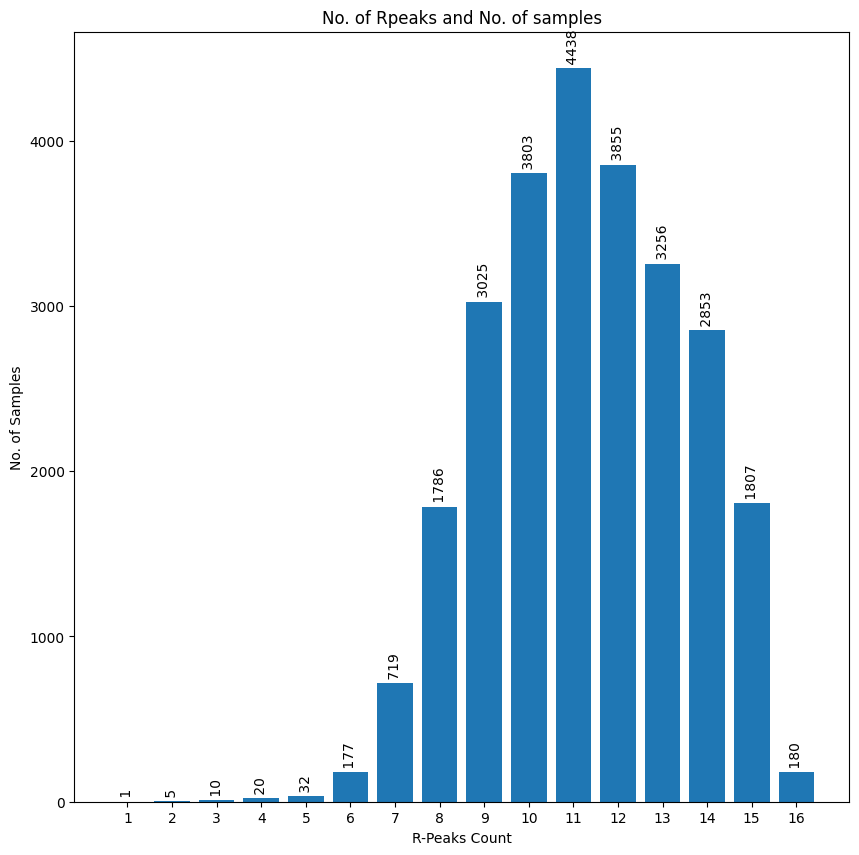

In [ ]:
unique, counts = np.unique(total_rpeaks, return_counts=True)
plt.figure(figsize=(10,10))
plt.bar(unique, counts)

# Add labels and a title
plt.xticks(unique)
plt.xlabel('R-Peaks Count')
plt.ylabel('No. of Samples')
plt.title('No. of Rpeaks and No. of samples')

for i, count in enumerate(counts):
    plt.text(unique[i], count, f" {str(count)}", ha='center', va='bottom', rotation=90)

# Show the plot
plt.show()

### SSF Segmenter

In [ ]:
import biosppy.signals.ecg as ecg


rpeaks_less_10 = []
rpeaks_less_5 = []
no_rpeaks = []
total_rpeaks = []

for l in range(12):
  X_ecg = ecg_X[:, l, :]
  original = pd.DataFrame(X_ecg)

  for i in range(len(original)):
    print(i)
    savitzky_data = original.iloc[i, :].values
    smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
    out = ecg.ssf_segmenter(smoothed_ecg_data)

    r_peak_indices = out['rpeaks']
    r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

    # Filter R-peaks with positive amplitudes
    positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

    if len(positive_r_peak_indices) < 10:
      rpeaks_less_10.append(i)
    if len(positive_r_peak_indices) < 5:
      rpeaks_less_5.append(i)
    if len(positive_r_peak_indices) == 0:
      no_rpeaks.append(i)
    total_rpeaks.append(len(positive_r_peak_indices))

Streaming output truncated to the last 5000 lines.
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681

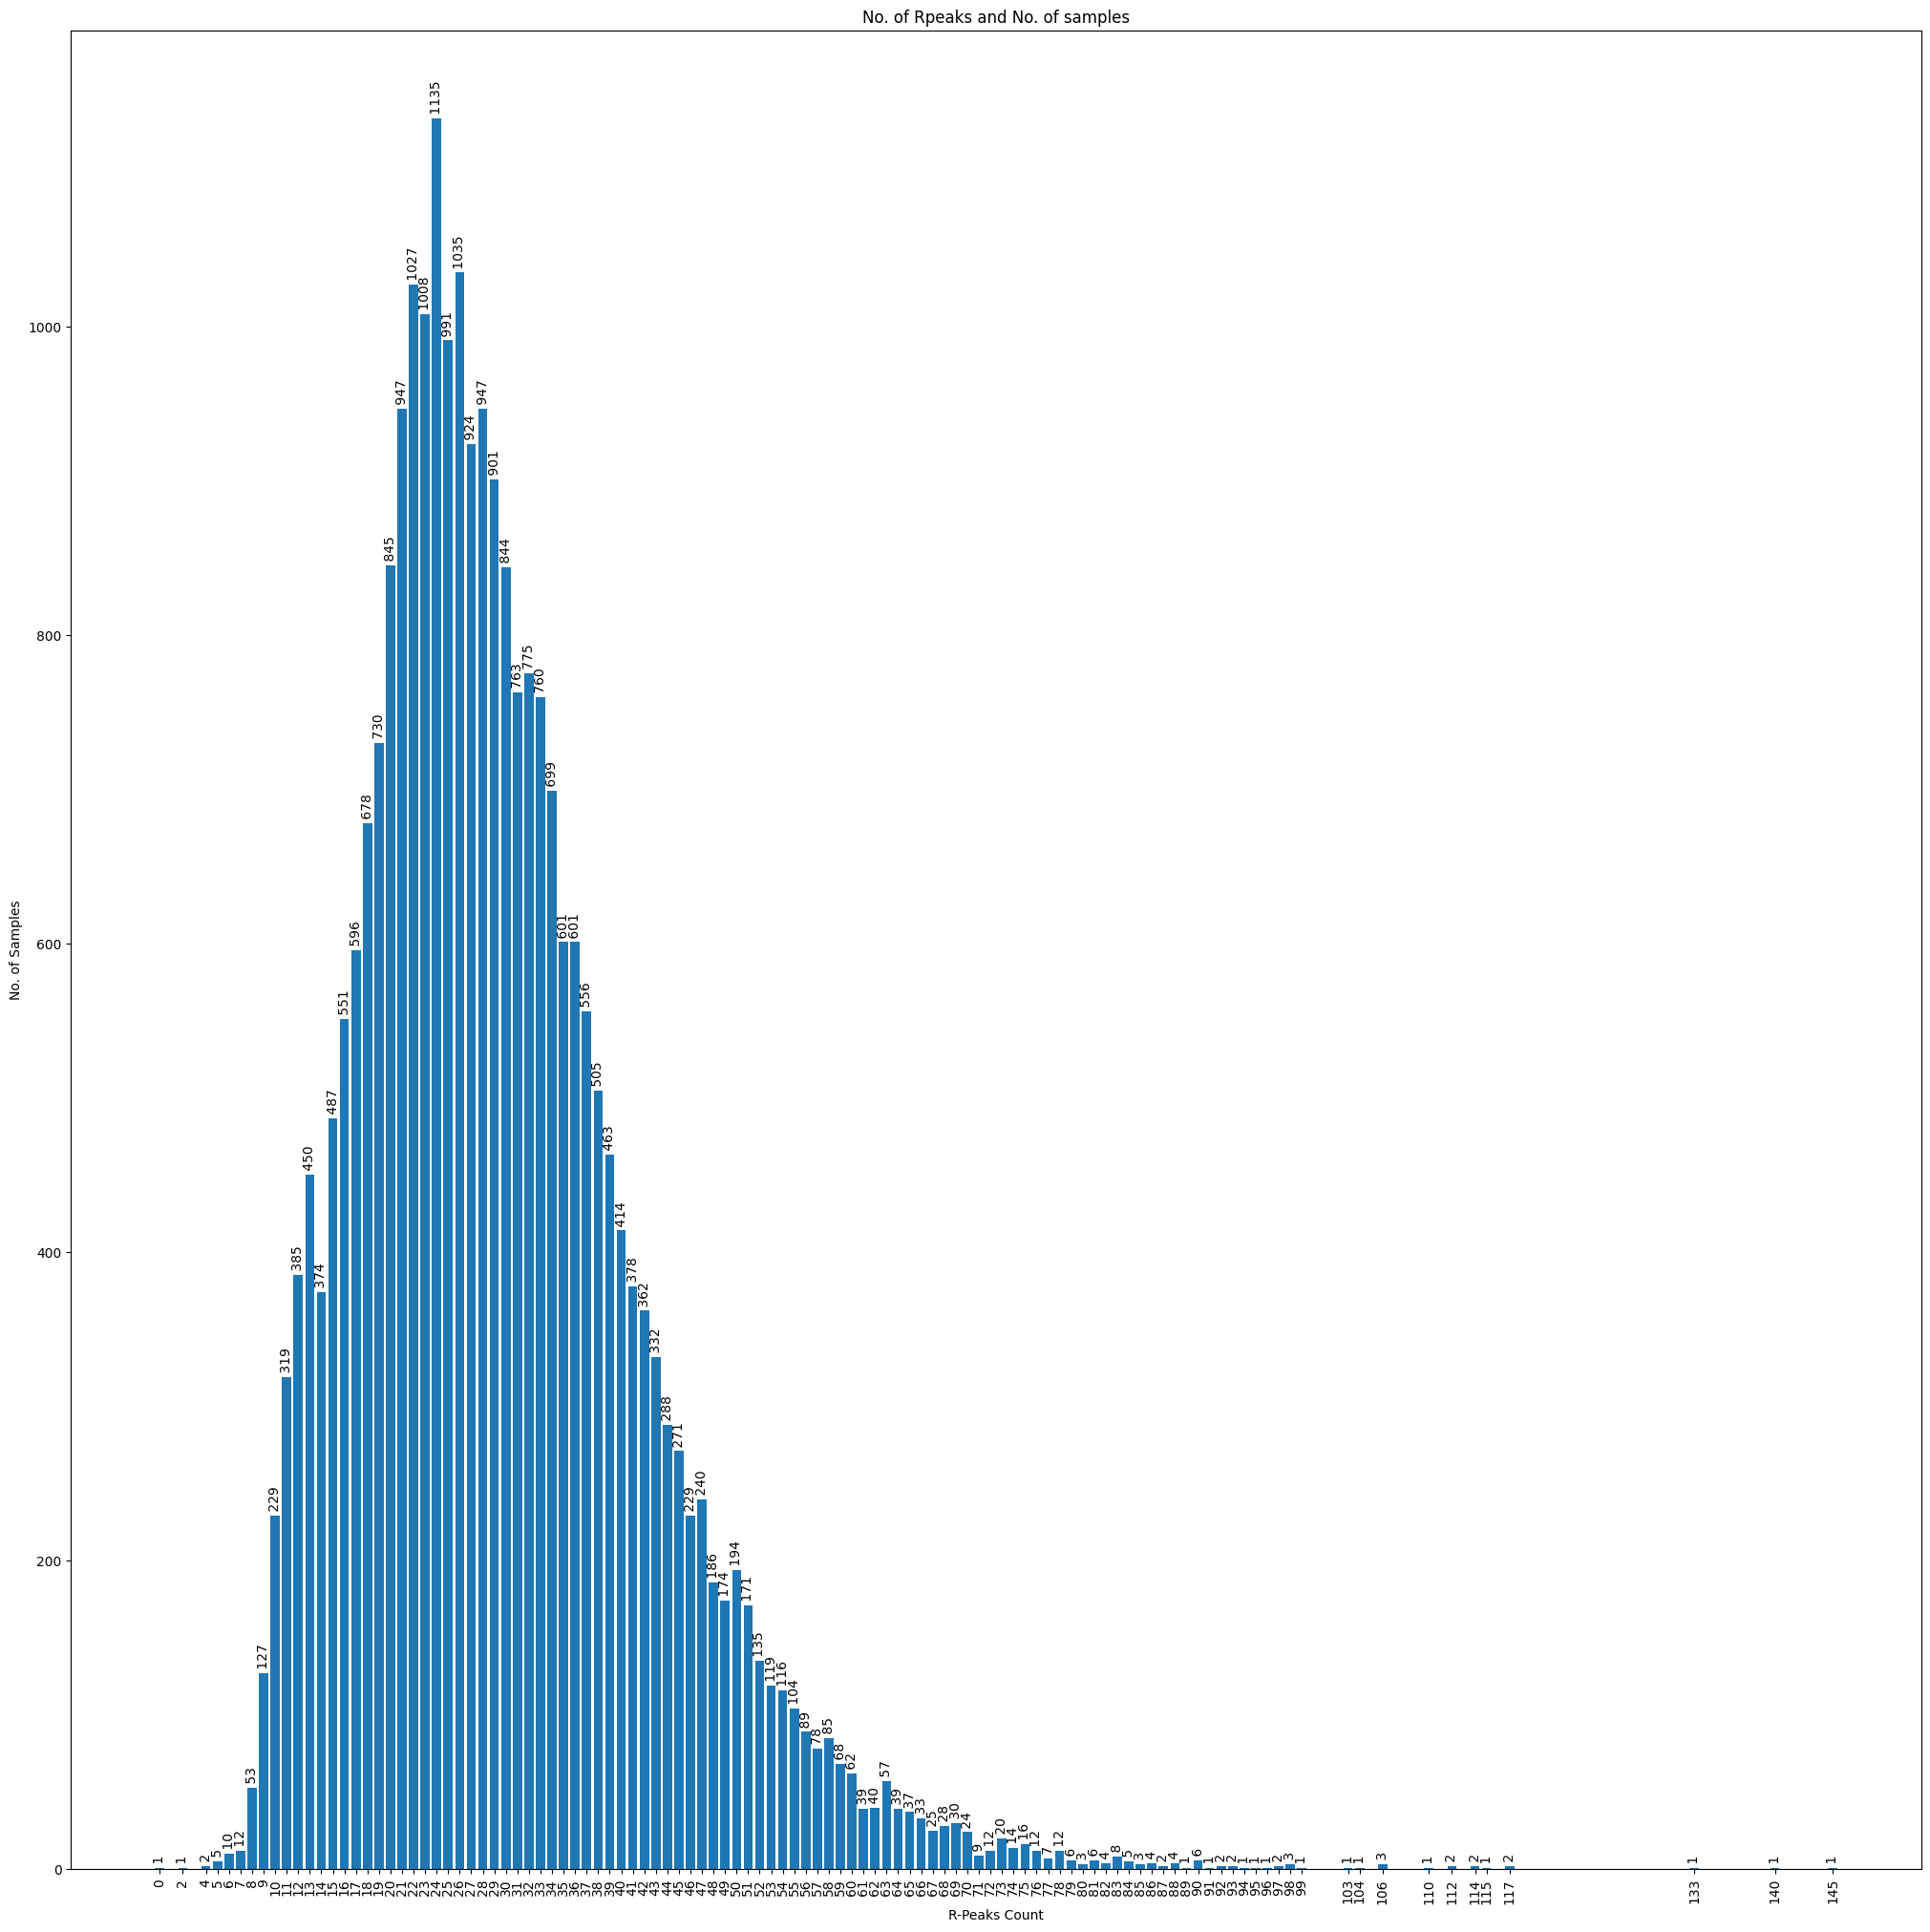

In [ ]:
unique, counts = np.unique(total_rpeaks, return_counts=True)
plt.figure(figsize=(25,25))
plt.bar(unique, counts)

# Add labels and a title
plt.xticks(unique)
plt.xlabel('R-Peaks Count')
plt.ylabel('No. of Samples')
plt.title('No. of Rpeaks and No. of samples')

for i, count in enumerate(counts):
    plt.text(unique[i], count, f" {str(count)}", ha='center', va='bottom', rotation=90)

plt.xticks(rotation=90)
# Show the plot
plt.show()

### Engzee Segmenter

In [ ]:
import biosppy.signals.ecg as ecg


rpeaks_less_10 = []
rpeaks_less_5 = []
no_rpeaks = []
total_rpeaks = []

for l in range(12):
  X_ecg = ecg_X[:, l, :]
  original = pd.DataFrame(X_ecg)

  for i in range(len(original)):
    print(i)
    savitzky_data = original.iloc[i, :].values
    smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
    out = ecg.engzee_segmenter(smoothed_ecg_data)

    r_peak_indices = out['rpeaks']
    r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

    # Filter R-peaks with positive amplitudes
    positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

    if len(positive_r_peak_indices) < 10:
      rpeaks_less_10.append(i)
    if len(positive_r_peak_indices) < 5:
      rpeaks_less_5.append(i)
    if len(positive_r_peak_indices) == 0:
      no_rpeaks.append(i)
    total_rpeaks.append(len(positive_r_peak_indices))

Streaming output truncated to the last 5000 lines.
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681

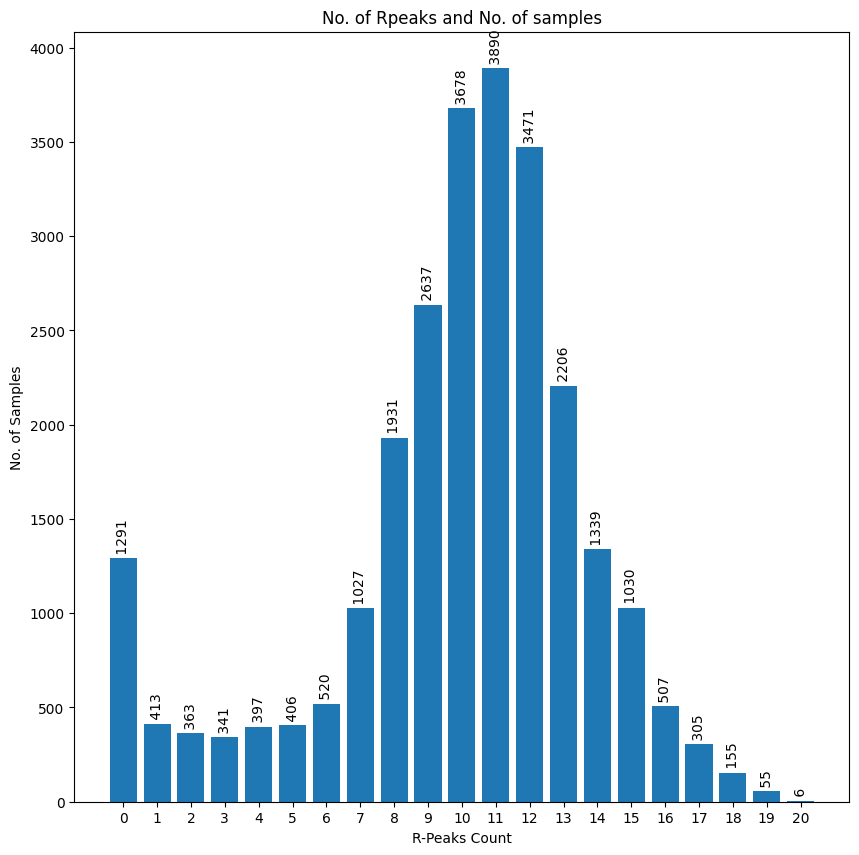

In [ ]:
unique, counts = np.unique(total_rpeaks, return_counts=True)
plt.figure(figsize=(10,10))
plt.bar(unique, counts)

# Add labels and a title
plt.xticks(unique)
plt.xlabel('R-Peaks Count')
plt.ylabel('No. of Samples')
plt.title('No. of Rpeaks and No. of samples')

for i, count in enumerate(counts):
    plt.text(unique[i], count, f" {str(count)}", ha='center', va='bottom', rotation=90)

# Show the plot
plt.show()

## Testing Different Segmenters besides Hamilton

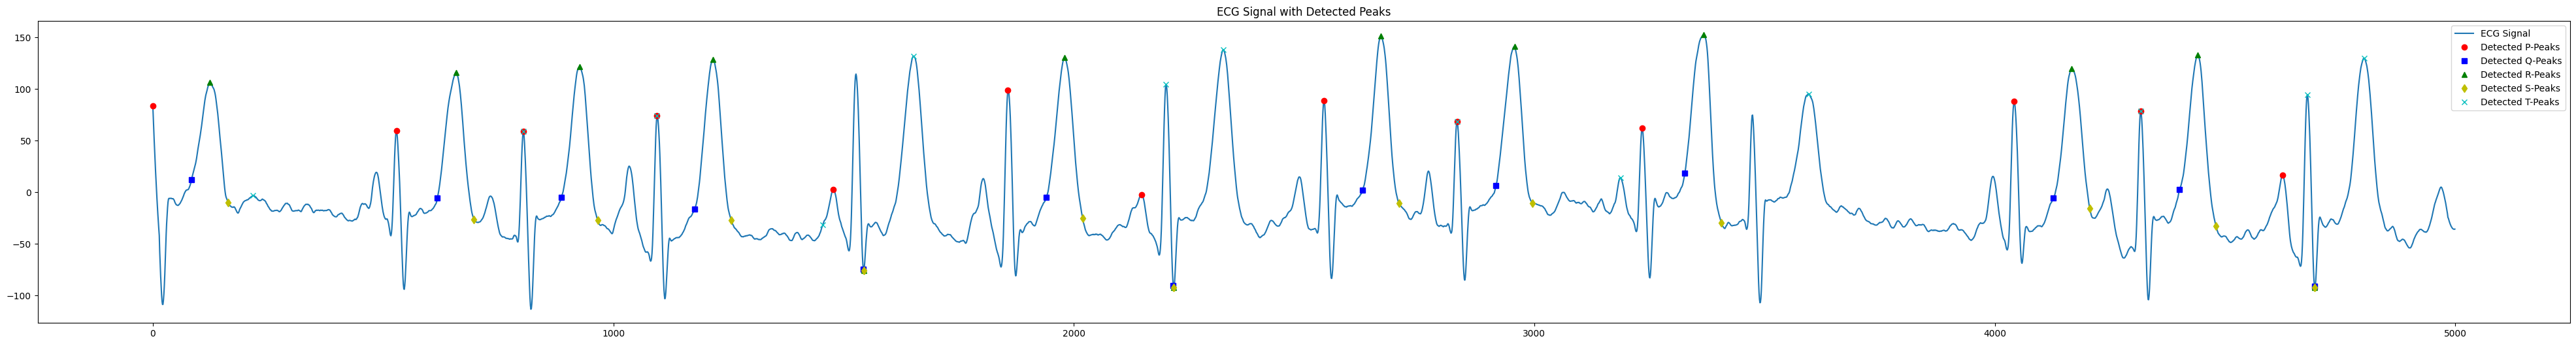

In [ ]:
import biosppy.signals.ecg as ecg

n = 1000
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.hamilton_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

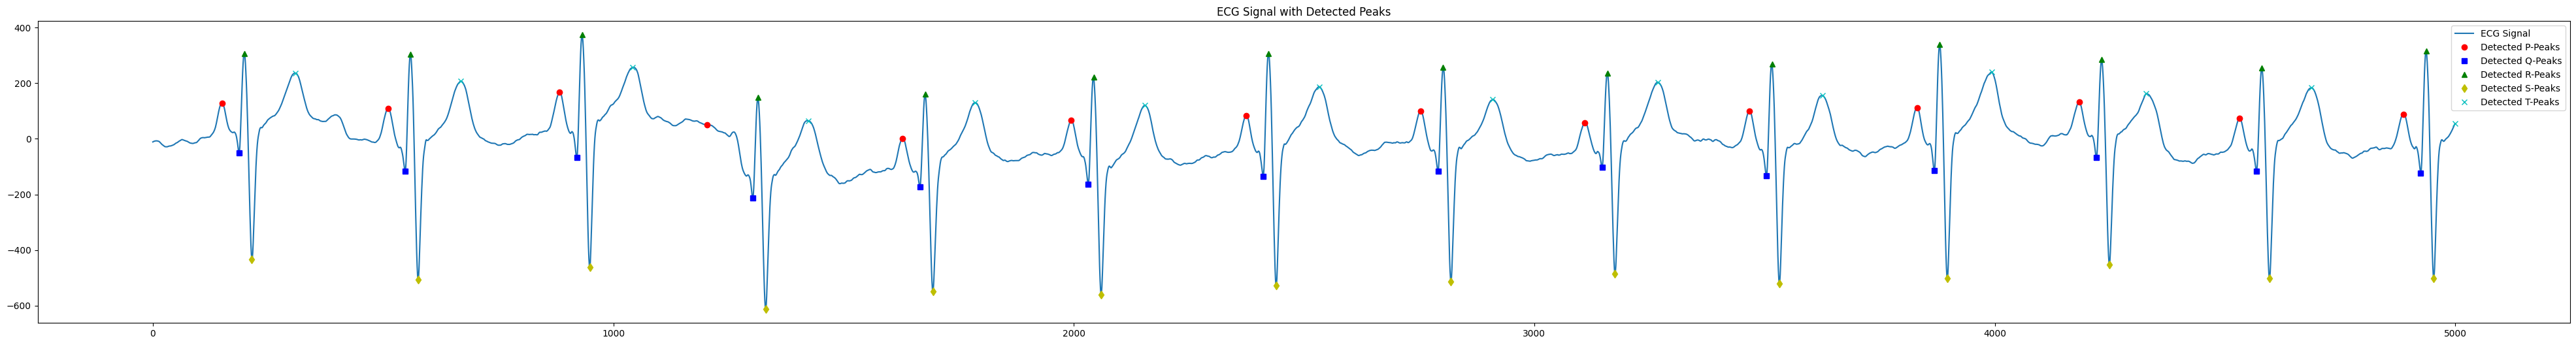

In [ ]:
import biosppy.signals.ecg as ecg

n = 7
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.christov_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

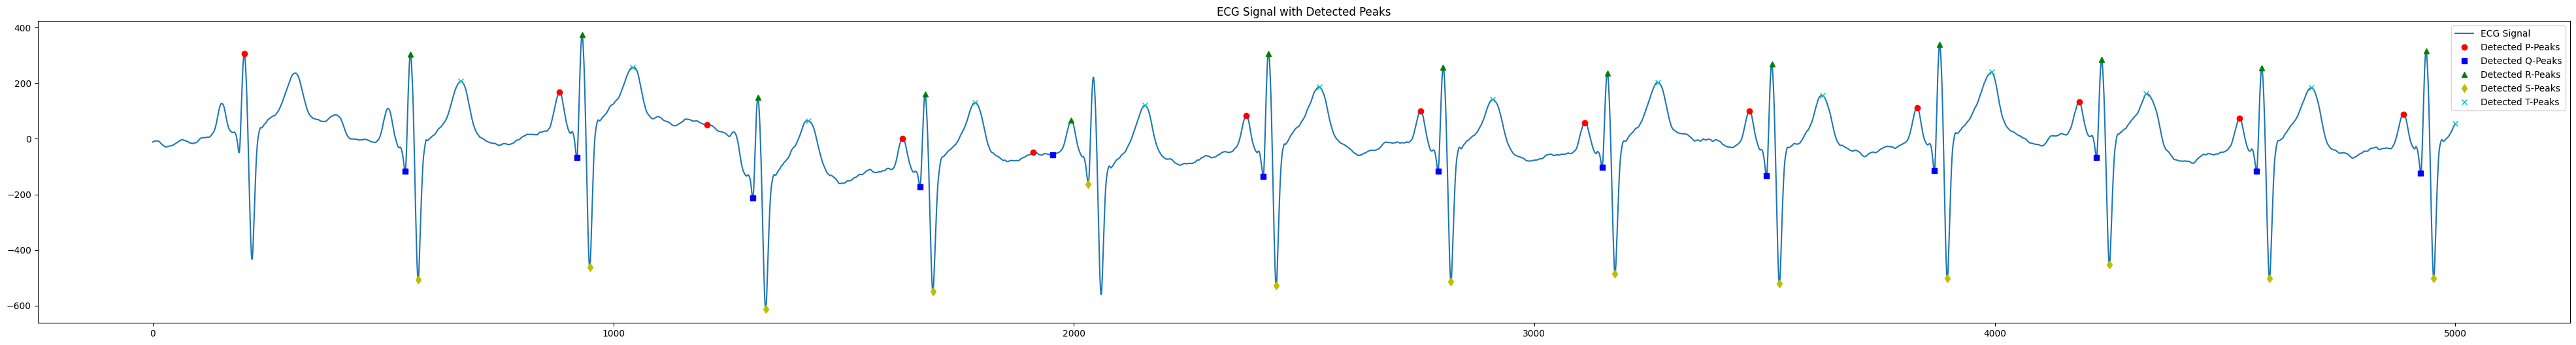

In [ ]:
import biosppy.signals.ecg as ecg

n = 7
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.gamboa_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

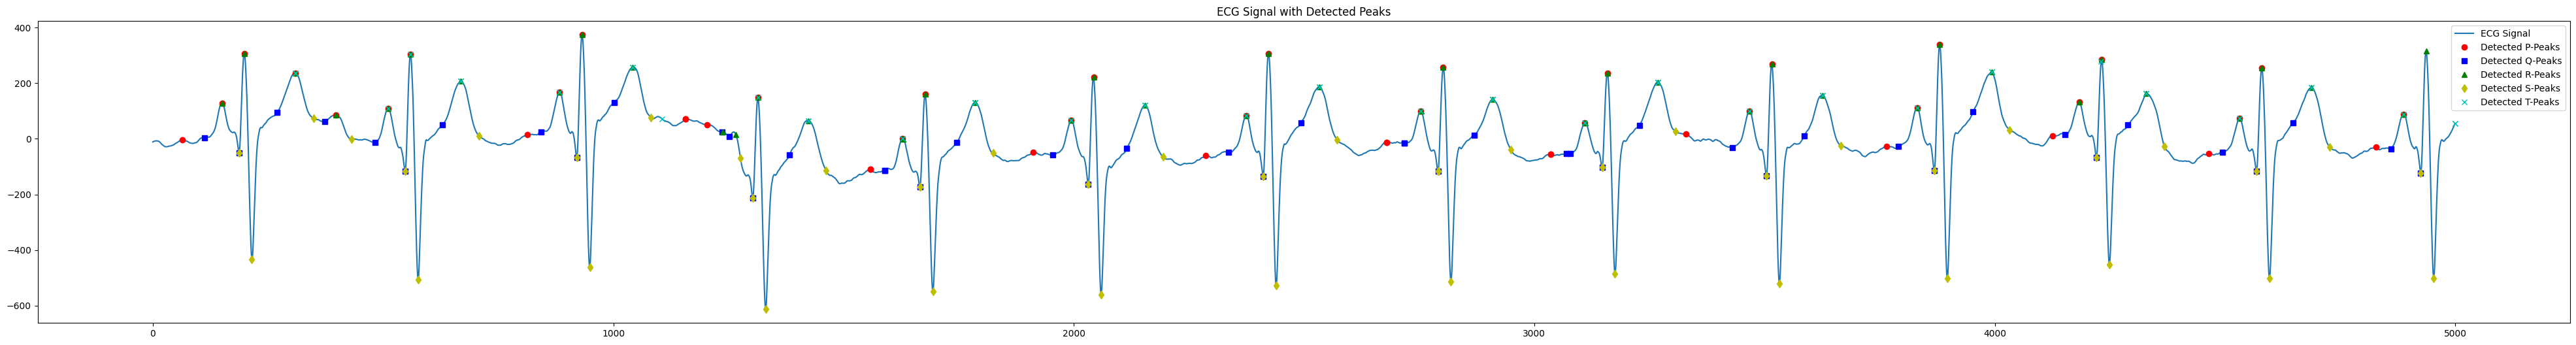

In [ ]:
import biosppy.signals.ecg as ecg

n = 7
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.ssf_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

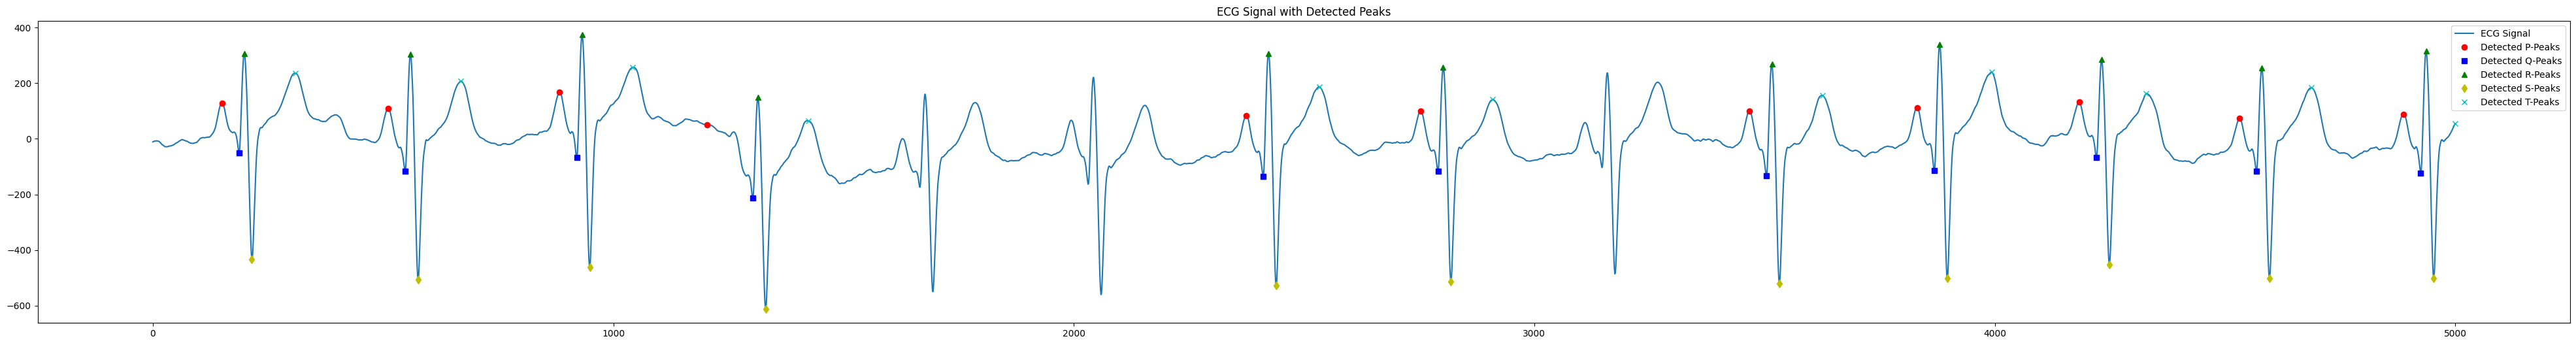

In [ ]:
import biosppy.signals.ecg as ecg

n = 7
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.engzee_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

## Create Python File

In [ ]:
X_ecg = ecg_X[:, 0:1, :]
X_ecg = X_ecg.reshape(2164,5000)

In [ ]:
import biosppy.signals.ecg as ecg

def pqrst_segmentation(input_file, patient_id, lead_id):
  # loading
  ecg_X = np.load(small_X_path, allow_pickle=True)

  X_ecg = ecg_X[patient_id, lead_id-1, :]
  # X_ecg = X_ecg.reshape(1,)
  print(X_ecg)

  savitzky_data = X_ecg
  smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
  out = ecg.christov_segmenter(smoothed_ecg_data)

  r_peak_indices = out['rpeaks']

  search_window = 40

  q_peak_indices = []
  s_peak_indices = []

  for r in r_peak_indices:
      if r - search_window >= 0:
          q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
          q_peak_indices.append(q_peak)
      if r + search_window < len(smoothed_ecg_data):
          s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
          s_peak_indices.append(s_peak)

  p_peak_indices = []
  t_peak_indices = []

  for i in range(len(q_peak_indices)):
      if len(p_peak_indices) == 0:
          seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
          max_amplitude_index = np.argmax(seg_ecg_signal)
          p_peak_indices.append(max_amplitude_index)
      else:
          seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
          max_amplitude_index = np.argmax(seg_ecg_signal)
          p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

  for i in range(len(s_peak_indices)):
      if i + 1 == len(s_peak_indices):
          seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
          max_amplitude_index = np.argmax(seg_ecg_signal)
          t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
      else:
          seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
          max_amplitude_index = np.argmax(seg_ecg_signal)
          t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

  return p_peak_indices, q_peak_indices, r_peak_indices, s_peak_indices, t_peak_indices, smoothed_ecg_data

[ 68  68  68 ... 156 151 166]


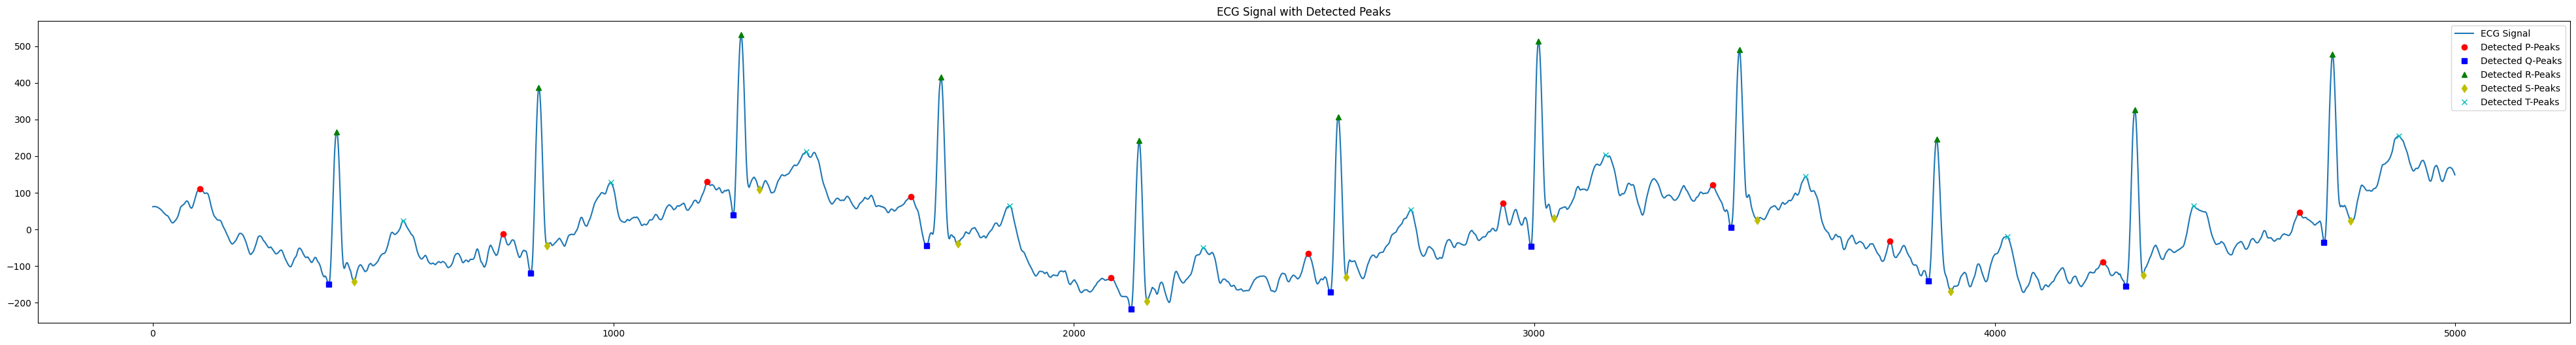

In [ ]:
p_peak_indices, q_peak_indices, r_peak_indices, s_peak_indices, t_peak_indices, smoothed_ecg_data = pqrst_segmentation(small_X_path, 1, 1)
plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

In [ ]:
import biosppy.signals.ecg as ecg
import numpy as np
from scipy.signal import savgol_filter

def pqrst_segmentation(input_file, patient_id, lead_id):
    # Load the ECG data from a file
    ecg_X = np.load(small_X_path, allow_pickle=True)

    # Extract the ECG data for the specified patient and lead
    X_ecg = ecg_X[patient_id, lead_id-1, :]

    # Smooth the ECG data using Savitzky-Golay filter
    smoothed_ecg_data = savgol_filter(X_ecg, window_length=30, polyorder=2)

    # Use the Christov's QRS complex detector to find R-peaks
    out = ecg.christov_segmenter(smoothed_ecg_data)
    r_peak_indices = out['rpeaks']

    # Initialize lists to store Q, S, P, and T peak indices
    q_peak_indices = []
    s_peak_indices = []
    p_peak_indices = []
    t_peak_indices = []

    for r in r_peak_indices:
      # Search for Q-peak to the left of the R-peak
      q_peak = None
      for i in range(r - 1, 0, -1):
          # once the q-peak starts to raise this loop stops and latest q-peak is set to be the 'q'
          if smoothed_ecg_data[i] > smoothed_ecg_data[i + 1]:
              q_peak = i
              break

      # Search for S-peak to the right of the R-peak
      s_peak = None
      for i in range(r + 1, len(smoothed_ecg_data)):
          # once the s-valley starts to raise this loop stops and latest s-valley is set to be the 's'
          if smoothed_ecg_data[i] > smoothed_ecg_data[i - 1]:
              s_peak = i
              break
      q_peak_indices.append(q_peak)
      s_peak_indices.append(s_peak)

      p_peak_indices = []
      t_peak_indices = []
      for i in range(len(q_peak_indices)):
          # Assuming P-peak is at 100 samples before the Q-peak
          if len(p_peak_indices) == 0:
              # for the first ECG wave, P peak is set to be the highest point before the Q of that wave
              if q_peak_indices[i] - 100 < 0:
                  seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i]]
                  max_amplitude_index = np.argmax(seg_ecg_signal)
                  p_peak_indices.append(max_amplitude_index)
              else:
                  seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i]]
                  max_amplitude_index = np.argmax(seg_ecg_signal)
                  p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)
          # Otherwise, P peak is the highest point in a 100 sized search window before Q
          else:
              seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
              max_amplitude_index = np.argmax(seg_ecg_signal)
              p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

      for i in range(len(s_peak_indices)):
          # Assuming T-peak is at 200 samples After the S-peak
          # for the last ECG wave, T peak is set to be the highest point after the S of that wave
          if i + 1 == len(s_peak_indices):
              seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
              max_amplitude_index = np.argmax(seg_ecg_signal)
              t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
          # Otherwise, T peak is the highest point in a 200 sized search window after S
          else:
              seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
              max_amplitude_index = np.argmax(seg_ecg_signal)
              t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

    # Create a 3D numpy array to store P, Q, R, S, and T peak indices and their corresponding amplitudes
    pqrst_data = np.zeros((len(r_peak_indices), 5, 2))

    # Fill the array with P, Q, R, S, and T peak indices and their corresponding amplitudes
    for i in range(len(r_peak_indices)):
        pqrst_data[i][0] = [p_peak_indices[i], smoothed_ecg_data[p_peak_indices[i]]]
        pqrst_data[i][1] = [q_peak_indices[i], smoothed_ecg_data[q_peak_indices[i]]]
        pqrst_data[i][2] = [r_peak_indices[i], smoothed_ecg_data[r_peak_indices[i]]]
        pqrst_data[i][3] = [s_peak_indices[i], smoothed_ecg_data[s_peak_indices[i]]]
        pqrst_data[i][4] = [t_peak_indices[i], smoothed_ecg_data[t_peak_indices[i]]]

    return pqrst_data

In [ ]:
pqrst_segmentation_output = pqrst_segmentation(small_X_path, 7, 1)

In [ ]:
pqrst_segmentation_output

array([[[ 1.50000000e+02,  1.26896875e+02],
        [ 1.86000000e+02, -4.25093750e+01],
        [ 1.99000000e+02,  3.07027679e+02],
        [ 2.16000000e+02, -4.30877232e+02],
        [ 3.10000000e+02,  2.36300000e+02]],

       [[ 5.11000000e+02,  1.09017411e+02],
        [ 5.47000000e+02, -1.12676339e+02],
        [ 5.59000000e+02,  3.04347991e+02],
        [ 5.77000000e+02, -4.99434375e+02],
        [ 6.69000000e+02,  2.06734375e+02]],

       [[ 8.83000000e+02,  1.66717857e+02],
        [ 9.20000000e+02, -6.56756696e+01],
        [ 9.32000000e+02,  3.73782366e+02],
        [ 9.50000000e+02, -4.45039509e+02],
        [ 1.04200000e+03,  2.56750446e+02]],

       [[ 1.20200000e+03,  5.04685268e+01],
        [ 1.30200000e+03, -2.09544643e+02],
        [ 1.31400000e+03,  1.48211384e+02],
        [ 1.33200000e+03, -5.99272545e+02],
        [ 1.42300000e+03,  6.51283482e+01]],

       [[ 1.62800000e+03,  2.28348214e-01],
        [ 1.66500000e+03, -1.72542857e+02],
        [ 1.67700000e+03

In [ ]:
import biosppy.signals.ecg as ecg

n = 4
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.hamilton_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

In [ ]:
import biosppy.signals.ecg as ecg

n = 4
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.hamilton_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

In [ ]:
import biosppy.signals.ecg as ecg

n = 4
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.hamilton_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']

search_window = 40

q_peak_indices = []
s_peak_indices = []

for r in r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(r_peak_indices, smoothed_ecg_data[r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()

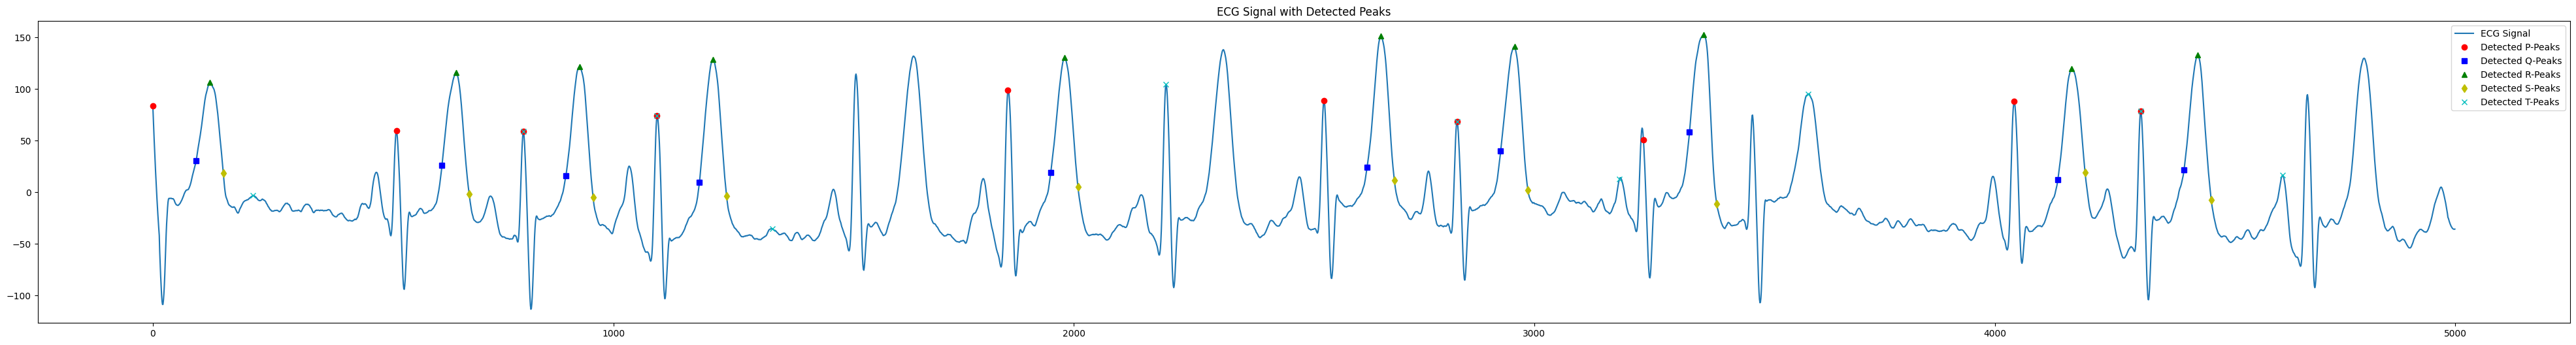

In [ ]:
import biosppy.signals.ecg as ecg

n = 1000
savitzky_data = original.iloc[n, :].values
smoothed_ecg_data = savgol_filter(savitzky_data, window_length=30, polyorder=2)
out = ecg.hamilton_segmenter(smoothed_ecg_data)

r_peak_indices = out['rpeaks']
r_peak_amplitudes = smoothed_ecg_data[r_peak_indices]

# Filter R-peaks with positive amplitudes
positive_r_peak_indices = [r for r, amplitude in zip(r_peak_indices, r_peak_amplitudes) if amplitude > 0]

search_window = 30

q_peak_indices = []
s_peak_indices = []

for r in positive_r_peak_indices:
    if r - search_window >= 0:
        q_peak = r - search_window + np.argmin(smoothed_ecg_data[r - search_window : r])
        q_peak_indices.append(q_peak)
    if r + search_window < len(smoothed_ecg_data):
        s_peak = r + np.argmin(smoothed_ecg_data[r : r + search_window])
        s_peak_indices.append(s_peak)

p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
      if q_peak_indices[i] - 100 < 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 25]
      else:
          seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
      max_amplitude_index = np.argmax(seg_ecg_signal)
      p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 100:q_peak_indices[i] - 25]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 100 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 25:s_peak_indices[i] + 200]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 25 + max_amplitude_index)

plt.figure(figsize=(50, 6))
plt.plot(smoothed_ecg_data, label='ECG Signal')
plt.plot(p_peak_indices, smoothed_ecg_data[p_peak_indices], 'ro', label='Detected P-Peaks')  # Red circles for P-Peaks
plt.plot(q_peak_indices, smoothed_ecg_data[q_peak_indices], 'bs', label='Detected Q-Peaks')  # Blue squares for Q-Peaks
plt.plot(positive_r_peak_indices, smoothed_ecg_data[positive_r_peak_indices], 'g^', label='Detected R-Peaks')  # Green triangles for R-Peaks with positive amplitudes
plt.plot(s_peak_indices, smoothed_ecg_data[s_peak_indices], 'yd', label='Detected S-Peaks')  # Yellow diamonds for S-Peaks
plt.plot(t_peak_indices, smoothed_ecg_data[t_peak_indices], 'cx', label='Detected T-Peaks')  # Cyan 'x' markers for T-Peaks
plt.legend()
plt.title('ECG Signal with Detected Peaks')
plt.show()


In [ ]:
p_peak_indices, q_peak_indices, positive_r_peak_indices, s_peak_indices, t_peak_indices


([785, 347, 716, 1082, 1390, 1795, 2103, 2525, 2920, 3734, 4099, 4458, 4809],
 [21, 398, 767, 1133, 1490, 1846, 2203, 2576, 2968, 3778, 4151, 4508, 4861],
 [39, 416, 785, 1151, 1507, 1863, 2221, 2594, 2986, 3796, 4168, 4526, 4878],
 [57, 434, 803, 1168, 1525, 1880, 2238, 2611, 3003, 3814, 4186, 4543, 4896],
 [163, 531, 903, 1266, 1626, 1984, 2344, 2714, 3111, 4013, 4289, 4642, 4999])

In [ ]:
# Initialize the list to store the desired pattern
peak_pattern = []

# Iterate through the Q-peak indices and create the pattern
for i in range(len(q_peak_indices)):
    if i == 0:
      peak_pattern.append([q_peak_indices[i]])
    # If there is a corresponding S-peak, add it to the pattern
    if i < len(s_peak_indices)-1:
        peak_pattern.append([s_peak_indices[i],q_peak_indices[i+1]])
    else:
        peak_pattern.append([s_peak_indices[i]])

# Print the resulting pattern
print(peak_pattern)

[[382], [437, 821], [856, 1260], [1317, 1681], [1748, 2124], [2159, 2557], [2591, 2993], [3042, 3427], [3484, 3856], [3904, 4285], [4322, 4715], [4772]]


In [ ]:
seg_ecg_signal = smoothed_ecg_data[:300]
max_amplitude_index = np.argmax(seg_ecg_signal)
max_amplitude = ecg_signal[max_amplitude_index]

# Print the index and the amplitude of the highest peak
print("Index of the maximum amplitude peak:", max_amplitude_index)
print("Maximum amplitude:", max_amplitude)

Index of the maximum amplitude peak: 103
Maximum amplitude: 110.67790178571082


In [ ]:
p_peak_indices = []
t_peak_indices = []

for i in range(len(q_peak_indices)):
    if len(p_peak_indices) == 0:
        seg_ecg_signal = smoothed_ecg_data[:q_peak_indices[i] - 50]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[q_peak_indices[i] - 250:q_peak_indices[i] - 50]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        p_peak_indices.append(q_peak_indices[i] - 250 + max_amplitude_index)

for i in range(len(s_peak_indices)):
    if i + 1 == len(s_peak_indices):
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 50:]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 50 + max_amplitude_index)
    else:
        seg_ecg_signal = smoothed_ecg_data[s_peak_indices[i] + 50:s_peak_indices[i] + 250]
        max_amplitude_index = np.argmax(seg_ecg_signal)
        t_peak_indices.append(s_peak_indices[i] + 50 + max_amplitude_index)

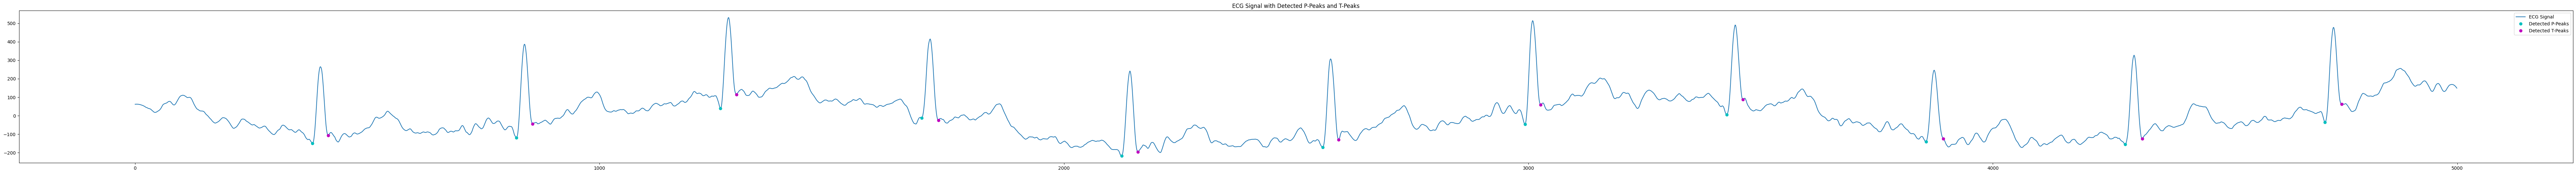

In [ ]:
import numpy as np
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt

ecg_signal = smoothed_ecg_data

# Process the ECG signal to detect R-peaks using more robust methods
out = ecg.hamilton_segmenter(ecg_signal)

# Get the R-peak indices
r_peak_indices = out['rpeaks']

# Define search windows for P and T peaks
p_peak_search_window = 20  # Adjust this window for P-peak detection
t_peak_search_window = 20  # Adjust this window for T-peak detection

# Initialize lists for P-peak and T-peak indices
p_peak_indices = []
t_peak_indices = []

# Detect P-peaks and T-peaks
for r in r_peak_indices:
    if r - p_peak_search_window >= 0:
        p_peak = r - p_peak_search_window + np.argmin(ecg_signal[r - p_peak_search_window : r])
        p_peak_indices.append(p_peak)

    if r + t_peak_search_window < len(ecg_signal):
        t_peak = r + np.argmin(ecg_signal[r : r + t_peak_search_window])
        t_peak_indices.append(t_peak)

# Plot the original ECG signal with detected P-peaks and T-peaks
plt.figure(figsize=(100, 6))
plt.plot(ecg_signal, label='ECG Signal')
plt.plot(p_peak_indices, ecg_signal[p_peak_indices], 'co', label='Detected P-Peaks')
plt.plot(t_peak_indices, ecg_signal[t_peak_indices], 'mo', label='Detected T-Peaks')
plt.legend()
plt.title('ECG Signal with Detected P-Peaks and T-Peaks')
plt.show()


In [ ]:
s_peak_indices

[]

In [ ]:
smoothed_ecg_data.shape

(5000,)

In [ ]:
savitzky_smoothen_data = smoothed_ecg_data

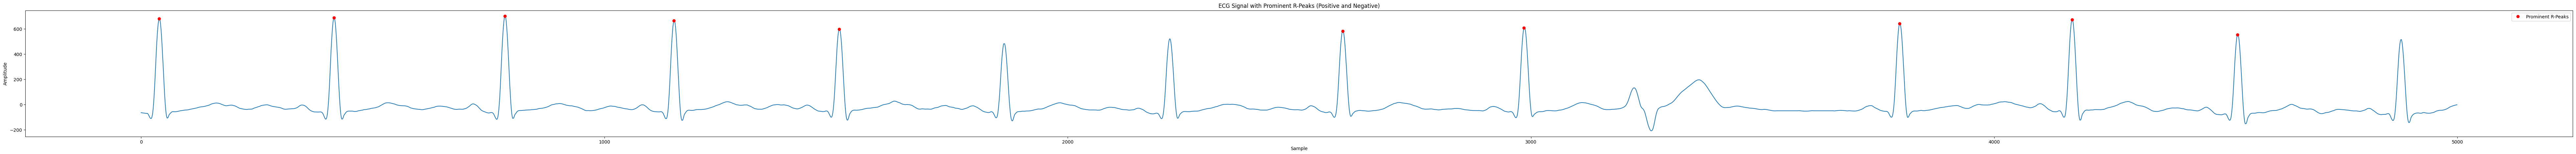

Indices of the 5 Most Prominent R-Peaks: [4525 2594 1507 2985 3796 1150 4168   39  416  785]


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

ecg_signal = savitzky_smoothen_data

filtered_signal = signal.medfilt(ecg_signal, kernel_size=3)

# Detect both positive and negative R-peaks
height_threshold = 0.1
distance_threshold = 100

# Find positive R-peaks
positive_r_peaks, _ = signal.find_peaks(filtered_signal, height=height_threshold, distance=distance_threshold)

# Invert the signal to detect negative R-peaks
inverted_signal = -filtered_signal
negative_r_peaks, _ = signal.find_peaks(inverted_signal, height=height_threshold, distance=distance_threshold)

# Combine both positive and negative R-peaks
all_r_peaks = np.concatenate((positive_r_peaks, negative_r_peaks))
# all_r_peaks = negative_r_peaks

# Sort the detected peaks by amplitude and keep the top 5
n_prominent_peaks = 10
sorted_r_peaks = np.argsort(filtered_signal[all_r_peaks])[-n_prominent_peaks:]
prominent_r_peaks = all_r_peaks[sorted_r_peaks]

# Visualize the ECG signal with the 5 most prominent R-peaks
plt.figure(figsize=(100,5))
plt.plot(filtered_signal)
plt.plot(prominent_r_peaks, filtered_signal[prominent_r_peaks], 'ro', label='Prominent R-Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Prominent R-Peaks (Positive and Negative)')
plt.legend()
plt.show()

# Print the indices of the 5 most prominent R-peaks
print(f"Indices of the 5 Most Prominent R-Peaks: {prominent_r_peaks}")

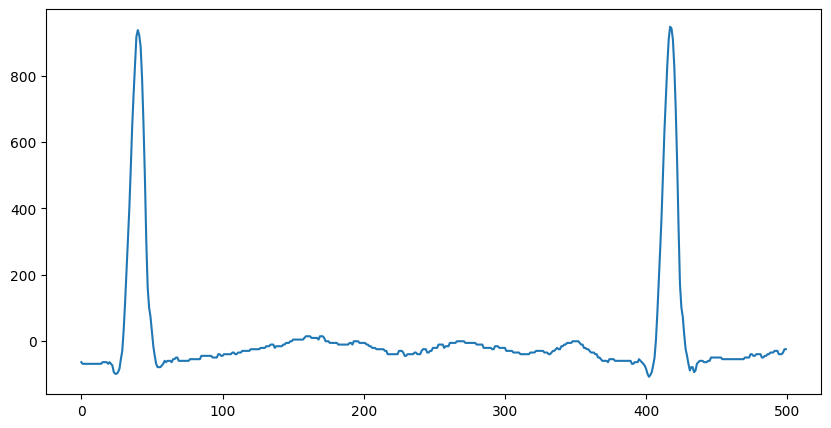

In [ ]:
from scipy.signal import savgol_filter

n = 2

plt.figure(figsize=(10,5))
plt.plot(original.iloc[n, :500].values)

In [ ]:
r_peak_index = np.argmax(savitzky_smoothen_data)
filtered_signal = savitzky_smoothen_data
p_segment_indices = np.where(np.diff(filtered_signal[:r_peak_index]) > 0)[0]
print(p_segment_indices)
print(r_peak_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 37 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64]
66


In [ ]:
filtered_signal[64]

383.6363839285594

In [ ]:
len(filtered_signal)

500

In [ ]:
def segment_ecg_wave(filtered_signal):
  """Segment the ECG wave into P, QRS, and T segments.

  Args:
    filtered_signal: A list of the filtered ECG signal.

  Returns:
    A list of three lists, containing the P, QRS, and T segments, respectively.
  """

  # Find the R peak of the QRS complex.
  r_peak_index = np.argmax(filtered_signal)

  # Find the zero-crossings before and after the R peak.
  p_segment_indices = np.where(np.diff(filtered_signal[:r_peak_index]) > 0)[0]
  t_segment_indices = np.where(np.diff(filtered_signal[r_peak_index:]) < 0)[0]

  # Segment the P, QRS, and T waves.
  p_segment = filtered_signal[p_segment_indices[-1]:r_peak_index]
  qrs_segment = filtered_signal[r_peak_index - 10:r_peak_index + 10]
  t_segment = filtered_signal[r_peak_index + 1:t_segment_indices[0] + 2]

  return p_segment, qrs_segment, t_segment

66

In [ ]:
import scipy.signal as sig

fs=500

# Compute the moving average of the ECG signal
ma_ecg_data = sig.lfilter([1.0 / 3, 1.0 / 3, 1.0 / 3], [1], savitzky_smoothen_data)

# Subtract the moving average from the ECG signal to remove baseline wander
cleaned_ecg_data = savitzky_smoothen_data - ma_ecg_data

# Apply a high-pass filter to the ECG signal to remove high-frequency noise
hp_filter = sig.butter(2, 0.5 / (fs / 2), btype='high')
filtered_ecg_data = sig.lfilter(hp_filter[0], hp_filter[1], cleaned_ecg_data)

In [ ]:
ma_ecg_data[:5], savitzky_smoothen_data[:5]

(array([ -9.76438172, -16.85411568, -21.46810345, -14.04086485,
         -7.21033092]),
 array([-29.29314516, -21.26920189, -13.84196329,  -7.01142937,
         -0.77760011]))

In [ ]:
# Choose a wavelet filter
wavelet_filter = 'db4'

# Decompose the ECG signal into different sub-bands using the DWT filter
coeffs = pywt.wavedec(filtered_ecg_data, wavelet_filter)

In [ ]:
# The P wave is typically found in the high-frequency sub-bands
p_wave_subbands = coeffs[-1:]

# The QRS complex is typically found in the low-frequency sub-bands
qrs_complex_subbands = coeffs[0:3]

# The T wave is typically found in the low-frequency sub-bands
t_wave_subbands = coeffs[0:3]

In [ ]:
# Identify the P wave
p_wave_peaks = sig.find_peaks(p_wave_subbands[0], height=0.5)
p_wave_onsets = p_wave_peaks[0]
p_wave_offsets = p_wave_peaks[1]["peak_heights"]

# Identify the QRS complex
qrs_complex_peaks = sig.find_peaks(qrs_complex_subbands[0], height=0.5)
qrs_complex_onsets = qrs_complex_peaks[0]
qrs_complex_offsets = qrs_complex_peaks[1]["peak_heights"]

# Identify the T wave
t_wave_peaks = sig.find_peaks(t_wave_subbands[0], height=0.5)
t_wave_onsets = t_wave_peaks[0]
t_wave_offsets = t_wave_peaks[1]["peak_heights"]

In [ ]:
# Segment the P wave
p_wave_segments = [(onset, int(offset)) for onset, offset in zip(p_wave_onsets, p_wave_offsets)]

# Segment the QRS complex
qrs_complex_segments = [(onset, int(offset)) for onset, offset in zip(qrs_complex_onsets, qrs_complex_offsets)]

# Segment the T wave
t_wave_segments = [(onset, int(offset)) for onset, offset in zip(t_wave_onsets, t_wave_offsets)]

In [ ]:
p_wave_onsets, qrs_complex_onsets, t_wave_onsets

(array([ 1,  3, 28, 30, 32, 44, 46]), array([ 5,  7, 10]), array([ 5,  7, 10]))

In [ ]:
p_wave_normalized

[8.674529309005942,
 26.02358792701783,
 242.8868206521664,
 260.23587927017826,
 277.58493788819015,
 381.67928959626147,
 399.02834821427336]

In [ ]:
# Calculate scaling factors for P, QRS, and T waves
p_wave_scaling_factor = max(ecg_data) / max(p_wave_onsets)
qrs_scaling_factor = max(ecg_data) / max(qrs_complex_onsets)
t_wave_scaling_factor = max(ecg_data) / max(t_wave_onsets)

# Normalize the segmented waves
p_wave_normalized = [amplitude[0] * p_wave_scaling_factor for amplitude in p_wave_segments]
qrs_normalized = [amplitude[0] * qrs_scaling_factor for amplitude in qrs_complex_segments]
t_wave_normalized = [amplitude[0] * t_wave_scaling_factor for amplitude in t_wave_segments]

# Plot the original ECG signal
plt.plot(ecg_data)



In [ ]:
p_wave_normalized

[8.674529309005942,
 26.02358792701783,
 242.8868206521664,
 260.23587927017826,
 277.58493788819015,
 381.67928959626147,
 399.02834821427336]

In [ ]:
t_wave_normalized

[199.51417410713668, 279.3198437499913, 399.02834821427336]

In [ ]:
qrs_normalized

[199.51417410713668, 279.3198437499913, 399.02834821427336]

In [ ]:
qrs_complex_onsets

array([ 5,  7, 10])

TypeError: ignored

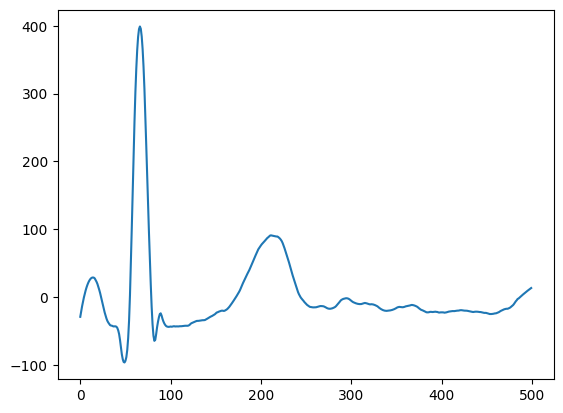

In [ ]:
# Calculate scaling factors for P, QRS, and T waves
p_wave_scaling_factor = max(ecg_data) / max(p_wave_onsets)
qrs_scaling_factor = max(ecg_data) / max(qrs_complex_onsets)
t_wave_scaling_factor = max(ecg_data) / max(t_wave_onsets)

# Normalize the segmented waves
p_wave_normalized = [amplitude[0] * p_wave_scaling_factor for amplitude in p_wave_segments]
qrs_normalized = [amplitude[0] * qrs_scaling_factor for amplitude in qrs_complex_segments]
t_wave_normalized = [amplitude[0] * t_wave_scaling_factor for amplitude in t_wave_segments]

# Plot the original ECG signal
plt.plot(ecg_data)

# Plot the P waves (normalized)
for onset, offset in p_wave_normalized:
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='red')

# Plot the QRS complexes (normalized)
for onset, offset in qrs_normalized:
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='pink')

# Plot the T waves (normalized)
for onset, offset in t_wave_normalized:
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='green')

# Set the title and axis labels
plt.title('ECG Wave Segmentation (Normalized)')
plt.xlabel('Sample Index')
plt.ylabel('Voltage (mV)')

# Show the plot
plt.show()

5 21
7 12
10 0


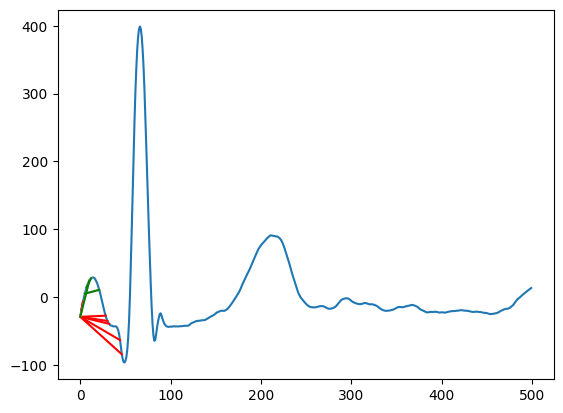

In [ ]:
import matplotlib.pyplot as plt

# Plot the original ECG signal
plt.plot(savitzky_smoothen_data)

ecg_data = savitzky_smoothen_data

# Plot the P waves
for onset, offset in p_wave_segments:
    # print(onset, offset)
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='red')

# Plot the QRS complexes
for onset, offset in qrs_complex_segments:
    print(onset, offset)
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='pink')

# Plot the T waves
for onset, offset in t_wave_segments:
    plt.plot([onset, offset], [ecg_data[onset], ecg_data[offset]], color='green')


# Show the plot
plt.show()

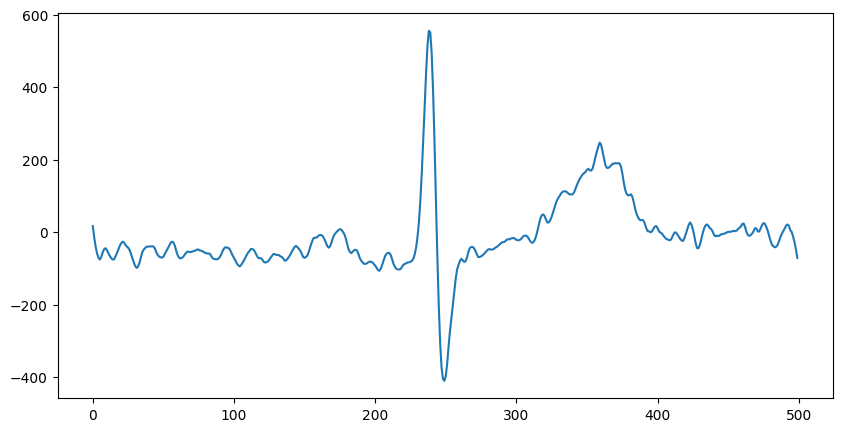

In [ ]:
from scipy.signal import savgol_filter

# Load the ECG wave data
Savitzky_data = temp_data.iloc[8, :].values

# Smooth the ECG wave using Savitzky-Golay filter
smoothed_ecg_data = savgol_filter(Savitzky_data, window_length=10, polyorder=2)

# Plot the smoothed ECG wave
plt.figure(figsize=(10,5))
plt.plot(smoothed_ecg_data)
plt.show()

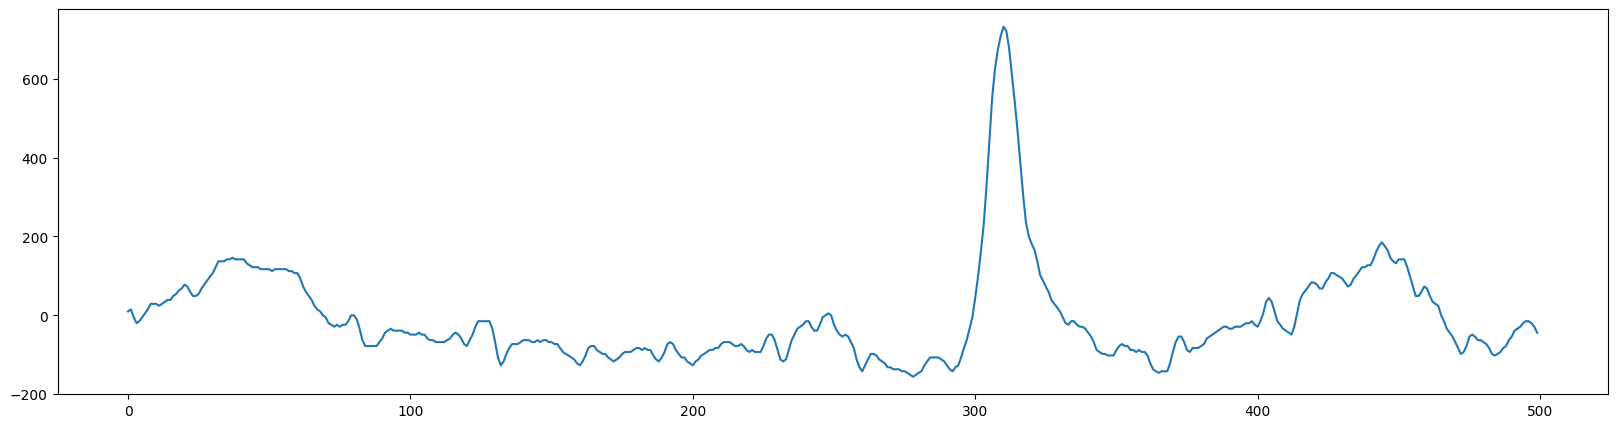

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ecg_data.iloc[0, :].values)

In [ ]:
X_ecg = pd.DataFrame(X_ecg)

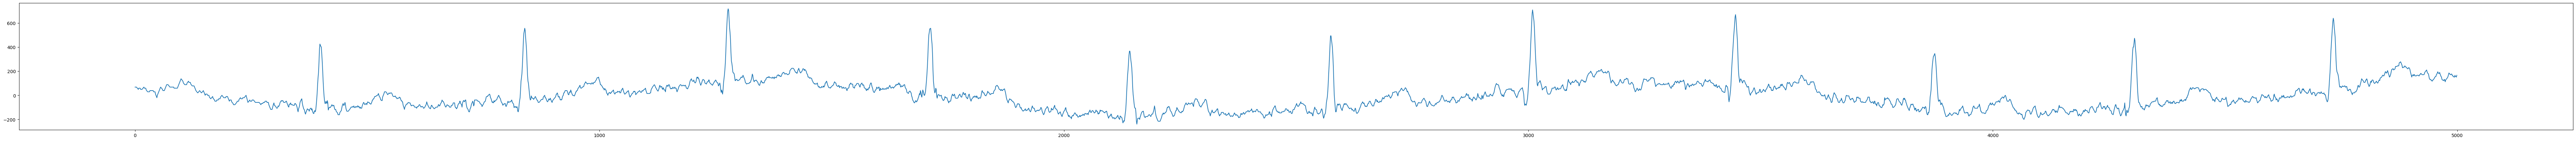

In [ ]:
plt.figure(figsize=(100,5))
plt.plot(temp_data.iloc[1, :].values)

17


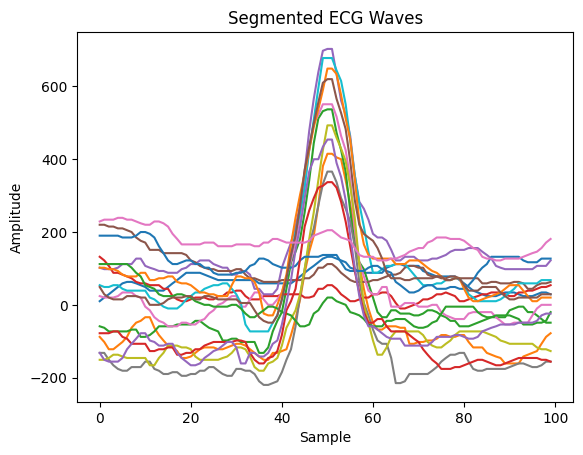

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

ecg_signal = temp_data.iloc[1, :].values

filtered_signal = signal.medfilt(ecg_signal, kernel_size=3)

# Detect R-peaks
r_peaks, _ = signal.find_peaks(filtered_signal, height=0.6, distance=200)

segment_length = 100
segments = [filtered_signal[peak - segment_length // 2 : peak + segment_length // 2] for peak in r_peaks]

for segment in segments:
    plt.plot(segment)

print(len(segments))

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Segmented ECG Waves')
plt.show()

In [ ]:
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 1.8 MB/s eta 0:00:00


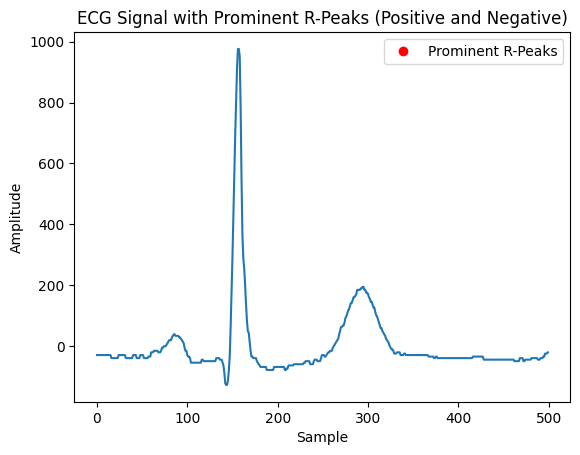

Indices of the 5 Most Prominent R-Peaks: []


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from biosppy.signals import ecg

ecg_signal = temp_data.iloc[500, :500].values

filtered_signal = signal.medfilt(ecg_signal, kernel_size=3)

# Apply the Hamilton QRS detection algorithm
qrs_indices, = ecg.hamilton_segmenter(filtered_signal)

# Select the top 5 R-peaks from the detected QRS indices
n_prominent_peaks = 5
sorted_r_peaks = np.argsort(filtered_signal[qrs_indices])[-n_prominent_peaks:]
prominent_r_peaks = qrs_indices[sorted_r_peaks]

# Visualize the ECG signal with the 5 most prominent R-peaks
plt.plot(filtered_signal)
plt.plot(prominent_r_peaks, filtered_signal[prominent_r_peaks], 'ro', label='Prominent R-Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Prominent R-Peaks (Positive and Negative)')
plt.legend()
plt.show()

# Print the indices of the 5 most prominent R-peaks
print(f"Indices of the 5 Most Prominent R-Peaks: {prominent_r_peaks}")


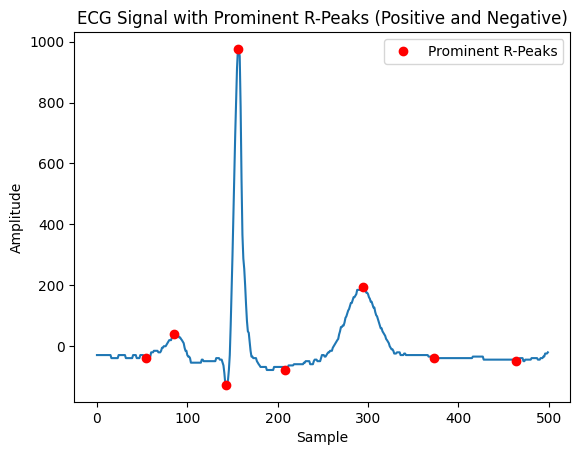

Indices of the 5 Most Prominent R-Peaks: [143 208 464  54 373  85 294 156]


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

ecg_signal = temp_data.iloc[500, :500].values

filtered_signal = signal.medfilt(ecg_signal, kernel_size=3)

# Detect both positive and negative R-peaks
height_threshold = 0.6
distance_threshold = 50

# Find positive R-peaks
positive_r_peaks, _ = signal.find_peaks(filtered_signal, height=height_threshold, distance=distance_threshold)

# Invert the signal to detect negative R-peaks
inverted_signal = -filtered_signal
negative_r_peaks, _ = signal.find_peaks(inverted_signal, height=height_threshold, distance=distance_threshold)

# Combine both positive and negative R-peaks
all_r_peaks = np.concatenate((positive_r_peaks, negative_r_peaks))

# Sort the detected peaks by amplitude and keep the top 5
n_prominent_peaks = 10
sorted_r_peaks = np.argsort(filtered_signal[all_r_peaks])[-n_prominent_peaks:]
prominent_r_peaks = all_r_peaks[sorted_r_peaks]

# Visualize the ECG signal with the 5 most prominent R-peaks
plt.plot(filtered_signal)
plt.plot(prominent_r_peaks, filtered_signal[prominent_r_peaks], 'ro', label='Prominent R-Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Prominent R-Peaks (Positive and Negative)')
plt.legend()
plt.show()

# Print the indices of the 5 most prominent R-peaks
print(f"Indices of the 5 Most Prominent R-Peaks: {prominent_r_peaks}")

In [ ]:
ecg.hamilton_segmenter(ecg_signal)

ReturnTuple(rpeaks=array([157, 588]))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]


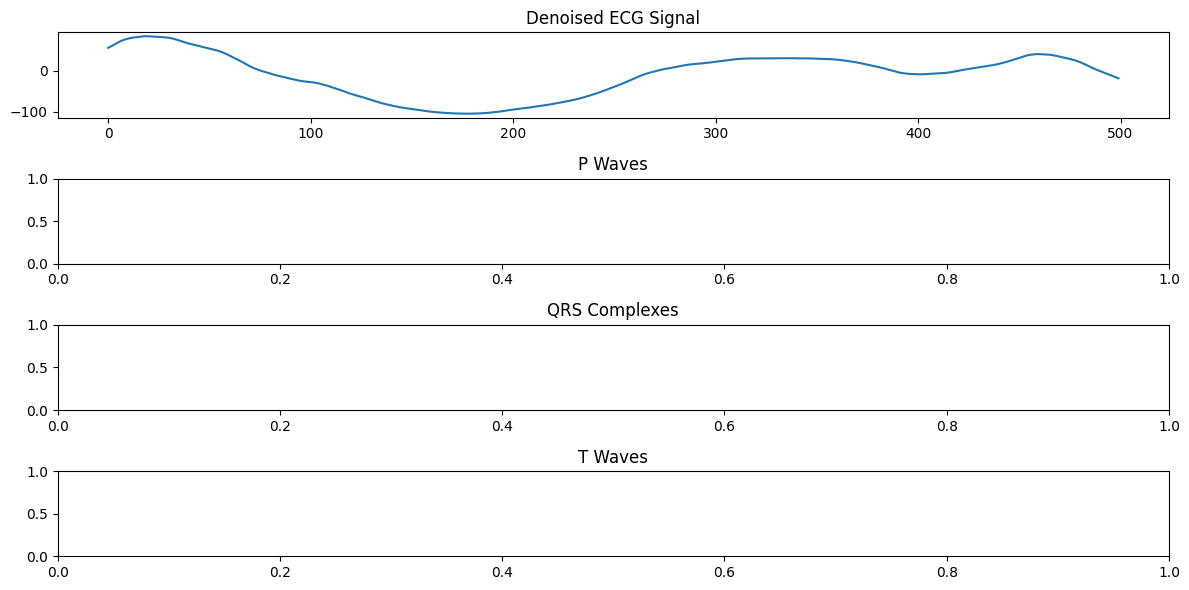

In [ ]:
import pywt
from biosppy.signals import ecg

ecg_signal = ecg_data.iloc[0, :].values

# Clean the ECG signal using the Hamilton algorithm
qrs_indices, = ecg.hamilton_segmenter(ecg_signal)

print(qrs_indices)

# Perform DWT decomposition
wavelet = 'db4'  # Choose a wavelet family
level = 6  # Choose the decomposition level
coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

# Apply thresholding to the DWT coefficients
threshold = 0.1  # Adjust as needed
thresholded_coeffs = [pywt.threshold(c, threshold, 'soft') for c in coeffs]

# Reconstruct the denoised signal
denoised_signal = pywt.waverec(thresholded_coeffs, wavelet)

# Define a function to segment the waves
def segment_waves(ecg_signal, r_peaks):
    p_waves = []
    qrs_complexes = []
    t_waves = []

    for i in range(len(r_peaks) - 1):
        r_peak_start = r_peaks[i]
        r_peak_end = r_peaks[i + 1]

        # Example: P-wave starts 100 samples before R-peak
        p_start = max(0, r_peak_start - 100)
        p_end = r_peak_start

        # Example: QRS complex extends from R-peak to 100 samples after R-peak
        qrs_start = r_peak_start
        qrs_end = min(len(ecg_signal), r_peak_end + 100)

        # Example: T-wave starts 100 samples after R-peak
        t_start = r_peak_end
        t_end = min(len(ecg_signal), r_peak_end + 100)

        p_waves.append(ecg_signal[p_start:p_end])
        qrs_complexes.append(ecg_signal[qrs_start:qrs_end])
        t_waves.append(ecg_signal[t_start:t_end])

    return p_waves, qrs_complexes, t_waves

# Segment waves based on denoised signal and R-peaks
p_waves, qrs_complexes, t_waves = segment_waves(savitzky_smoothen_data, qrs_indices)

# # Identify background waves based on the remaining portions of the signal
# background_waves = []
# for i in range(len(qrs_indices) - 1):
#     start = qrs_indices[i]
#     end = qrs_indices[i + 1]
#     background_waves.append(denoised_signal[end:start])

# Visualize the extracted waves and background waves
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(denoised_signal)
plt.title('Denoised ECG Signal')

plt.subplot(4, 1, 2)
for wave in p_waves:
    plt.plot(wave)
plt.title('P Waves')

plt.subplot(4, 1, 3)
for wave in qrs_complexes:
    plt.plot(wave)
plt.title('QRS Complexes')

plt.subplot(4, 1, 4)
for wave in t_waves:
    plt.plot(wave)
plt.title('T Waves')

plt.tight_layout()
plt.show()

# print(p_waves)
# print(qrs_complexes)
# print(t_waves)

In [ ]:
print()

In [ ]:
import pywt
from biosppy.signals import ecg

ecg_signal = temp_data.iloc[1, :].values

# Clean the ECG signal using the Hamilton algorithm
qrs_indices, = ecg.hamilton_segmenter(ecg_signal)

# Perform DWT decomposition
wavelet = 'db4'  # Choose a wavelet family
level = 6  # Choose the decomposition level
coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

# Apply thresholding to the DWT coefficients
threshold = 0.1  # Adjust as needed
thresholded_coeffs = [pywt.threshold(c, threshold, 'soft') for c in coeffs]

# Reconstruct the denoised signal
denoised_signal = pywt.waverec(thresholded_coeffs, wavelet)

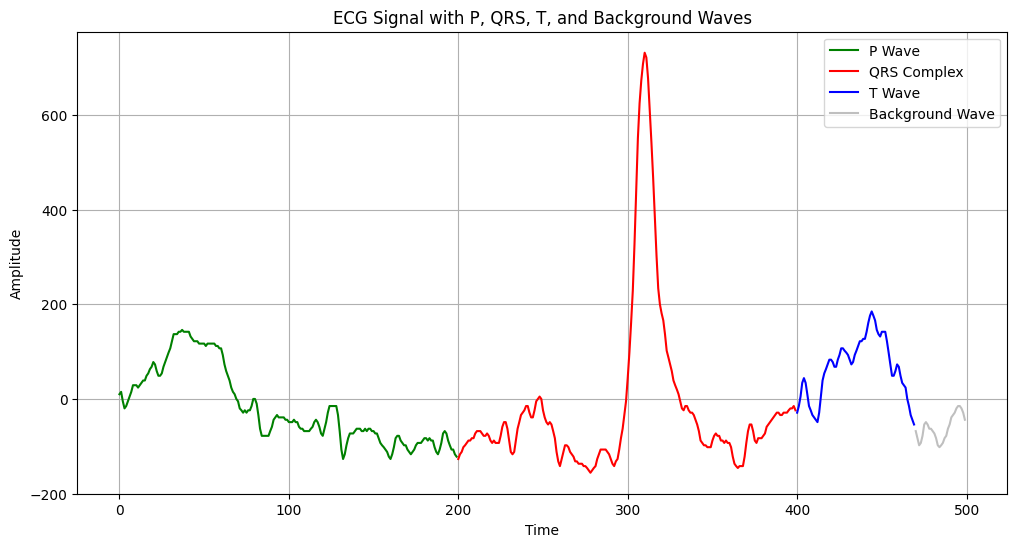

In [ ]:
ecg_signal = temp_data.iloc[0, :500].values

# Define window sizes for different waves (adjust these as needed)
p_wave_window = 200  # Adjust this based on your data
qrs_window = 200    # Adjust this based on your data
t_wave_window = 100  # Adjust this based on your data

# Initialize empty arrays to store segmented waves
p_wave = ecg_signal[:p_wave_window]  # 2 * window size for P wave
qrs_complex = ecg_signal[200:400]  # 2 * window size for QRS complex
t_wave = ecg_signal[400:470]  # Window size for T wave
background_wave = ecg_signal[470:]  # Entire signal for background wave

# Create a time array for plotting
time = np.arange(len(ecg_signal))

# Plot the ECG signal with segmented waves
plt.figure(figsize=(12, 6))
# plt.plot(time, ecg_signal, label='ECG Signal', color='black')
plt.plot(time[:p_wave_window], p_wave, label='P Wave', color='green')
plt.plot(time[200:400], qrs_complex, label='QRS Complex', color='red')
plt.plot(time[400:470], t_wave, label='T Wave', color='blue')
plt.plot(time[470:], background_wave, label='Background Wave', color='gray', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Signal with P, QRS, T, and Background Waves')
plt.legend()
plt.grid(True)
plt.show()


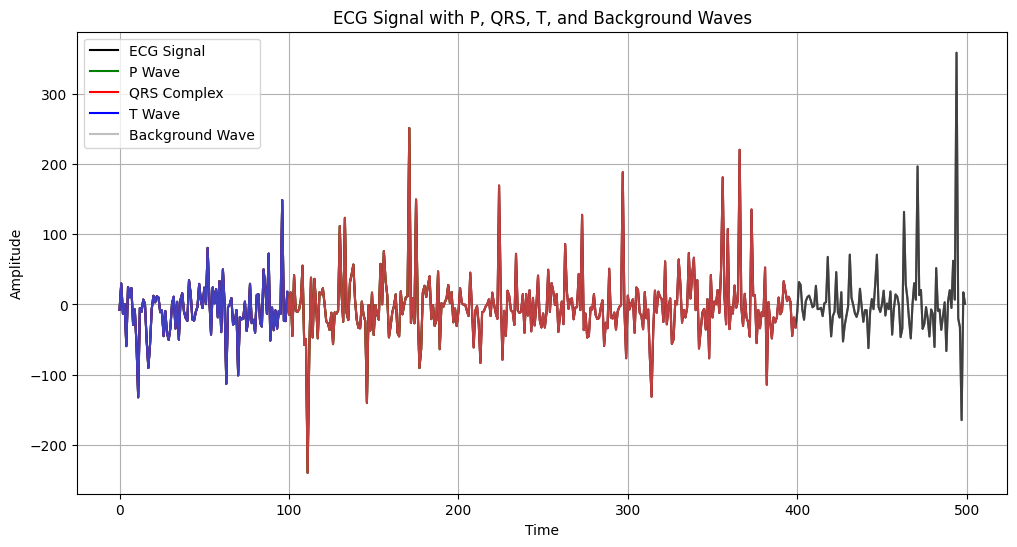

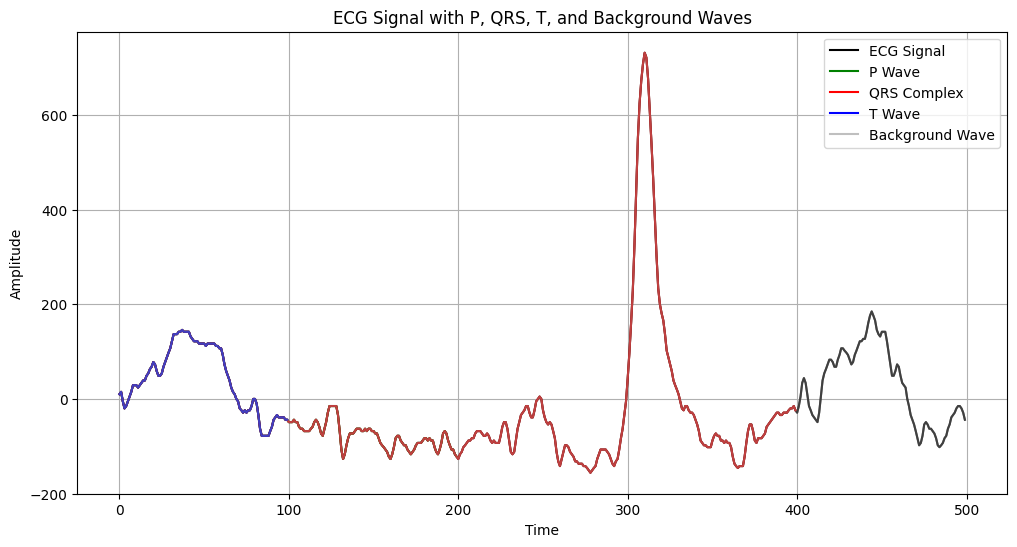

In [ ]:
ecg_signal = ecg_data.iloc[0, 0:500].values

# Define window sizes for different waves (adjust these as needed)
p_wave_window = 100  # Adjust this based on your data
qrs_window = 200    # Adjust this based on your data
t_wave_window = 100  # Adjust this based on your data

# Initialize empty arrays to store segmented waves
p_wave = ecg_signal[:p_wave_window * 2]  # 2 * window size for P wave
qrs_complex = ecg_signal[:qrs_window * 2]  # 2 * window size for QRS complex
t_wave = ecg_signal[:t_wave_window]  # Window size for T wave
background_wave = ecg_signal  # Entire signal for background wave

# Create a time array for plotting
time = np.arange(len(ecg_signal))

# Plot the ECG signal with segmented waves
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_signal, label='ECG Signal', color='black')
plt.plot(time[:len(p_wave)], p_wave, label='P Wave', color='green')
plt.plot(time[:len(qrs_complex)], qrs_complex, label='QRS Complex', color='red')
plt.plot(time[:len(t_wave)], t_wave, label='T Wave', color='blue')
plt.plot(time, background_wave, label='Background Wave', color='gray', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Signal with P, QRS, T, and Background Waves')
plt.legend()
plt.grid(True)
plt.show()

# The first row of the DataFrame contains the ECG signal
ecg_signal = temp_data.iloc[0, 0:500].values

# Define window sizes for different waves (adjust these as needed)
p_wave_window = 100  # Adjust this based on your data
qrs_window = 200    # Adjust this based on your data
t_wave_window = 100  # Adjust this based on your data

# Initialize empty arrays to store segmented waves
p_wave = ecg_signal[:p_wave_window * 2]  # 2 * window size for P wave
qrs_complex = ecg_signal[:qrs_window * 2]  # 2 * window size for QRS complex
t_wave = ecg_signal[:t_wave_window]  # Window size for T wave
background_wave = ecg_signal  # Entire signal for background wave

# Create a time array for plotting
time = np.arange(len(ecg_signal))

# Plot the ECG signal with segmented waves
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_signal, label='ECG Signal', color='black')
plt.plot(time[:len(p_wave)], p_wave, label='P Wave', color='green')
plt.plot(time[:len(qrs_complex)], qrs_complex, label='QRS Complex', color='red')
plt.plot(time[:len(t_wave)], t_wave, label='T Wave', color='blue')
plt.plot(time, background_wave, label='Background Wave', color='gray', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Signal with P, QRS, T, and Background Waves')
plt.legend()
plt.grid(True)
plt.show()